### Overview and Motivation

The goal of this notebook is to place bounds on the phase shift appearing in 2 to 2 scalar scattering amplitudes. The phase shift can be determined by an integral 

$$B (z) \sin \phi (z) = \frac{1}{4 \pi} \int_{- 1}^1 d z_1  \int_0^{2 \pi} d
   \phi_1 B (z_1) B (z_2) e^{i \phi (z_1) - i \phi (z_2)} $$
   
   where we use $z_2 = zz_1 + (1 - z^2)^{1 / 2}  (1 - z_1^2)^{1 / 2} \cos \phi_1$. Here $B(z)$ represents the differential cross section, where $z$ is $\cos \theta$, with $\theta$ the scattering angle. The goal will be to solve this equation for a function $\phi(z)$, the phase shift, assuming that $B(z)$ is given.

There are two questions that we can ask:

   1) For a given $B(z)$ do we have a solution to the equation ? In other words does there exist a unitary scattering amplitude fitting the given differential cross section ?
   
   2) For a given $B(z)$ is the $\phi(z)$ solution unique ? (Up to ambiguities like $f(\cos \theta) \rightarrow -f^\star(\cos \theta)$
   
  In particular bounds have been given in the litterature by considering $$\sup \frac{\int d \Omega_3 B (z_1) B (z_2)}{4 \pi B (z)} \equiv
   \sin \mu $$
   where existence is guaranteed for $\sin \mu <1$ (Martin 1969). Uniqueness has been proved up to $\sin \mu < 1.38$ (Itzykson and Martin).

##### ML angle

To tackle this problem we will represent $\phi(z)$ by a neural network and try and solve the integral equation, by characterizing it as a loss term $\mathcal{L}$.

### Implementation

##### Start with the imports

Import the necessary modules and set up the Neptune logger with the API token and project name.

In [240]:
import os
import neptune.new as neptune
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch import Generator
import math
from collections import OrderedDict
import numpy as np

# Set the Neptune Logger variables
NEPTUNE_API_TOKEN = os.environ.get('NEPTUNE_API_TOKEN')
NEPTUNE_PROJECT = os.environ.get('NEPTUNE_ALIAS') + '/2to2scattering'


Check for available GPU or MPS and set the device for PyTorch tensors.

In [135]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

##### Define the networks

In [664]:
class PhiNet(nn.Module):
    def __init__(self, ffnlayers, activation, device='cpu'):
        """
        Initialize the network with the number of FC layers, the activation function, and the device to use
        """
        super(PhiNet, self).__init__()
        
        self.device = device
        
        if activation=='ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        else:
            raise NotImplemented
        
        # Create a list of layers from the parameters given. Add the appropriate activation function
        self.layer_sizes = ffnlayers
        layer_list = []
        
        for i, layer_size in enumerate(self.layer_sizes):
            if i == 0:
                layer_list.append(('layer_%d' % (i+1), nn.Linear(1, layer_size)))
                layer_list.append(('activation_%d' % (i+1), self.activation))
            else:
                layer_list.append(('layer_%d' % (i+1), nn.Linear(self.layer_sizes[i-1], layer_size)))
                layer_list.append(('activation_%d' %(i+1), self.activation))
        
        layer_list.append(('layer_%d' % (len(self.layer_sizes)+1), nn.Linear(self.layer_sizes[-1], 1)))
        
        # The last layer is sigmoid to constrain outputs between 0 and 1
        layer_list.append(('sigmoid',nn.Sigmoid()))
            
        
        self.model = nn.Sequential(OrderedDict(layer_list))
    
    
    def forward(self, x):
        """
        Network forward pass where the outputs for the phase are in [-pi/2, pi/2]
        """
        #x = (x+1)/2 # Normalize the the cosine input variable
        x = self.model(x)
        x = torch.tensor(math.pi, device=self.device)*x - torch.tensor(math.pi/2, device=self.device)
        return x
    
    
class ModuleNetManual(nn.Module):
    """
    Class for parametrizing the given differential cross section
    """
    def __init__(self, scan_param=None):
        super(ModuleNetManual, self).__init__()
        self.scan_param = scan_param
        
    def forward(self, x):
        """
        Network forward pass is given by a specific function. Can iterate on the overall scale if we want to
        """
        
        denom = self.scan_param if self.scan_param is not None else 1
        #return (-torch.pow(x,3) + torch.pow(x,2) + x + 1)/denom
        return (-0.083*x + 0.125)/denom

class PhaseNetSolver():
    """
    Main class for crafting the simulation
    """
    def __init__(self, params_simu, phi_net, mod_net, optimizer, random_generator, scheduler, device='cpu'):
        """
        Initialize the simulation with the networks, the loss function and the optimizer
        """
        self.eval_points_num = params_simu['integral_points']
        self.loss_func = params_simu['loss']
        self.phi_net = phi_net.to(device)
        self.mod_net = mod_net.to(device)
        self.device = device
        self.rand_gen = random_generator
        
        self.optimizer = optimizer
        self.scheduler = scheduler
    
    def z2(self, z, z1, phi):
        """
        Compute the z2 parameter (formula in motivation)
        Place the batch size on first dim, z1 on the second and phi on the third
        """
        term1 = z.unsqueeze(dim=0).transpose(0, 1) * (z1.unsqueeze(dim=0))
        term2 = torch.sqrt(1 - torch.square(z)).unsqueeze(dim=0).transpose(0, 1) * torch.sqrt(1 - torch.square(z1)).unsqueeze(dim=0)
        return term1.unsqueeze(dim=2) + term2.unsqueeze(dim=2)*torch.cos(phi.unsqueeze(dim=0)).view(1,1,-1)
    
    def integral_approximator(self, z, method='trapz'):
        """
        Approximate the value of the RHS of the integral equation.
        Compute the grids of z1 and phi points for given z values and integrate over the grids
        """
        
        # Linear partition of the space
        z1_points = torch.linspace(-1,1,steps=self.eval_points_num, device=self.device, requires_grad=False)
        phi_points = torch.linspace(0, 2*math.pi, steps=self.eval_points_num, device=self.device, requires_grad=False)
        dx_z1 = 2/(self.eval_points_num-1)
        dx_phi = 2*math.pi/(self.eval_points_num-1)
        
        grid_points = self.mod_net(z1_points).view(1,-1,1)*self.mod_net(self.z2(z, z1_points, phi_points))*torch.cos(self.phi_net(z1_points.view(1,-1,1)) - self.phi_net(self.z2(z, z1_points, phi_points).unsqueeze(dim=-1)).squeeze())
        
        # Simple trapezoid exists in PyTorch
        if method == 'trapz':
            integral = torch.trapezoid(torch.trapezoid(grid_points, dx=dx_phi), dx=dx_z1)/(4*math.pi) 
        
        return integral
    
    def loss_function(self, zsamples, scaled=False, method_int='trapz'):
        """
        Compute a loss based on the average residuals for the integral equation
        """
        
        # For each value of z we estimate the integral equation
        target = torch.ones(zsamples.size(), device=self.device) if scaled else self.mod_net(zsamples)
        model_input = self.integral_approximator(zsamples, method=method_int)/torch.sin(self.phi_net(zsamples.view(-1,1)).squeeze())
        
        # If scaled then all targets should be 1 irrespective of the z point considered
        if scaled:
            model_input = model_input / self.mod_net(zsamples) 
        
        # We have different choices of losses. Huber is more stable to outliers.
        if self.loss_func =='Huber':
            loss_out = F.huber_loss(model_input, target, delta=0.1)
        elif self.loss_func == 'MSE':
            loss_out = F.mse_loss(model_input, target)
        else:
            raise NotImplemented
        
        return loss_out
    
    def point_loss(self, zsamples, scaled=False, method_int='trapz'):
        """
        If we want to know the residuals at each given z point. This is useful for evaluation purposes
        """
        target = torch.ones(zsamples.size(), device=self.device) if scaled else self.mod_net(zsamples) 
        model_input = self.integral_approximator(zsamples, method=method_int)/torch.sin(self.phi_net(zsamples.view(-1,1)).squeeze())
        
        if scaled:
            model_input = model_input / self.mod_net(zsamples) 
        return torch.square(model_input - target)
        
    def train(self, epochs, batch_size, neptune_run, scaled_loss=False, method_int='trapz'):
        """
        Main training loop. 
        Each epoch is a single optimization step over a unique batch.
        A batch is composed of a number of randomly selected z points between -1 and 1
        """
        for epoch_num in range(epochs):
            
            # Set the network in train mode
            self.phi_net.train()
            zpoints = torch.rand(batch_size, requires_grad=False, generator=self.rand_gen, device='cpu').to(self.device)*2 - 1
            
            # Zero the grads, get the loss and backpropagate
            self.optimizer.zero_grad()
            loss = self.loss_function(zpoints, scaled=scaled_loss, method_int=method_int)
            loss.backward()
            neptune_run['metrics/learning_rate'].log(self.optimizer.param_groups[0]["lr"])
            self.optimizer.step()
            if self.scheduler is not None:
                self.scheduler.step()
            neptune_run['metrics/train_loss'].log(loss)
            
            if epoch_num % 15 == 0:
                print('Train Epoch: {} ; tLoss: {:.6f}'.format(epoch_num, loss.item()))

def scheduler_rate(step, factor, size_param, warmup):
    """
    For the Learning Rate scheduler we implement a warmup start, followed by a square root decay
    """
    if step == 0:
        step = 1
    return factor * size_param**(-0.5) * min(step**(-0.5), step*warmup ** (-1.5))

##### Define the training run

In [665]:
from torchinfo import summary

def train_run(parameters, device, run_neptune, module_net=None):
    """
    Function to call for launching the training run
    """
    # Fix for the generator : For reproducibility between cpu and MPS
    random_gen_cpu = Generator(device='cpu')
    random_gen_cpu.manual_seed(42)
    torch.manual_seed(42)   
    torch.cuda.manual_seed(42)

    
    # Define and register the networks
    phinn = PhiNet(parameters['layer_list'], parameters['activation'], device=device)
    run_neptune["config/phimodel"] = type(phinn).__name__
    with open(f"model_arch.txt", "w") as f:
        f.write(str(summary(phinn, verbose=0, col_width=16, device=device)))
        f.write(str(phinn))
    print(str(phinn))
    
    if module_net is None:
        modnn = ModuleNetManual(scan_param=parameters['scan_param'])
    else:
        modnn = module_net
    run_neptune["config/modmodel"] = type(modnn).__name__

    run_neptune["model_arch"].upload("model_arch.txt")
    
    # Define and register the optimizer and scheduler
    optimizer = torch.optim.Adam(phinn.parameters(), lr=parameters['learning_rate'], betas=(parameters['beta1'], parameters['beta2']))
    run_neptune["config/optimizer"] = type(optimizer).__name__
    
    if parameters['lr_scheduler']:
        lr_scheduler = LambdaLR(optimizer=optimizer, lr_lambda=lambda step: scheduler_rate(step, 1/parameters['learning_rate'], 2048, 750))
    else:
        lr_scheduler = None
    
    # Create the simulation, train it and return the trained result
    netsolver = PhaseNetSolver(parameters, phinn, modnn, optimizer, random_gen_cpu, lr_scheduler, device=device)
    netsolver.train(parameters['epochs_num'], parameters['batch_size'], run_neptune, scaled_loss=parameters['scaled_loss'] , method_int=parameters['method_int'])

    return netsolver

##### Define the evaluation run

In [666]:
def eval_run(trained_solver, params, device, neptune_run, steps_eval=100):
    """
    At evaluation we verify if the integral equation is satisfied. 
    For this we take a larger sample of z points
    """
    
    # Make sure we are in evaluation mode
    trained_solver.phi_net.eval()
    with torch.no_grad(): 
        
        # Create the evaluation points and compute the phase at those points
        zpointstest = torch.linspace(-1,1,steps=steps_eval, device=device)
        results = trained_solver.phi_net(zpointstest.view(-1,1))
        phires = results.squeeze().cpu().numpy()
        sinphires = torch.sin(results).squeeze().cpu().numpy()
        
        # Also log the final loss values. Including the loss at individual z values
        eval_loss_scaled = trained_solver.loss_function(zpointstest, scaled=True, method_int=params['method_int'])
        neptune_run['metrics/eval_loss_scaled'].log(eval_loss_scaled)
        
        eval_loss_base = trained_solver.loss_function(zpointstest, scaled=False, method_int=params['method_int'])
        neptune_run['metrics/eval_loss_base'].log(eval_loss_base)
        
        eval_point_loss_scaled = trained_solver.point_loss(zpointstest, scaled=True, method_int=params['method_int'])
        eval_point_loss_non_scaled = trained_solver.point_loss(zpointstest, scaled=False, method_int=params['method_int'])
    
    return zpointstest, phires, sinphires, eval_point_loss_scaled, eval_point_loss_non_scaled

##### Check the value of the $\sin(\mu)$ parameter

In [667]:
def sin_mu_integral(params, device, trained_solver, zpoints):
    """
    Helper function to compute the sin(\mu) variable defined in the motivation.
    This compute the relevant integral involving the differential cross section
    """
    z1_points = torch.linspace(-1,1,steps=params['integral_points'], device=device)
    phi_points = torch.linspace(0, 2*math.pi, steps=params['integral_points'], device=device)
    dx_z1 = 2/(params['integral_points']-1)
    dx_phi = 2*math.pi/(params['integral_points']-1)
        
    grid_points = trained_solver.mod_net(z1_points).view(1,-1,1)*trained_solver.mod_net(netsolver.z2(zpoints, z1_points, phi_points))
        
    integral = torch.trapezoid(torch.trapezoid(grid_points, dx=dx_phi), dx=dx_z1)/(4*math.pi) 
        
    return integral/trained_solver.mod_net(zpoints)
   

##### Define the plotting routines

In [668]:
import matplotlib.pyplot as plt
from neptune.new.types import File

def plot_phase(zpoints, phipoints, neptune_run):

    fig = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(),phipoints, 'b-', linewidth = 2)       
    plt.xlabel('$z$')
    plt.ylabel('$\phi(z)$')    
    plt.title('$\phi(z)$ prediction', fontsize = 15)
    plt.xlim([-1,1])
    plt.show()

    neptune_run[f'evaluation/phase_prediction'].upload(File.as_image(fig))
    plt.close(fig)
    
    
def plot_point_loss(zpoints, point_loss_data_s, point_loss_data_no_s, neptune_run):

    fig = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(), point_loss_data_s.cpu(), 'b-', linewidth = 2)  
    plt.plot(zpoints.cpu(), point_loss_data_no_s.cpu(), 'g-', linewidth = 2)  
    plt.xlabel('$z$')
    plt.ylabel('$||\mathcal{L}(z)||_2$')    
    plt.title('Point loss evaluation', fontsize = 15)
    plt.xlim([-1,1])
    plt.legend(['Normalized loss at each point', 'Base loss'])
    plt.show()

    neptune_run[f'evaluation/point_loss_evaluation'].upload(File.as_image(fig))
    plt.close(fig)
    

def plot_sin_mu(zpoints, integralpoints, tags_run):

    sinmu = max(integralpoints.cpu())

    fig2 = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(),integralpoints.cpu(), 'g-', linewidth = 2)   
    plt.plot(zpoints.cpu(),sinmu.repeat(integralpoints.size(dim=0)), 'r--' )
    plt.xlabel('$z$')
    plt.ylabel('$\sin \mu(z)$')    
    plt.title('Differential cross section categorization: B(z) = {}'.format(tags_run['constant function']), fontsize = 15)
    plt.xlim([-1,1])
    plt.legend(['$\sin\mu(z)$','$\sin \mu$={}'.format(str(np.round(sinmu.numpy(),4)))])
    plt.show()
    
def plot_summary(zpoints, phipoints, sinphipoints, integralpoints, neptune_run, tags_run):
    
    sinmu = max(integralpoints.cpu())
    
    fig3 = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(),phipoints, 'b-', linewidth = 2)       
    plt.plot(zpoints.cpu(),sinphipoints, 'b--', linewidth = 2)       
    plt.plot(zpoints.cpu(),integralpoints.cpu(), 'g-', linewidth = 2)   
    plt.plot(zpoints.cpu(),sinmu.repeat(integralpoints.size(dim=0)), 'r--' )
    plt.xlabel('$z$')
    plt.ylabel('$\sin \mu(z)$')    
    plt.title('Differential cross section categorization: B(z) = {}'.format(tags_run['constant function']), fontsize = 15)
    plt.xlim([-1,1])
    plt.legend(['$\phi(z)$', '$\sin \phi(z)$','$\sin\mu(z)$','$\sin \mu$={}'.format(str(np.round(sinmu.numpy(),4)))])
    plt.show()

    neptune_run[f'evaluation/overview'].upload(File.as_image(fig3))
    plt.close(fig3)

### Single function Run

##### Define the parameters

In [669]:
# Start the Neptune logger run
run = neptune.init_run(project=NEPTUNE_PROJECT, api_token=NEPTUNE_API_TOKEN, name="Run_Test_15")

params = {'batch_size': 64,
         'epochs_num': 1000,
         'learning_rate': 0.001,
         'lr_scheduler': False, 
         'beta1' : 0.85,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'activation': 'ReLU',
         'layer_list': [64, 128, 128, 64],
         'loss': 'Huber',
         'scaled_loss': True,
         'scan_param': 1}

tags = {'constant function': '(-0.083*z+0.125)/1', 'optimizer': 'Adam', 'Mode': 'Constant param', 'Huber': '0.1'}
run["sys/tags"].add(list(tags.values()))

run['parameters'] = params

https://app.neptune.ai/zulap/2to2scattering/e/TOS-314
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


##### Training run

In [670]:
netsolver = train_run(params, device, run)

PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.047261
Train Epoch: 15 ; tLoss: 0.003709
Train Epoch: 30 ; tLoss: 0.000654
Train Epoch: 45 ; tLoss: 0.000117
Train Epoch: 60 ; tLoss: 0.000087
Train Epoch: 75 ; tLoss: 0.000047
Train Epoch: 90 ; tLoss: 0.000034
Train Epoch: 105 ; tLoss: 0.000016
Train Epoch: 120 ; tLoss: 0.000018
Train Epoch: 135 ; tLoss: 0.000038
Train Epoch: 150 ; tLoss: 0.000094
Train Epoch: 165 ; tLoss: 0.000158
Train Epoch: 180 ; tLoss: 0.000003
Train Epoch: 195 ; tLoss: 0.

Exception in thread NeptuneAsyncOpProcessor:
Traceback (most recent call last):
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/site-packages/neptune/new/internal/backends/swagger_client_wrapper.py", line 92, in __call__
    return FinishedApiResponseFuture(future.response())  # wait synchronously
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/site-packages/bravado/http_future.py", line 124, in wrapper
    return func(self, *args, **kwargs)
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/site-packages/bravado/http_future.py", line 300, in _get_swagger_result
    unmarshal_response(
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/site-packages/bravado/http_future.py", line 353, in unmarshal_response
    raise_on

Train Epoch: 285 ; tLoss: 0.000007
Train Epoch: 300 ; tLoss: 0.000164
Train Epoch: 315 ; tLoss: 0.000121
Train Epoch: 330 ; tLoss: 0.000003
Train Epoch: 345 ; tLoss: 0.000001
Train Epoch: 360 ; tLoss: 0.000004
Train Epoch: 375 ; tLoss: 0.000009
Train Epoch: 390 ; tLoss: 0.000001
Unexpected error occurred in Neptune background thread: Killing Neptune ping thread. Your run's status will not be updated and the run will be shown as inactive.


Exception in thread NeptunePing:
Traceback (most recent call last):
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/site-packages/neptune/new/internal/backends/swagger_client_wrapper.py", line 92, in __call__
    return FinishedApiResponseFuture(future.response())  # wait synchronously
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/site-packages/bravado/http_future.py", line 124, in wrapper
    return func(self, *args, **kwargs)
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/site-packages/bravado/http_future.py", line 300, in _get_swagger_result
    unmarshal_response(
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/site-packages/bravado/http_future.py", line 353, in unmarshal_response
    raise_on_expected(in

Train Epoch: 405 ; tLoss: 0.000003
Train Epoch: 420 ; tLoss: 0.000002
Train Epoch: 435 ; tLoss: 0.000006
Train Epoch: 450 ; tLoss: 0.000829
Train Epoch: 465 ; tLoss: 0.000060
Train Epoch: 480 ; tLoss: 0.000003
Train Epoch: 495 ; tLoss: 0.000000
Train Epoch: 510 ; tLoss: 0.000005
Train Epoch: 525 ; tLoss: 0.000000
Train Epoch: 540 ; tLoss: 0.000001
Train Epoch: 555 ; tLoss: 0.000001
Train Epoch: 570 ; tLoss: 0.000000
Train Epoch: 585 ; tLoss: 0.000002
Train Epoch: 600 ; tLoss: 0.000000
Train Epoch: 615 ; tLoss: 0.000000
Train Epoch: 630 ; tLoss: 0.000001
Train Epoch: 645 ; tLoss: 0.000015
Train Epoch: 660 ; tLoss: 0.000005
Train Epoch: 675 ; tLoss: 0.000046
Train Epoch: 690 ; tLoss: 0.000010
Train Epoch: 705 ; tLoss: 0.000006
Train Epoch: 720 ; tLoss: 0.000005
Train Epoch: 735 ; tLoss: 0.000002
Train Epoch: 750 ; tLoss: 0.000002
Train Epoch: 765 ; tLoss: 0.000000
Train Epoch: 780 ; tLoss: 0.000000
Train Epoch: 795 ; tLoss: 0.000001
Train Epoch: 810 ; tLoss: 0.000001
Train Epoch: 825 ; t

##### Evaluation and plots

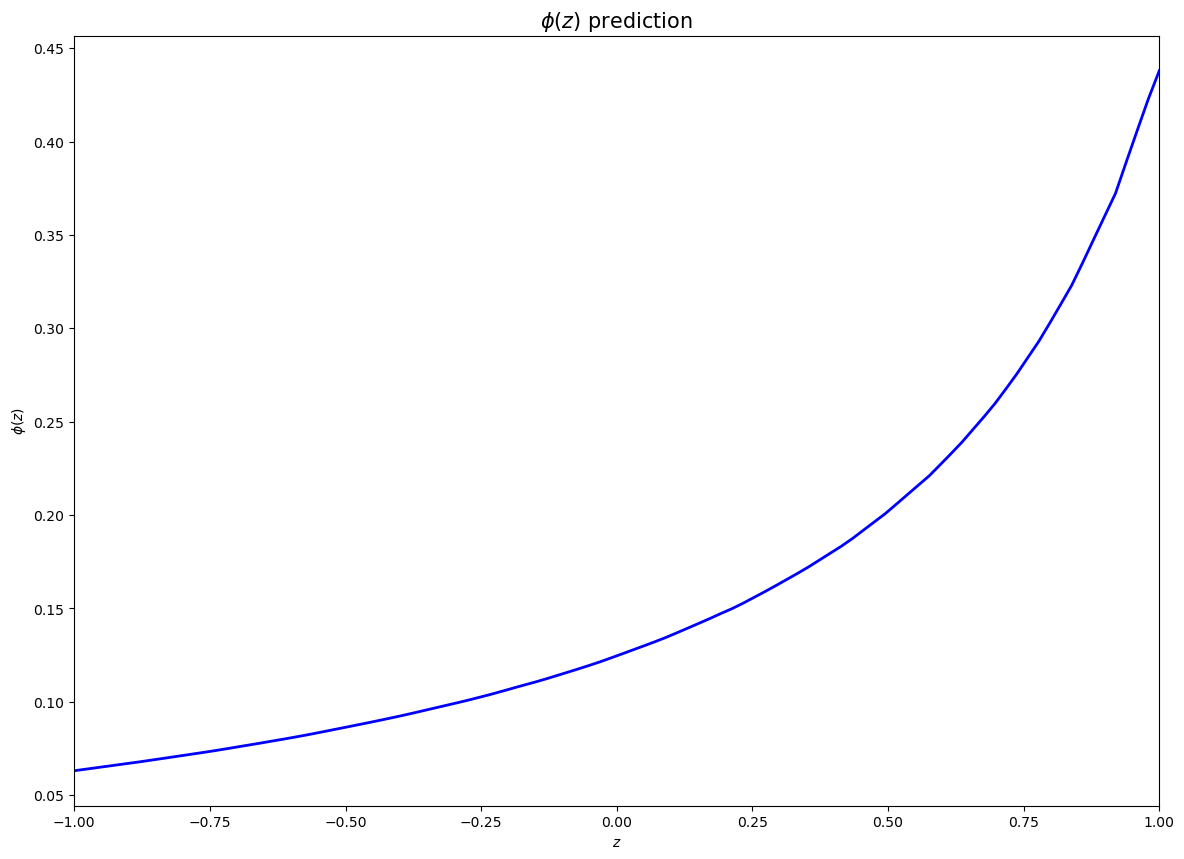

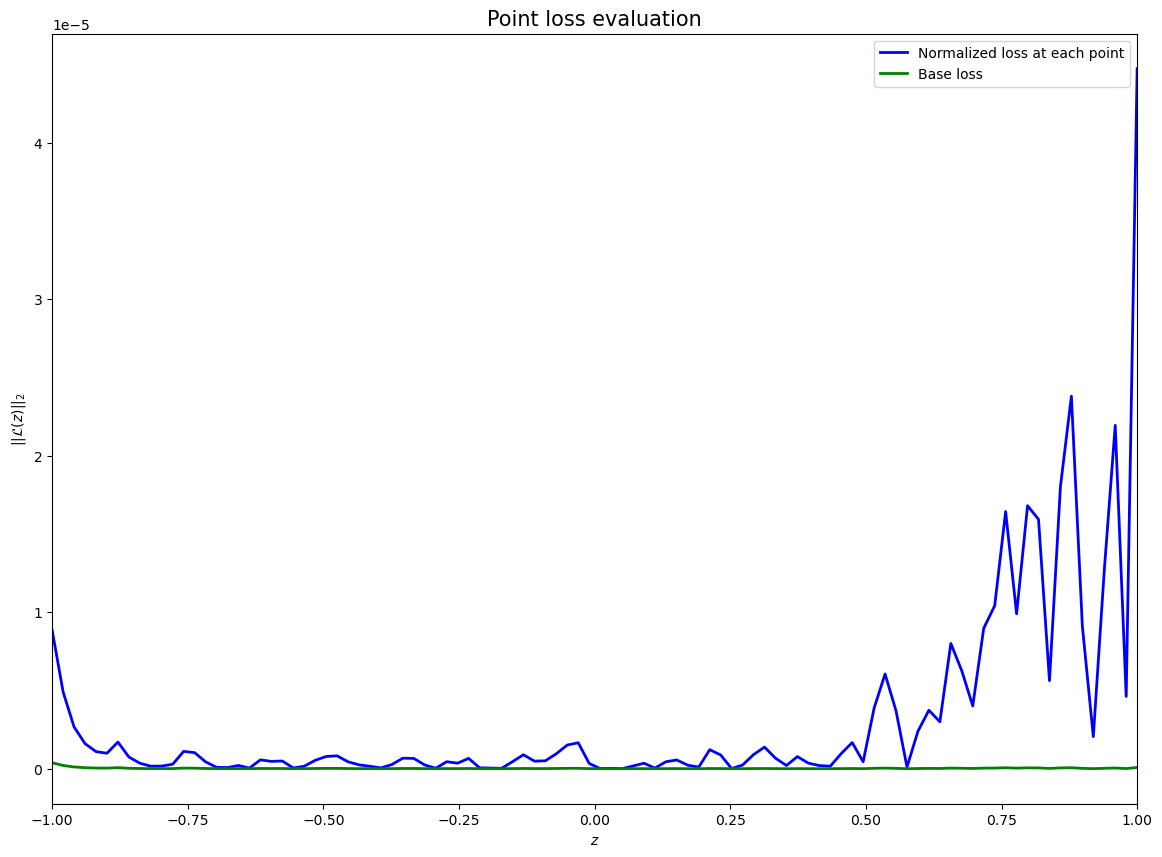

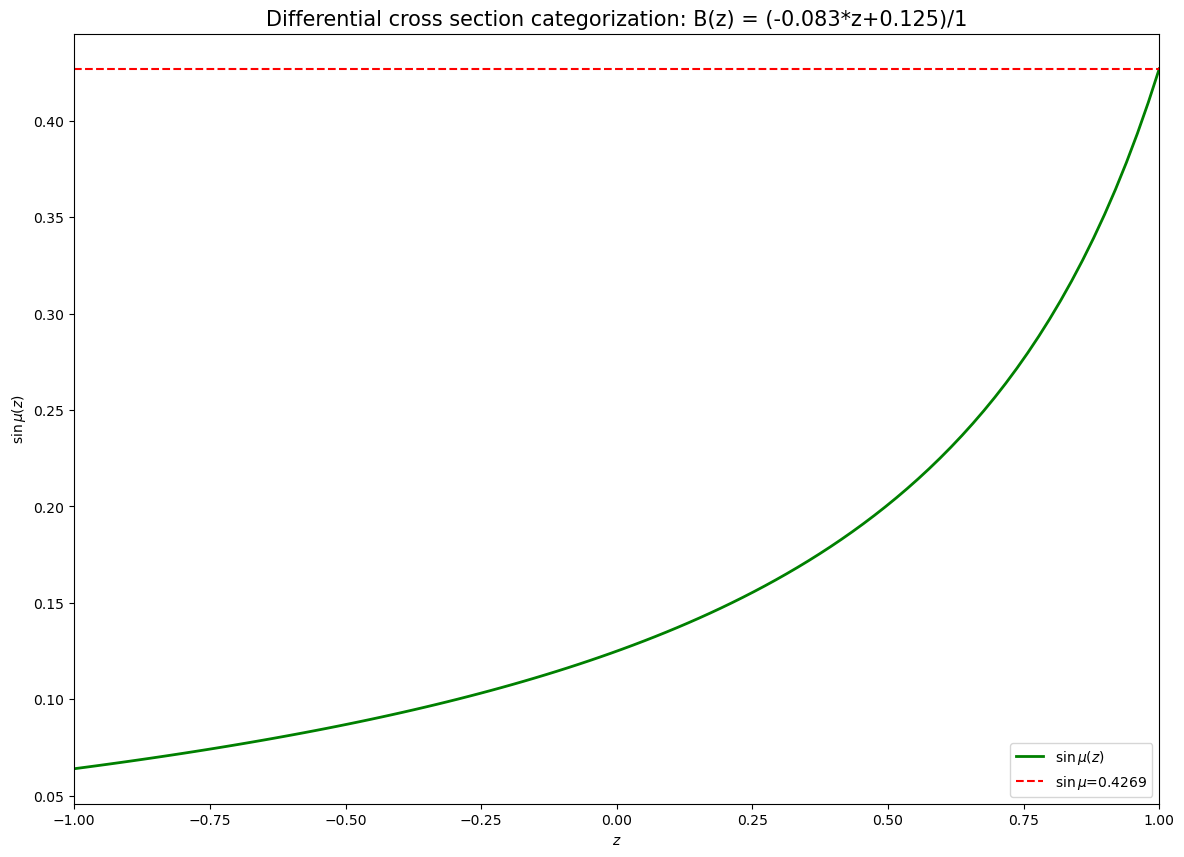

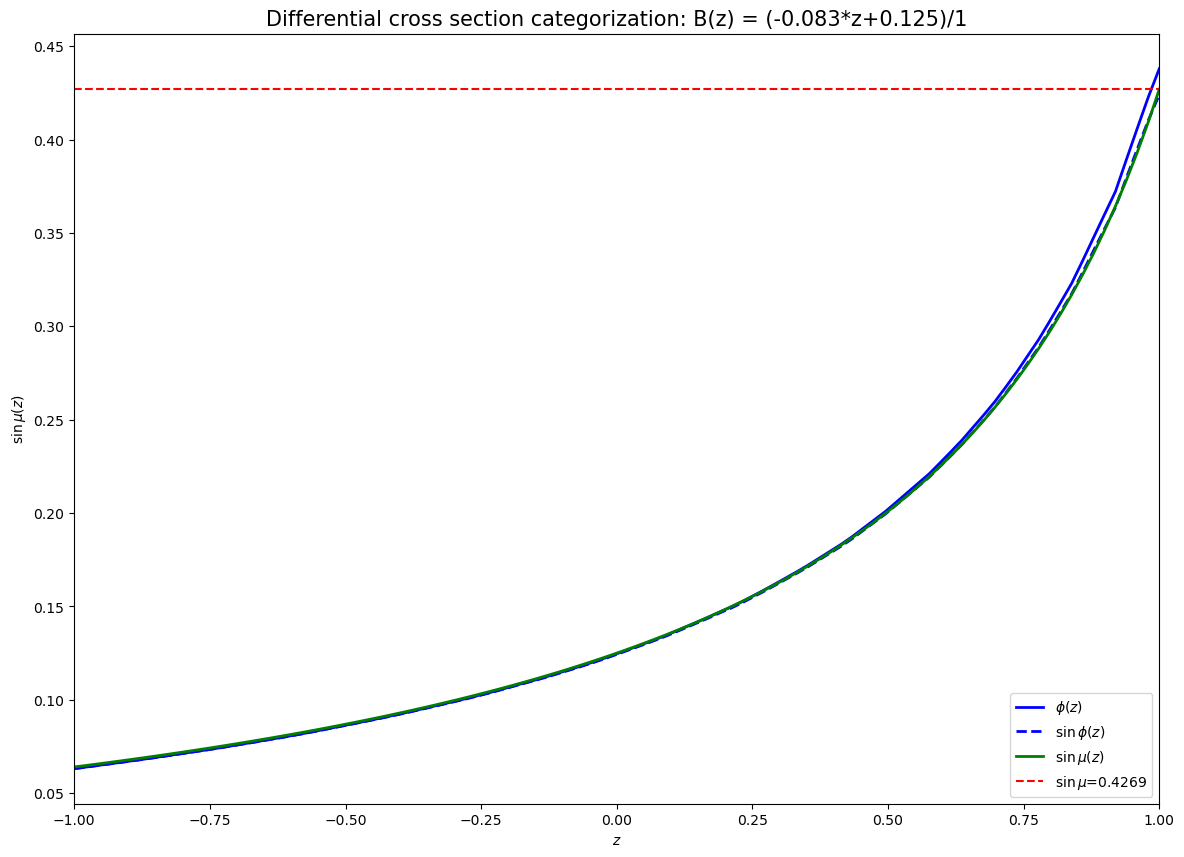

In [671]:
zpointseval, phieval, sinphieval, eval_pt_loss_s, eval_pt_loss_no_s = eval_run(netsolver, params, device, run)

plot_phase(zpointseval, phieval, run)
plot_point_loss(zpointseval, eval_pt_loss_s, eval_pt_loss_no_s, run)

integralz = sin_mu_integral(params, device, netsolver, zpointseval)
plot_sin_mu(zpointseval, integralz, tags)

plot_summary(zpointseval, phieval, sinphieval, integralz, run, tags)

In [672]:
# Make sure to kill the Neptune logger run
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 48 operations to synchronize with Neptune. Do not kill this process.
All 48 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-314


##### Error on the trapezoidal rule

The error on the trapezoidal rul is bounded by $$E\leq \max_x \frac{(b-a)^3}{12 N^2} |f''(x)|$$ The scaling with the number of evaluation points goes as $N^{-2}$ which is relevant for us to put some bound on the expected answer. In a multidimensional setting we can still expect the global error to grow as $N^{-2}$.

In [358]:
import sympy as sp

symbz = sp.Symbol('z')
symbphi = sp.Symbol('\phi')
symbz1 = sp.Symbol('z_1')

funcz = (1+symbz+symbz**2-symbz**3)/3
completesol=sp.factor(sp.integrate(sp.integrate((funcz.subs(symbz,symbz1) * funcz.subs(symbz,symbz1*symbz + sp.sqrt(1-symbz**2)*sp.sqrt(1-symbz1**2)*sp.cos(symbphi)))/(4*sp.pi*funcz),(symbphi, 0,2*sp.pi)),(symbz1,-1,1)))

In [362]:
params['integral_points'] = 25

integralapprox = sin_mu_integral(params, device, netsolver, zpointseval).to('cpu')
integralexact = torch.FloatTensor([completesol.subs(symbz,pt) for pt in zpointseval], device='cpu')
base=integralapprox - integralexact
print(base)
print(max(base))
print(min(base))

tensor([ 7.7218e-04,  7.7960e-04,  7.8663e-04,  7.9292e-04,  7.9852e-04,
         8.0335e-04,  8.0720e-04,  8.1030e-04,  8.1220e-04,  8.1304e-04,
         8.1235e-04,  8.1053e-04,  8.0717e-04,  8.0210e-04,  7.9554e-04,
         7.8708e-04,  7.7683e-04,  7.6455e-04,  7.5054e-04,  7.3445e-04,
         7.1639e-04,  6.9654e-04,  6.7455e-04,  6.5082e-04,  6.2543e-04,
         5.9837e-04,  5.7006e-04,  5.4049e-04,  5.0974e-04,  4.7839e-04,
         4.4638e-04,  4.1419e-04,  3.8195e-04,  3.4988e-04,  3.1841e-04,
         2.8741e-04,  2.5749e-04,  2.2864e-04,  2.0105e-04,  1.7464e-04,
         1.5008e-04,  1.2696e-04,  1.0550e-04,  8.5831e-05,  6.7890e-05,
         5.1737e-05,  3.7313e-05,  2.4617e-05,  1.3709e-05,  4.3511e-06,
        -3.3975e-06, -9.5963e-06, -1.4424e-05, -1.7524e-05, -1.9670e-05,
        -2.0266e-05, -1.9610e-05, -1.7971e-05, -1.5080e-05, -1.1235e-05,
        -6.3777e-06, -5.0664e-07,  6.2585e-06,  1.3798e-05,  2.2173e-05,
         3.1441e-05,  4.1366e-05,  5.2005e-05,  6.3

In [363]:
params['integral_points'] = 50

integralapprox = sin_mu_integral(params, device, netsolver, zpointseval).to('cpu')
integralexact = torch.FloatTensor([completesol.subs(symbz,pt) for pt in zpointseval])
print(base/(integralapprox - integralexact))

tensor([4.1716, 4.1708, 4.1692, 4.1689, 4.1696, 4.1689, 4.1688, 4.1682, 4.1678,
        4.1663, 4.1685, 4.1662, 4.1668, 4.1675, 4.1657, 4.1643, 4.1652, 4.1660,
        4.1654, 4.1642, 4.1646, 4.1632, 4.1622, 4.1644, 4.1639, 4.1621, 4.1619,
        4.1596, 4.1636, 4.1650, 4.1582, 4.1636, 4.1610, 4.1572, 4.1572, 4.1605,
        4.1578, 4.1650, 4.1591, 4.1679, 4.1551, 4.1602, 4.1647, 4.1618, 4.1722,
        4.1731, 4.1733, 4.1300, 4.1818, 4.5625, 3.8000, 4.0250, 4.1017, 4.1408,
        4.0741, 4.0476, 4.1646, 4.0743, 4.0480, 3.9684, 3.8909, 1.7000, 4.3750,
        4.3271, 4.3006, 4.2540, 4.2188, 4.2048, 4.1996, 4.1887, 4.1901, 4.1857,
        4.1883, 4.1864, 4.1813, 4.1763, 4.1777, 4.1775, 4.1749, 4.1750, 4.1737,
        4.1725, 4.1707, 4.1733, 4.1709, 4.1680, 4.1692, 4.1677, 4.1691, 4.1691,
        4.1668, 4.1663, 4.1662, 4.1664, 4.1644, 4.1672, 4.1644, 4.1659, 4.1640,
        4.1648])


In [364]:
params['integral_points'] = 250

integralapprox = sin_mu_integral(params, device, netsolver, zpointseval).to('cpu')
integralexact = torch.FloatTensor([completesol.subs(symbz,pt) for pt in zpointseval])
print(base/(integralapprox - integralexact))

tensor([ 108.4100,  107.6502,  107.2967,  107.2823,  108.0403,  107.3944,
         109.2137,  107.4664,  107.7194,  106.5664,  108.1667,  107.0748,
         107.0514,  107.2271,  107.6371,  107.3577,  107.7107,  107.7899,
         107.6239,  107.1478,  109.2636,  107.2110,  105.7664,  109.1900,
         108.1753,  109.1196,  108.6818,  106.6824,  108.2532,  108.4595,
         108.5362,  106.9077,  106.8000,  110.7547,  106.8400,  109.5909,
         108.0000,  106.5556,  105.4062,  112.6923,  114.4545,  101.4286,
         110.6250,  120.0000,  113.9000,  124.0000,  125.2000,  103.2500,
        -230.0000,   73.0000,   28.5000,   80.5000,   80.6667,   98.0000,
          66.0000,   68.0000,  109.6667,   67.0000,  101.2000,   75.4000,
          71.3333,    8.5000,   70.0000,  154.3333,  148.8000,  105.5000,
         106.7692,  124.6429,  106.2500,  110.0000,  118.1600,  103.1212,
         113.8235,  114.6842,  113.1860,  108.0000,  112.2453,  110.5254,
         109.4462,  110.4000,  108.623

As we increase the number of integral points considered we can verify the $N^{-2}$ scaling. Going from 25 points (per dimension) to 50 points indeed decreases the error by a factor 4, while going to 250 points decreases the error by a factor 100.

### Scan over Function runs

https://app.neptune.ai/zulap/2to2scattering/e/TOS-276
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 11.670553
Train Epoch: 15 ; tLoss: 0.895303
Train Epoch: 30 ; tLoss: 0.209833
Train Epoch: 45 ; tLoss: 0.217762
Train Epoch: 60 ; tLoss: 0.172982
Train Epoch: 75 ; tLoss: 0.211367
Train Epoc

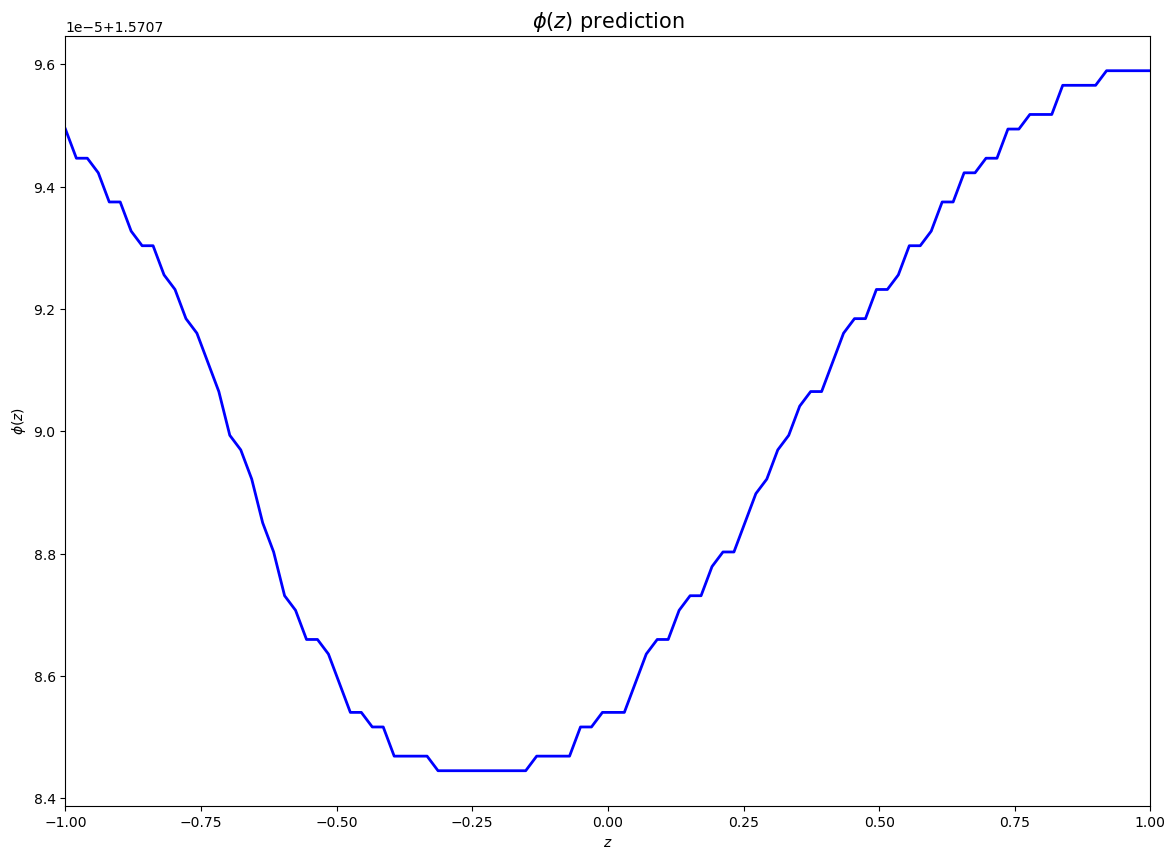

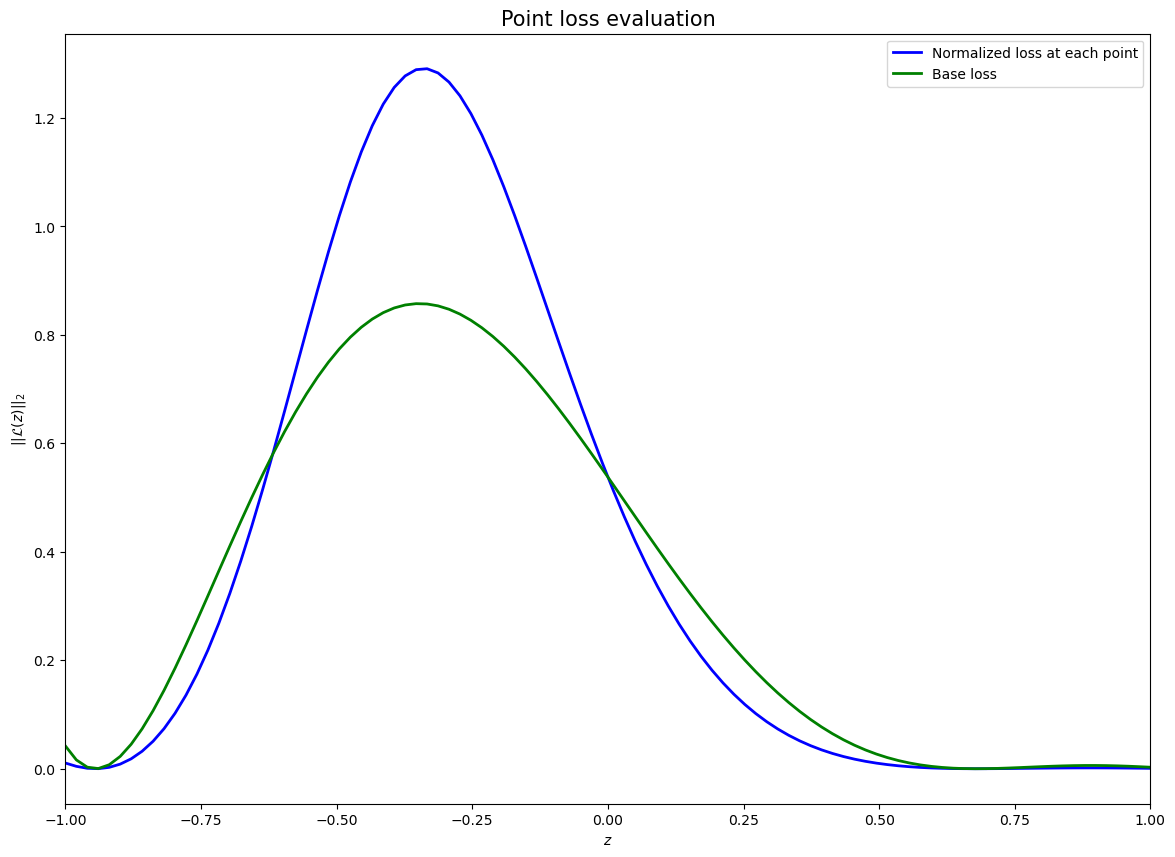

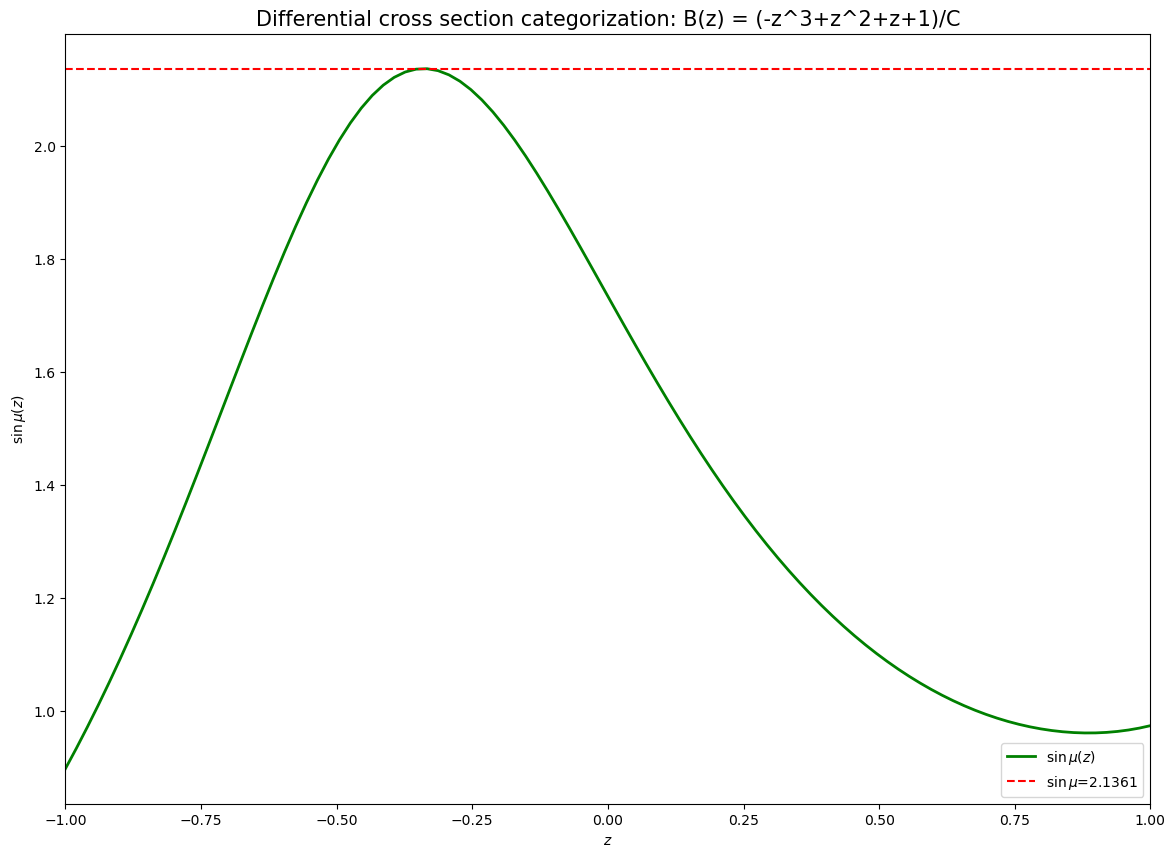

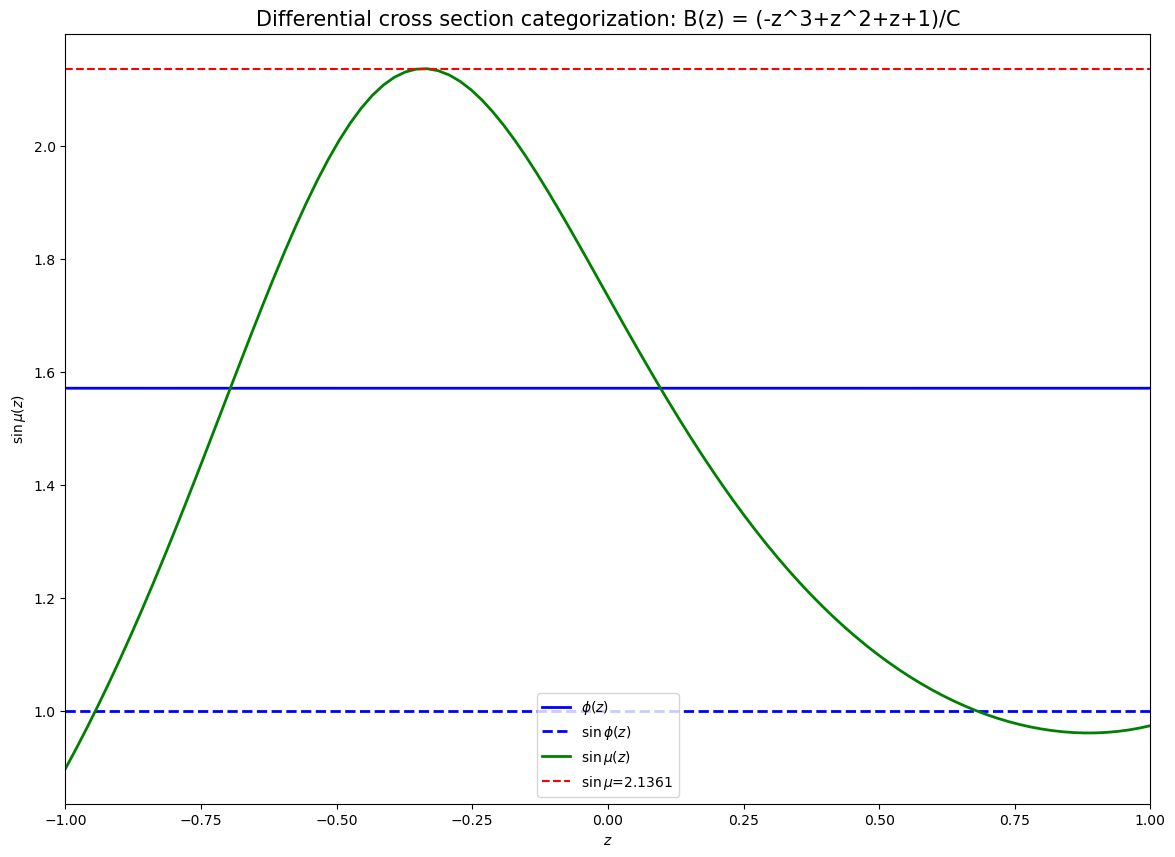

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 38 operations to synchronize with Neptune. Do not kill this process.
All 38 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-276
https://app.neptune.ai/zulap/2to2scattering/e/TOS-277
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5)

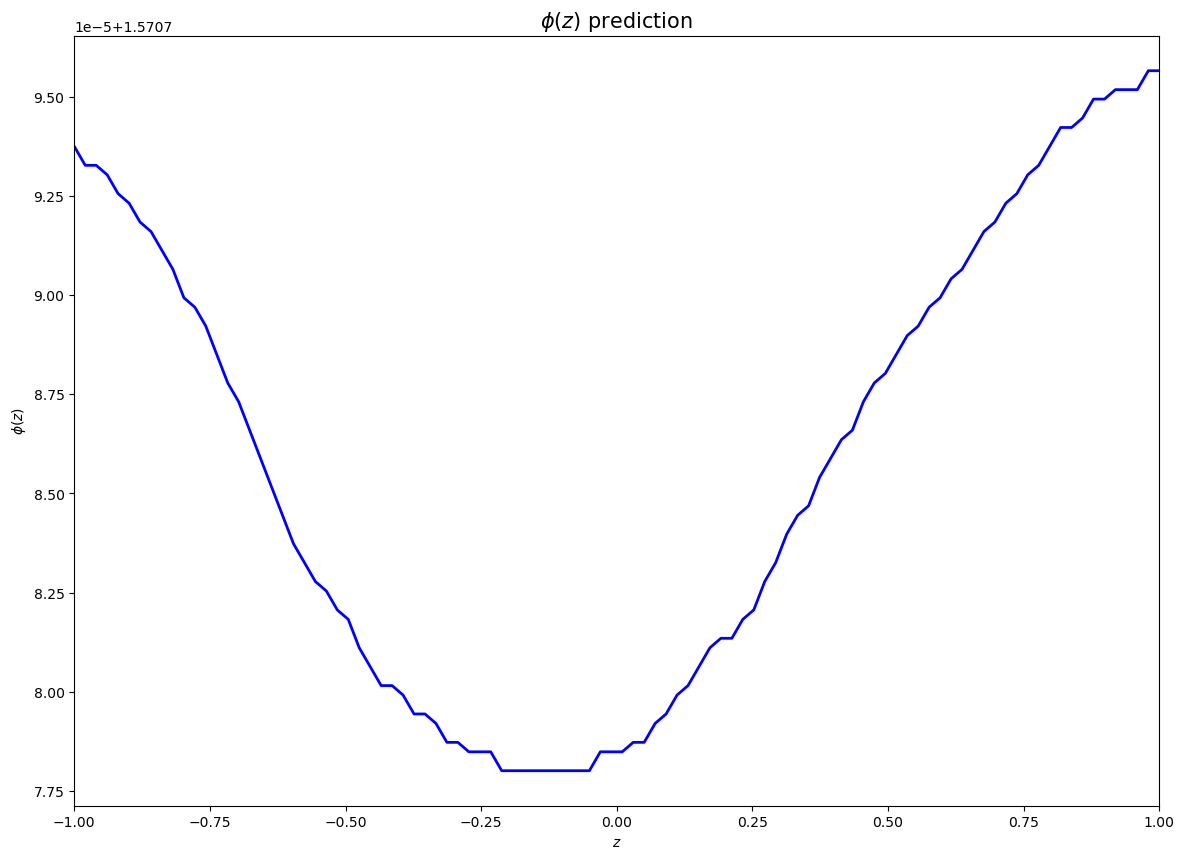

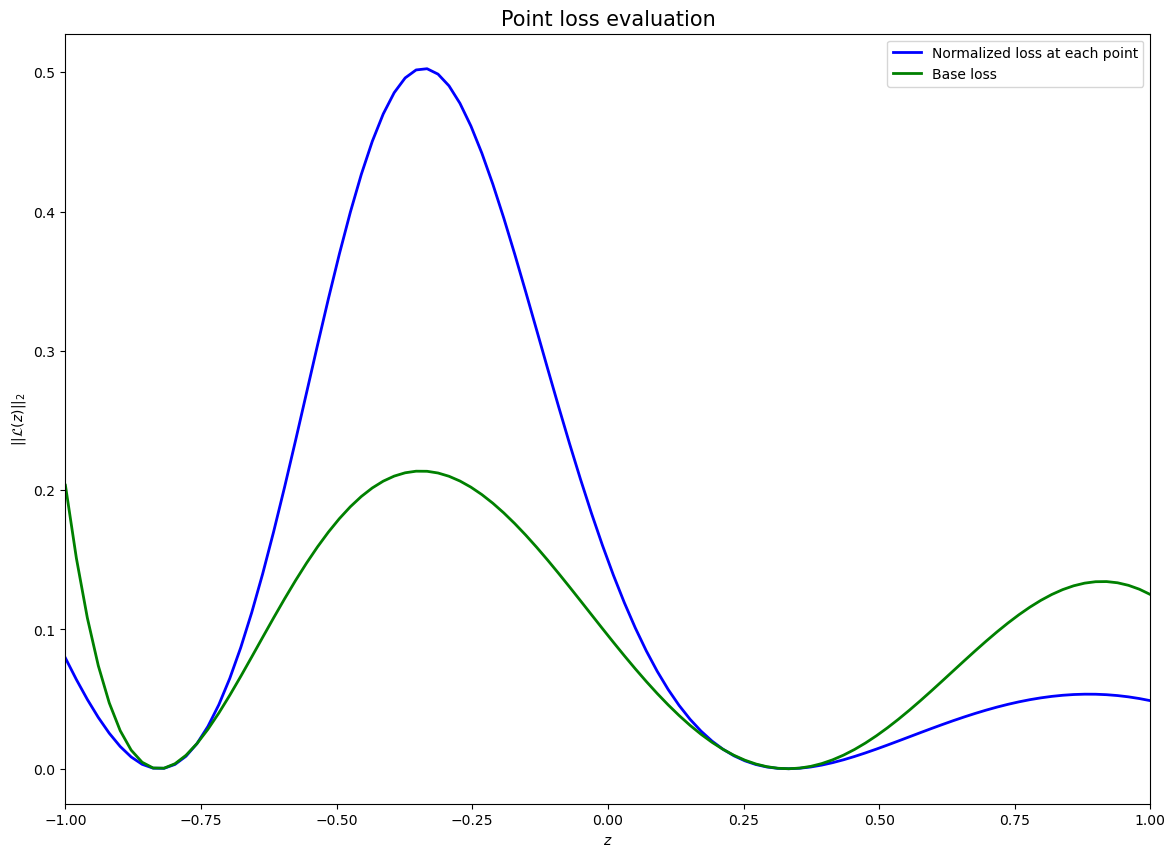

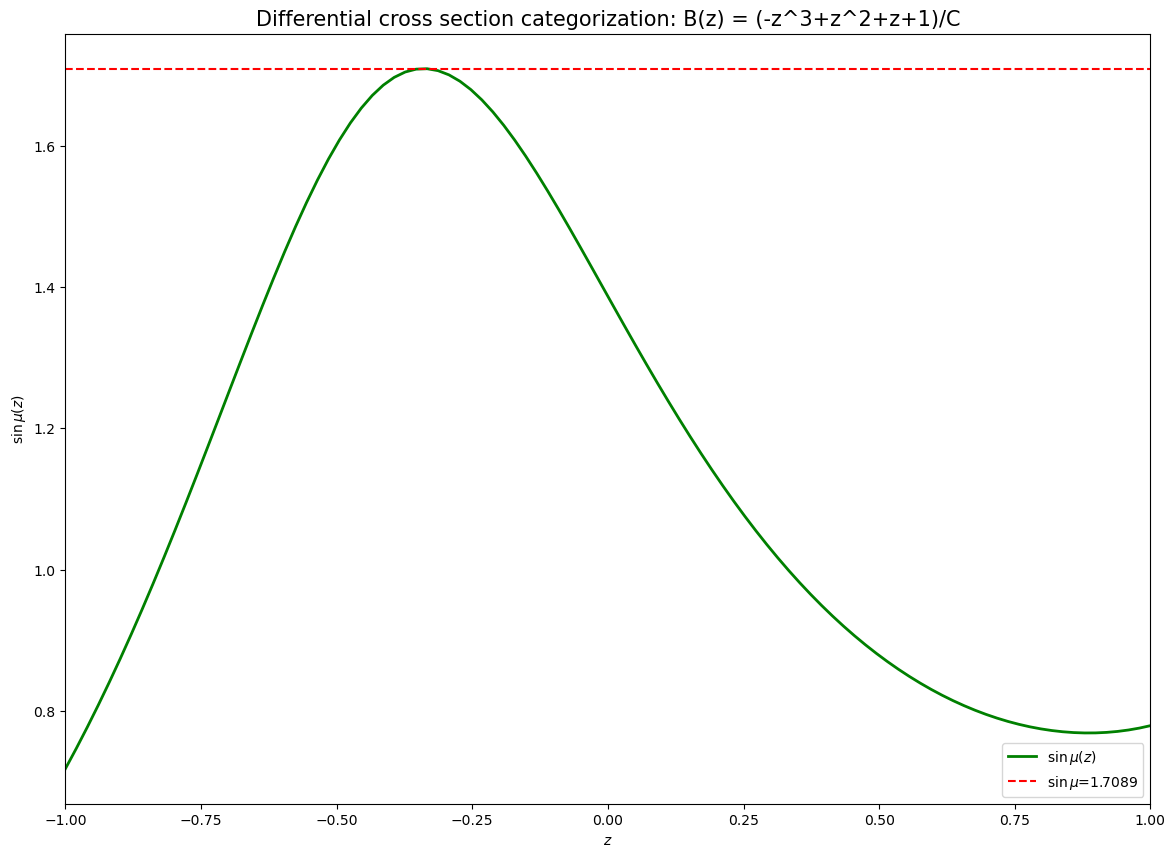

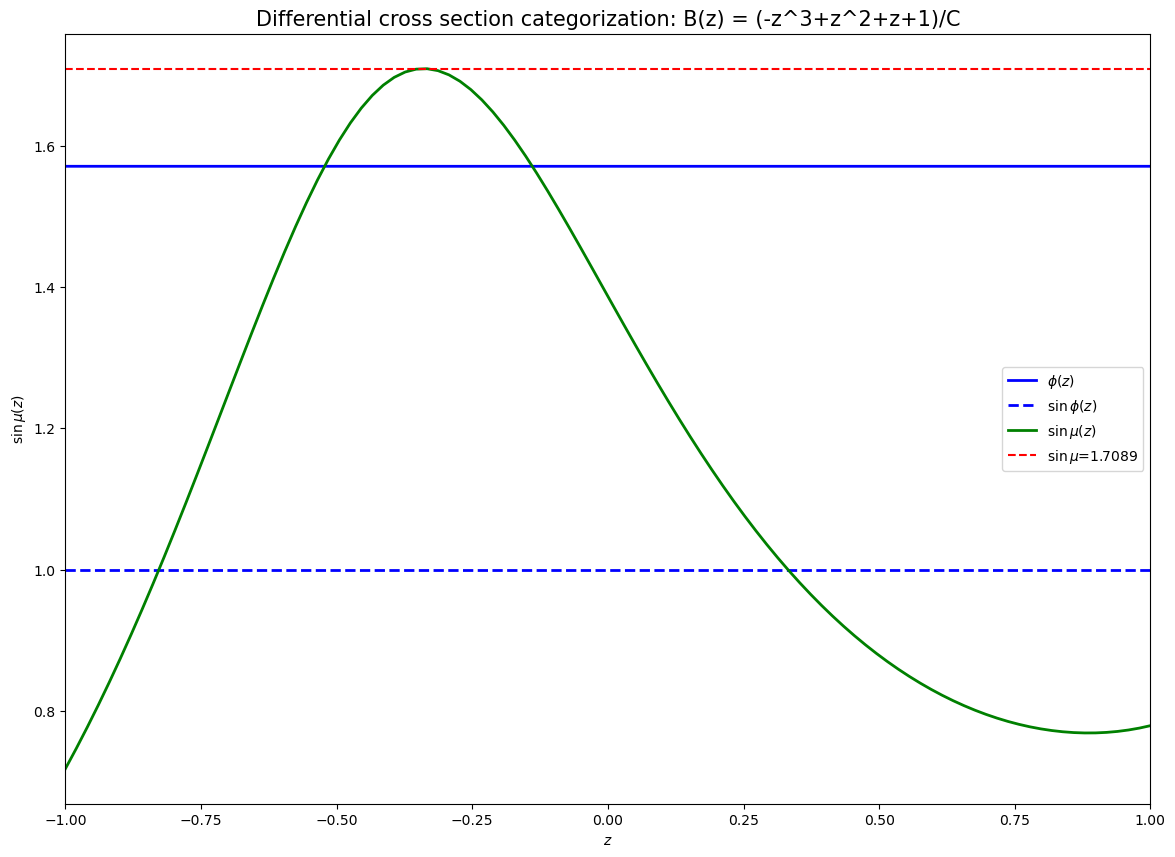

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 12 operations to synchronize with Neptune. Do not kill this process.
All 12 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-277
https://app.neptune.ai/zulap/2to2scattering/e/TOS-278
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5)

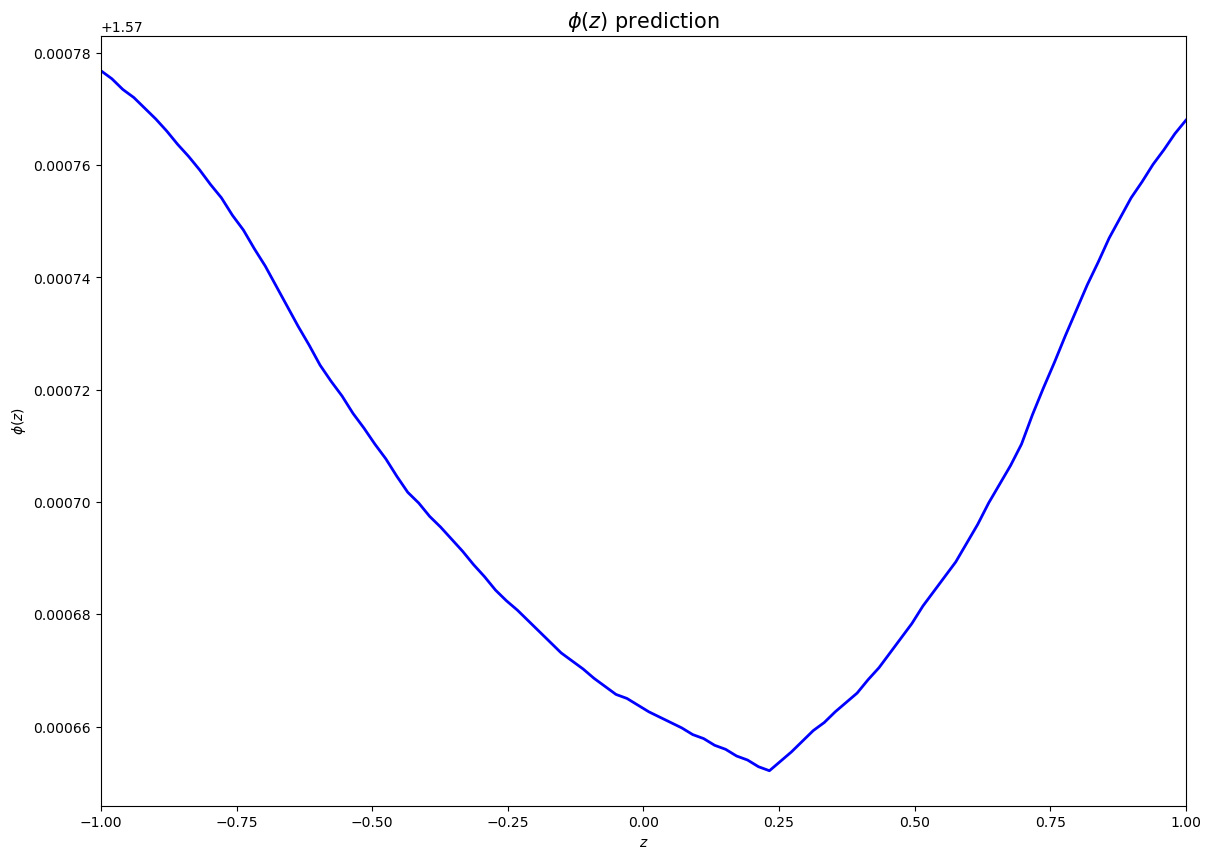

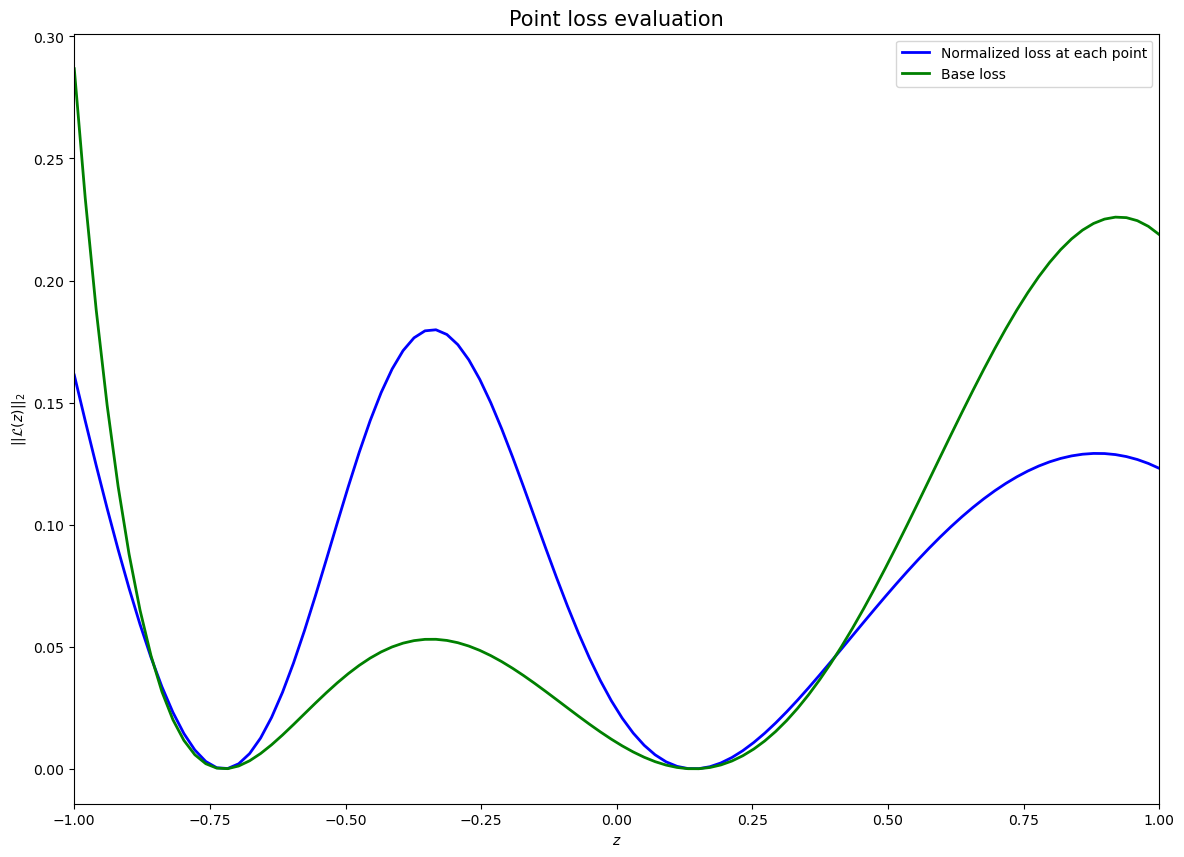

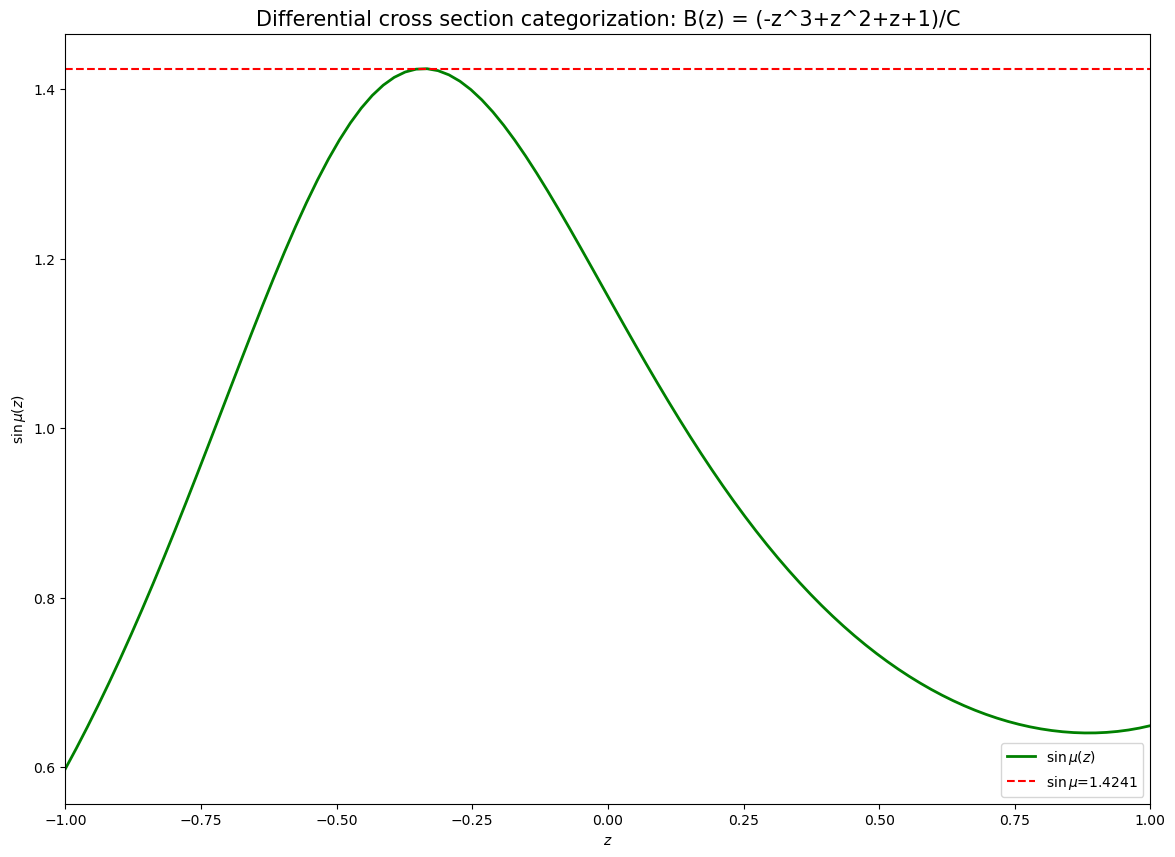

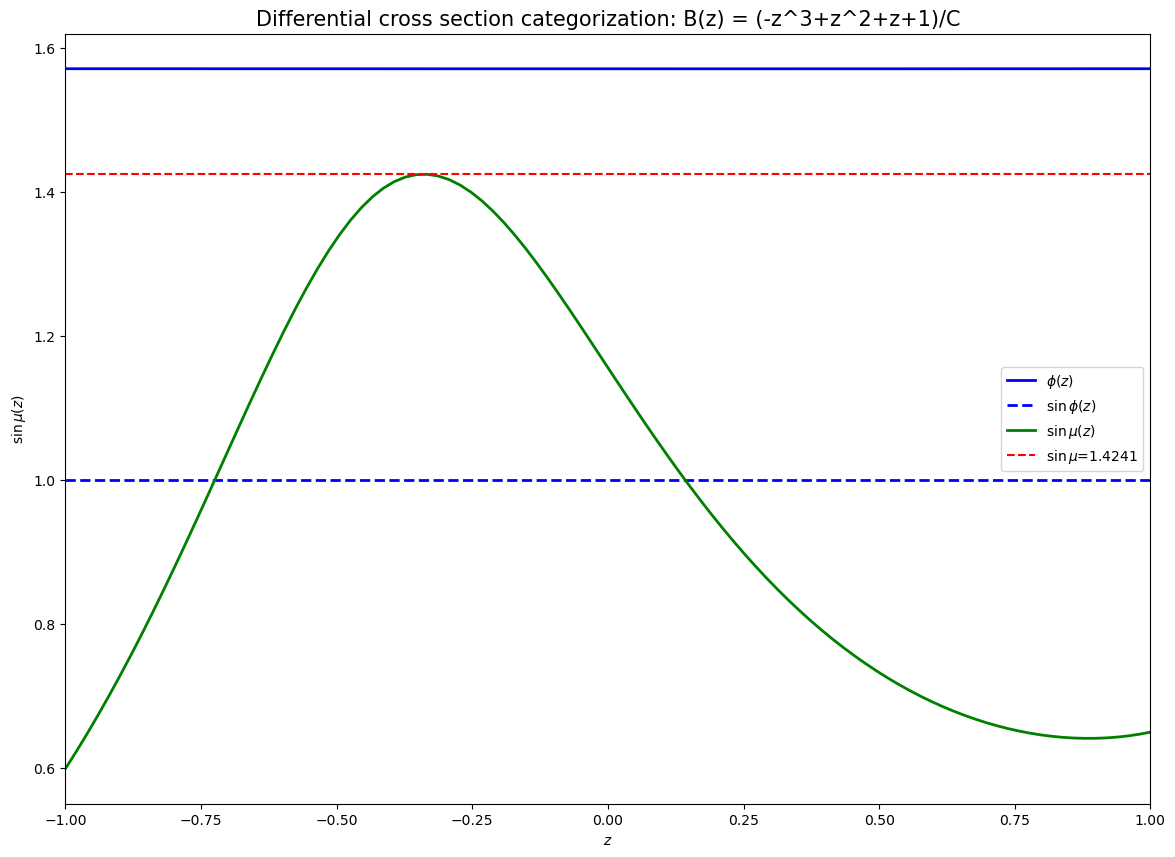

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 45 operations to synchronize with Neptune. Do not kill this process.
All 45 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-278
https://app.neptune.ai/zulap/2to2scattering/e/TOS-279
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5)

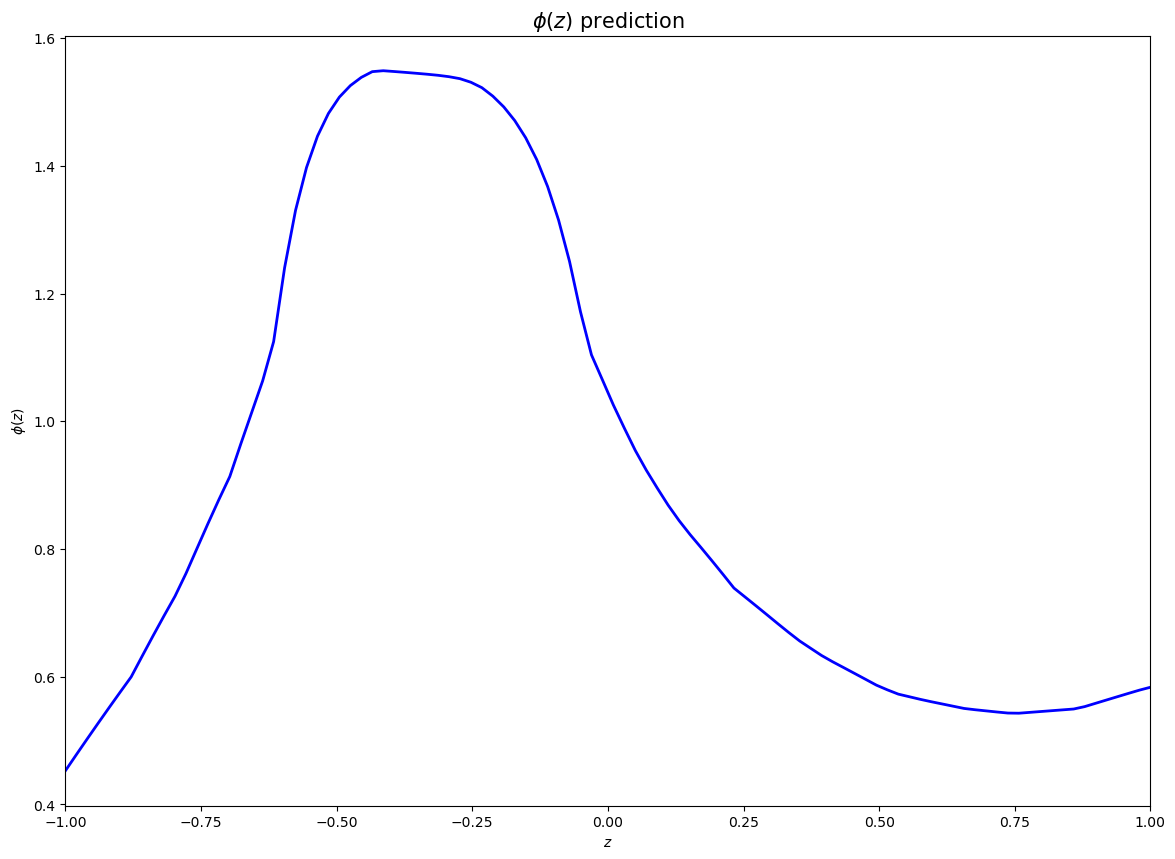

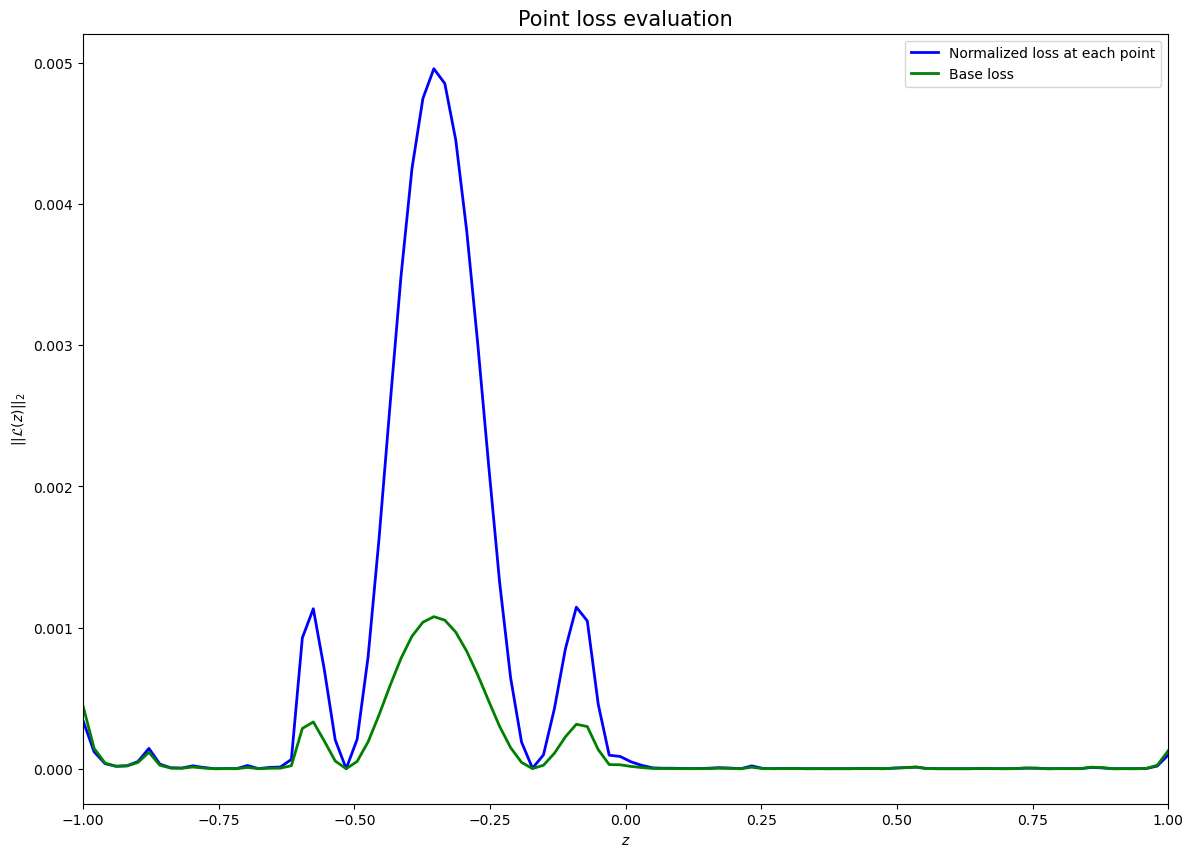

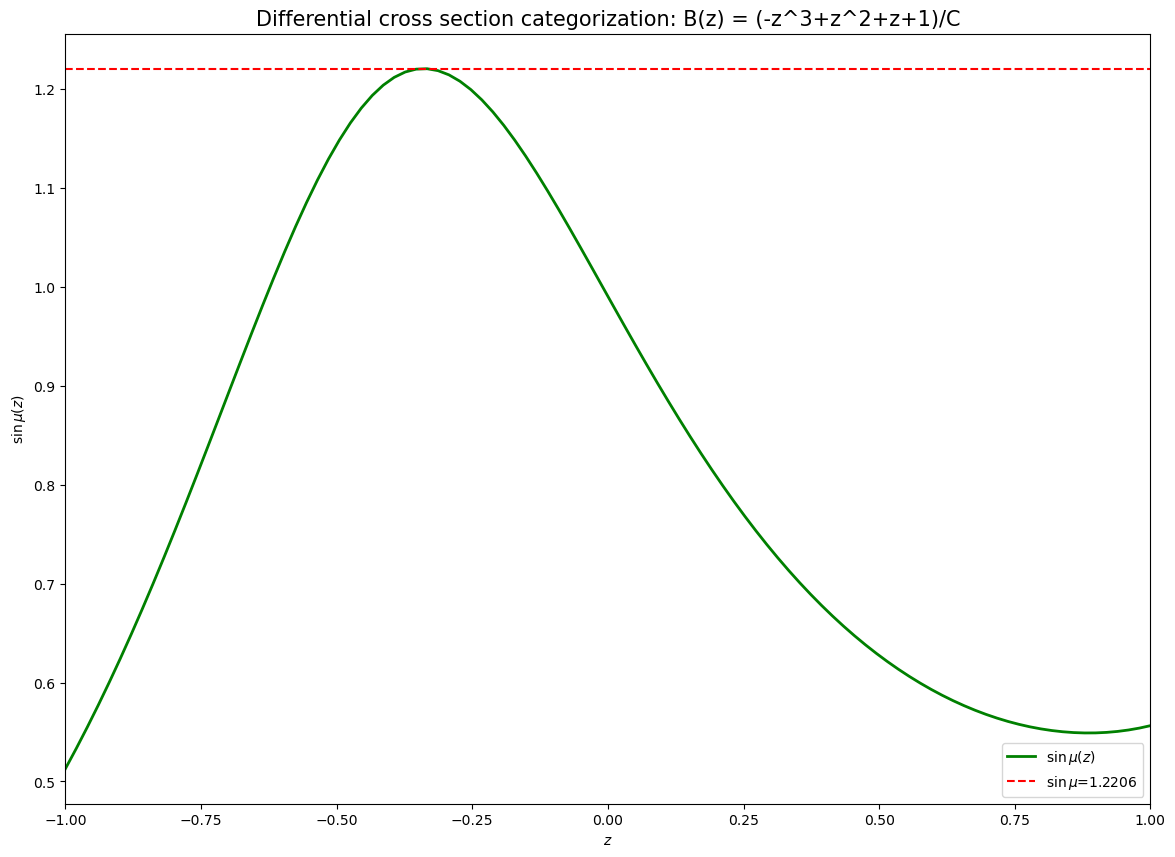

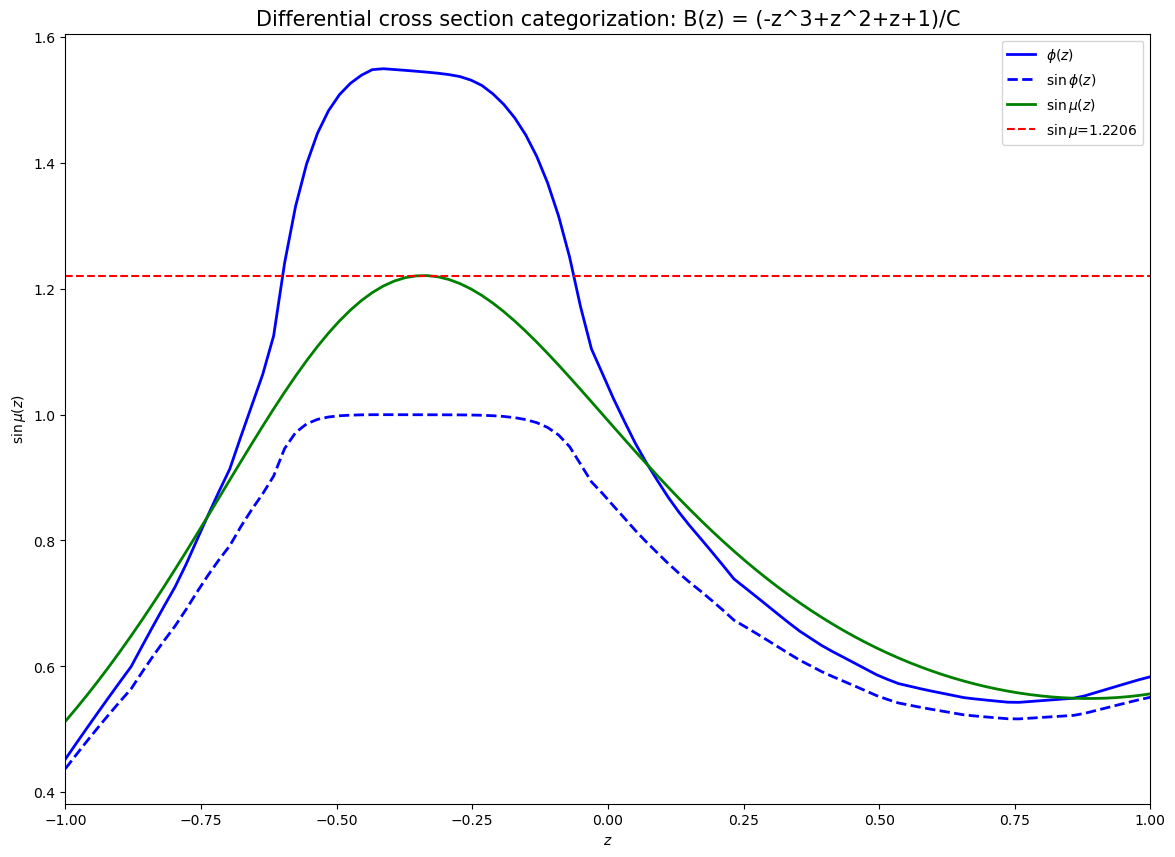

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 8 operations to synchronize with Neptune. Do not kill this process.
All 8 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-279
https://app.neptune.ai/zulap/2to2scattering/e/TOS-280
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): 

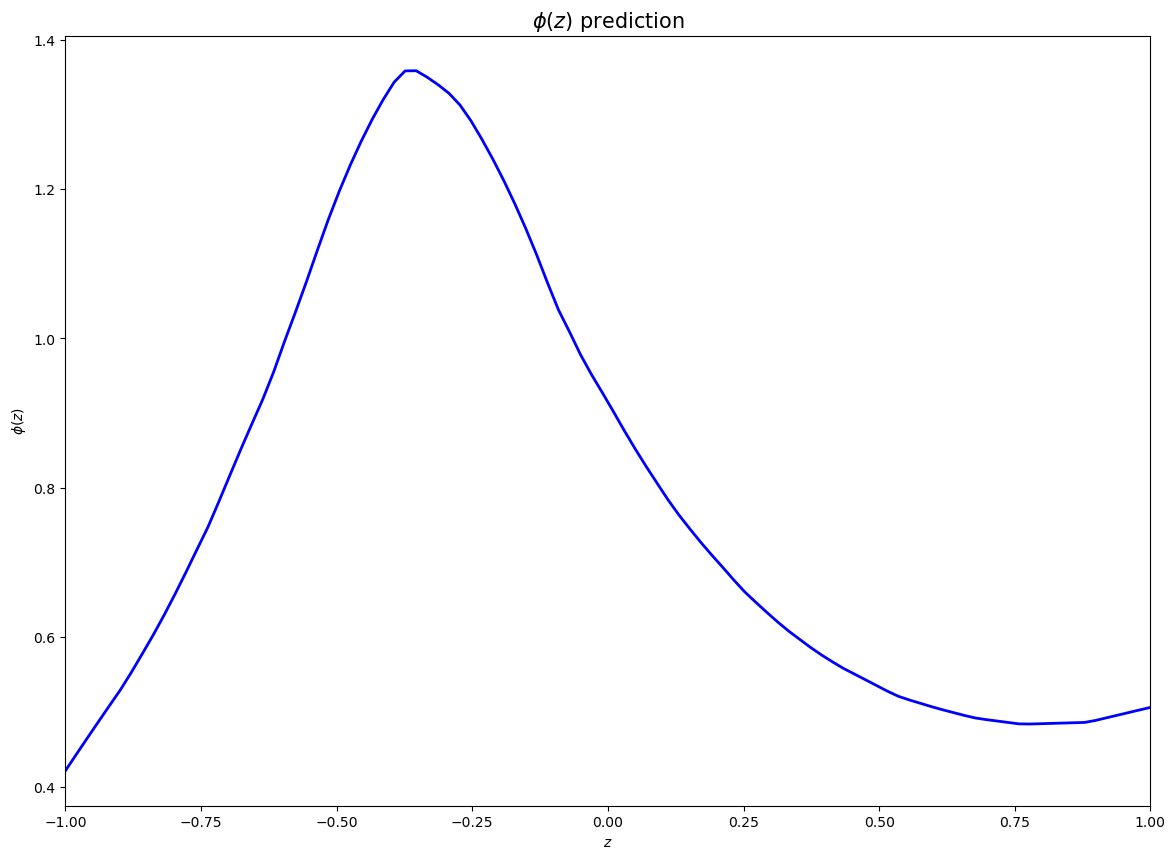

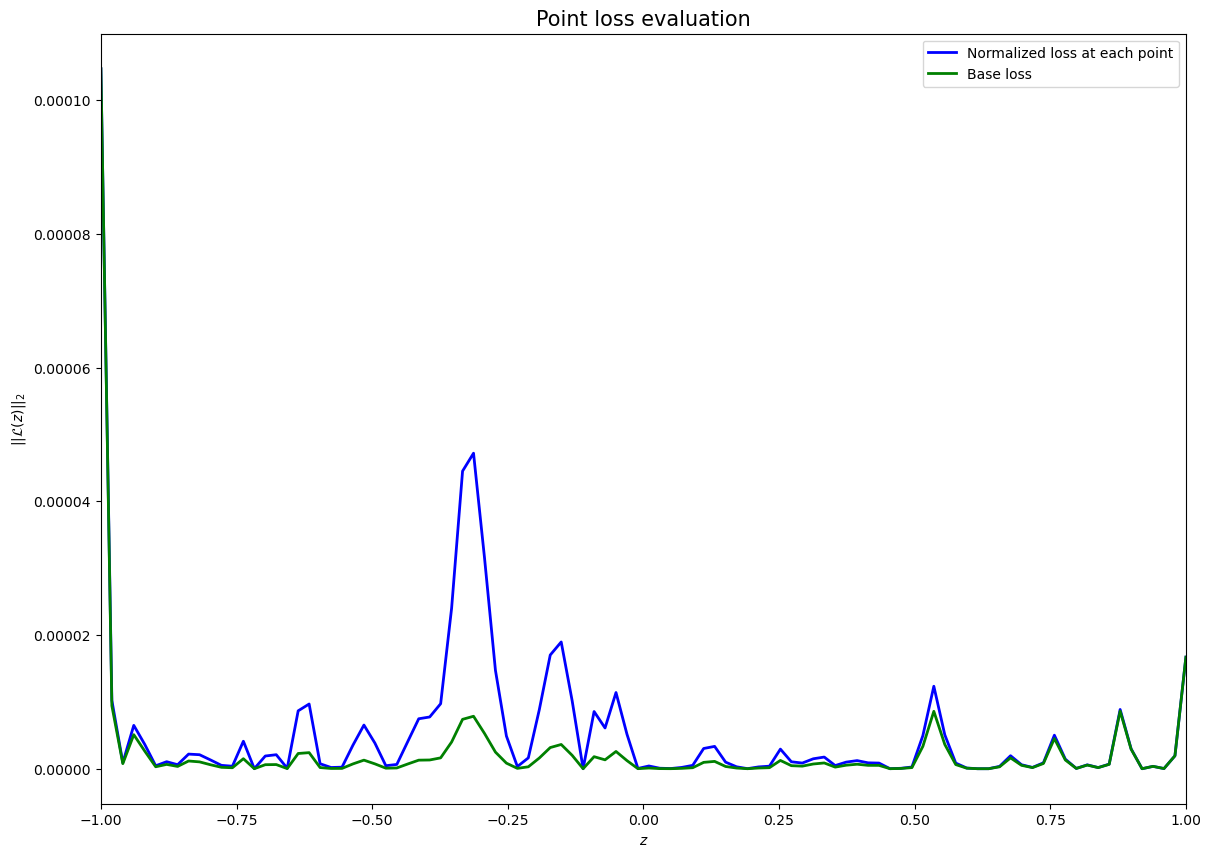

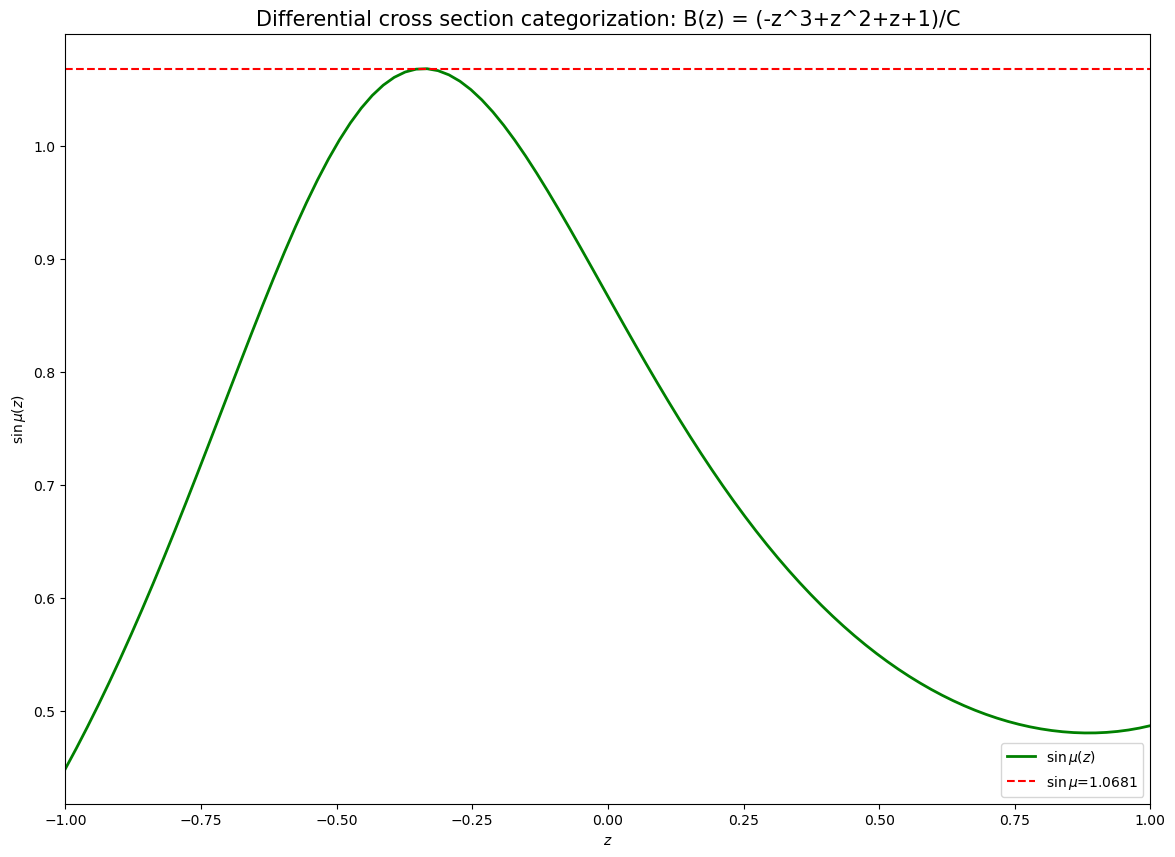

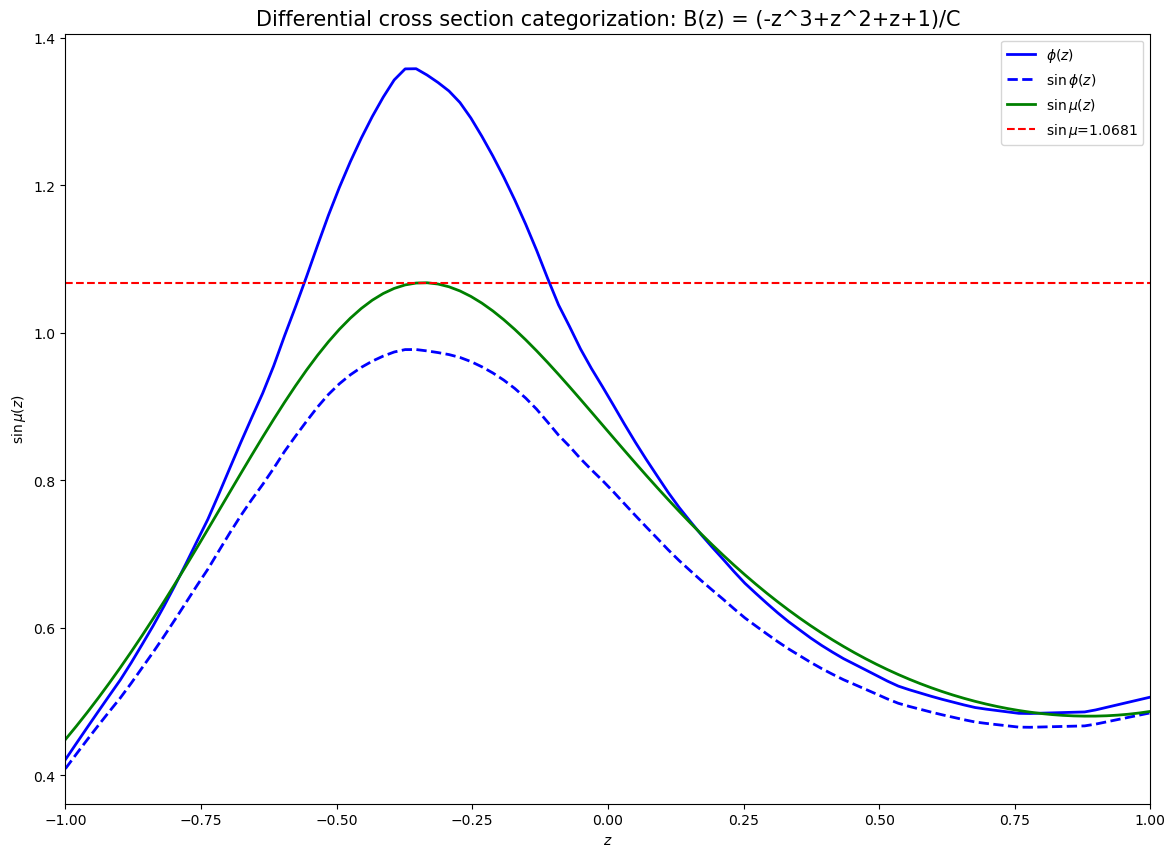

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 54 operations to synchronize with Neptune. Do not kill this process.
All 54 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-280
https://app.neptune.ai/zulap/2to2scattering/e/TOS-281
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5)

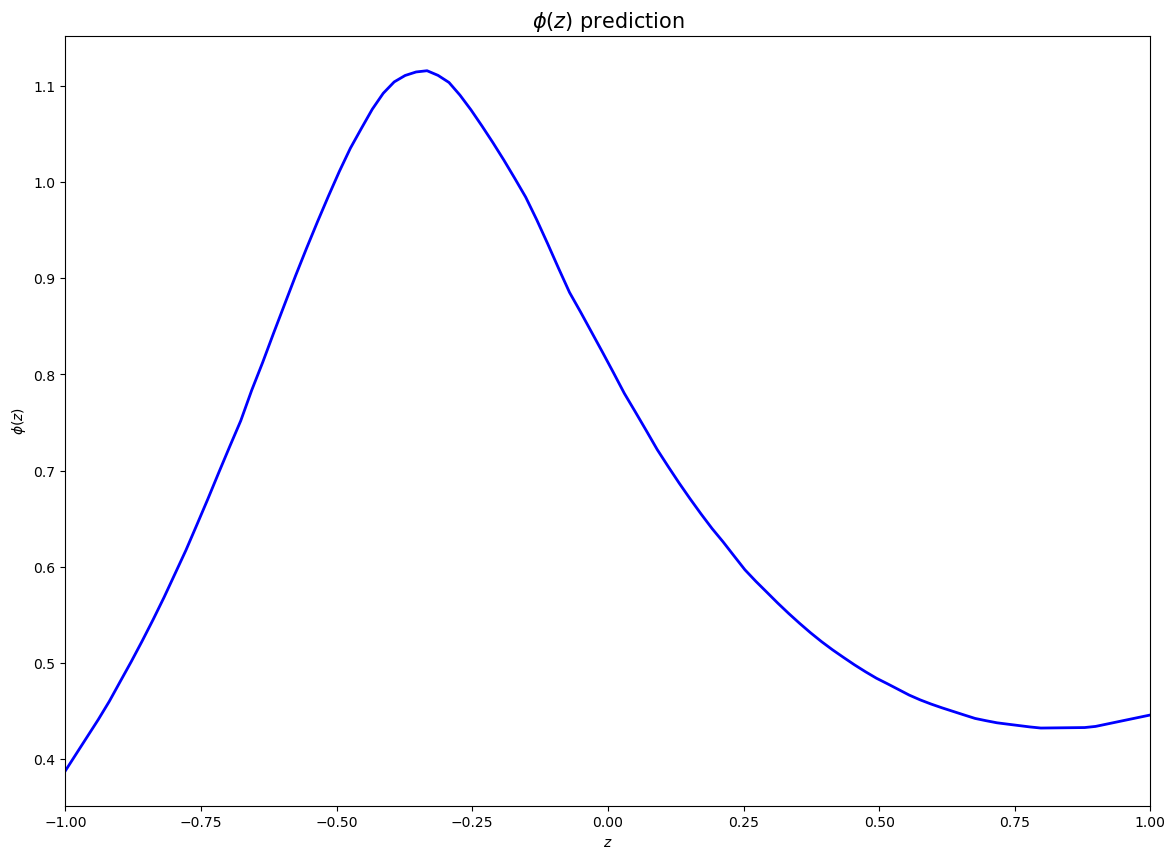

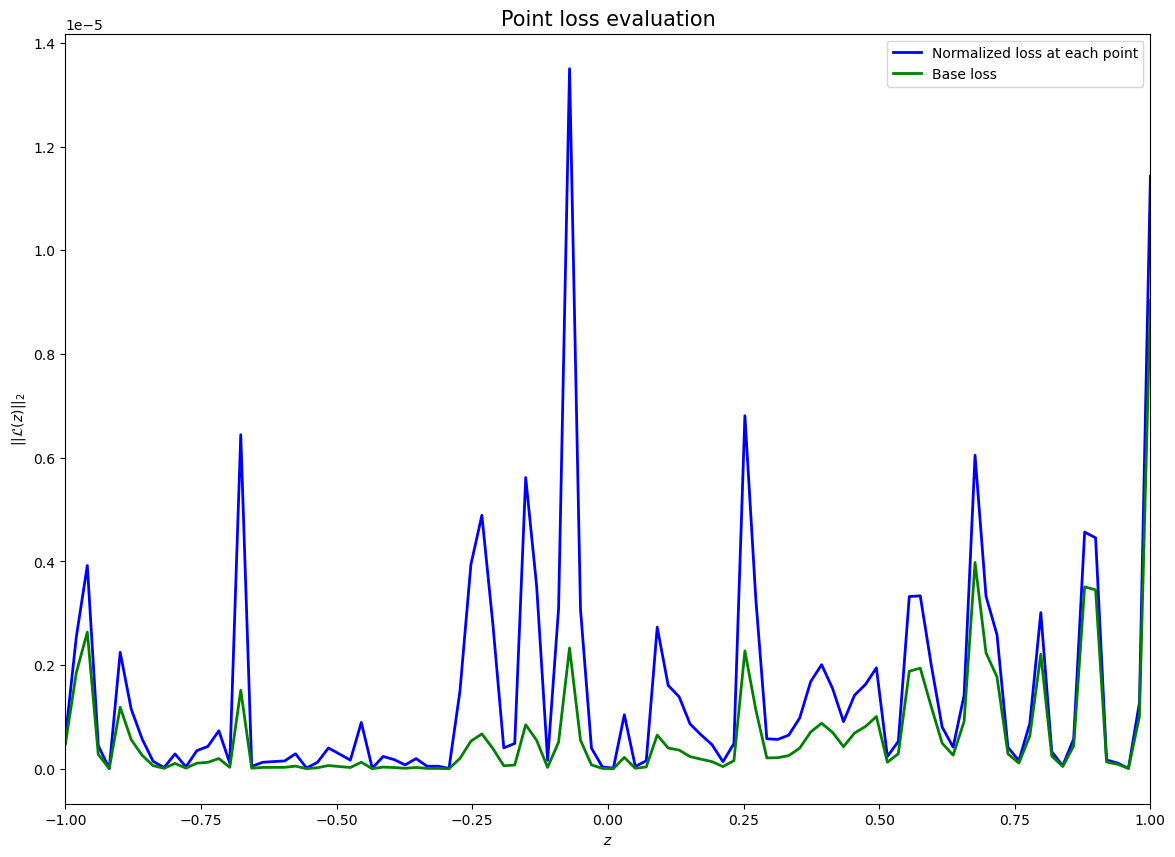

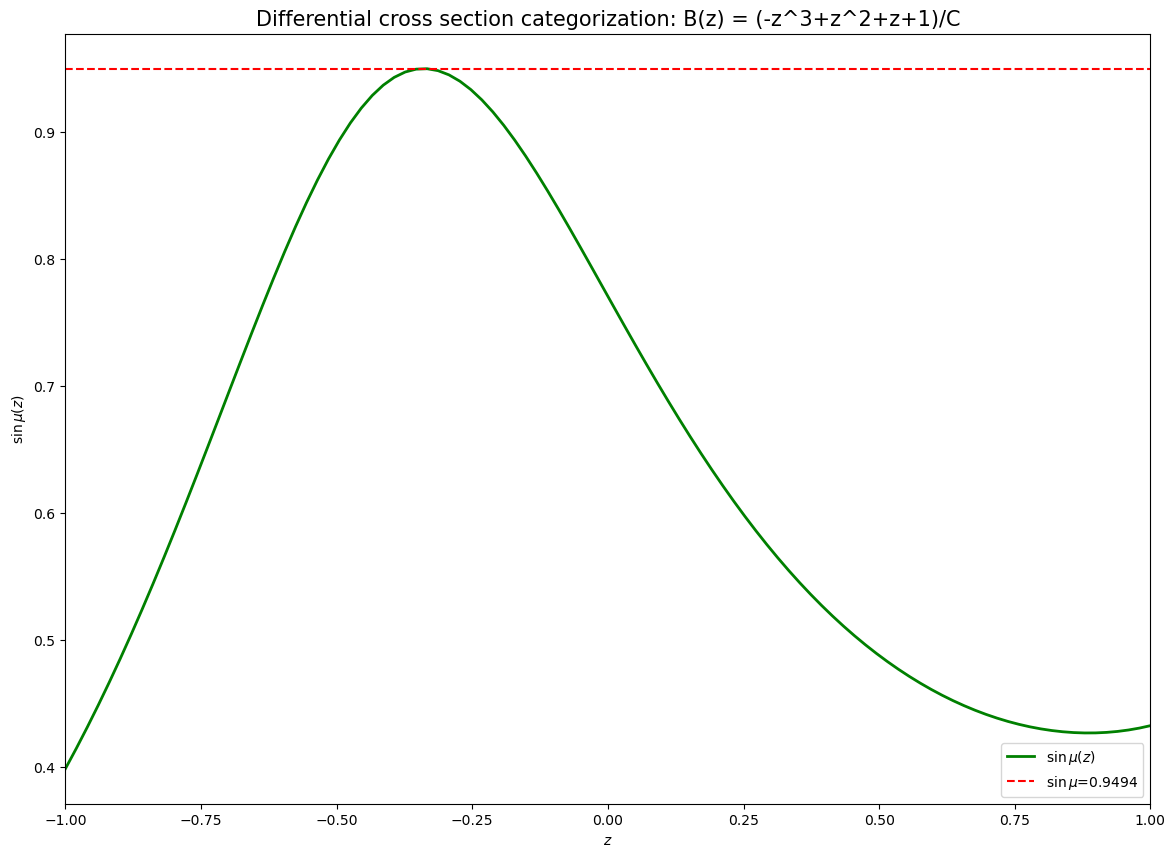

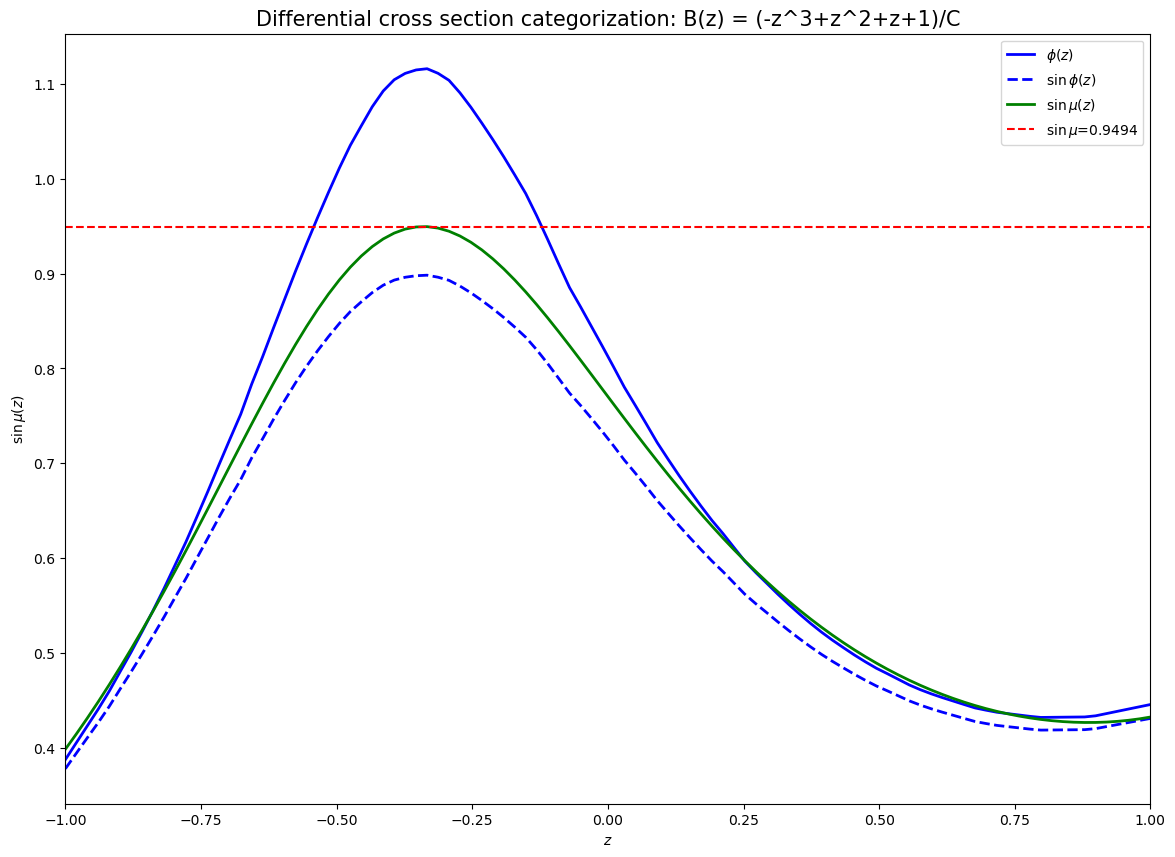

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 109 operations to synchronize with Neptune. Do not kill this process.
All 109 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-281
https://app.neptune.ai/zulap/2to2scattering/e/TOS-282
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_

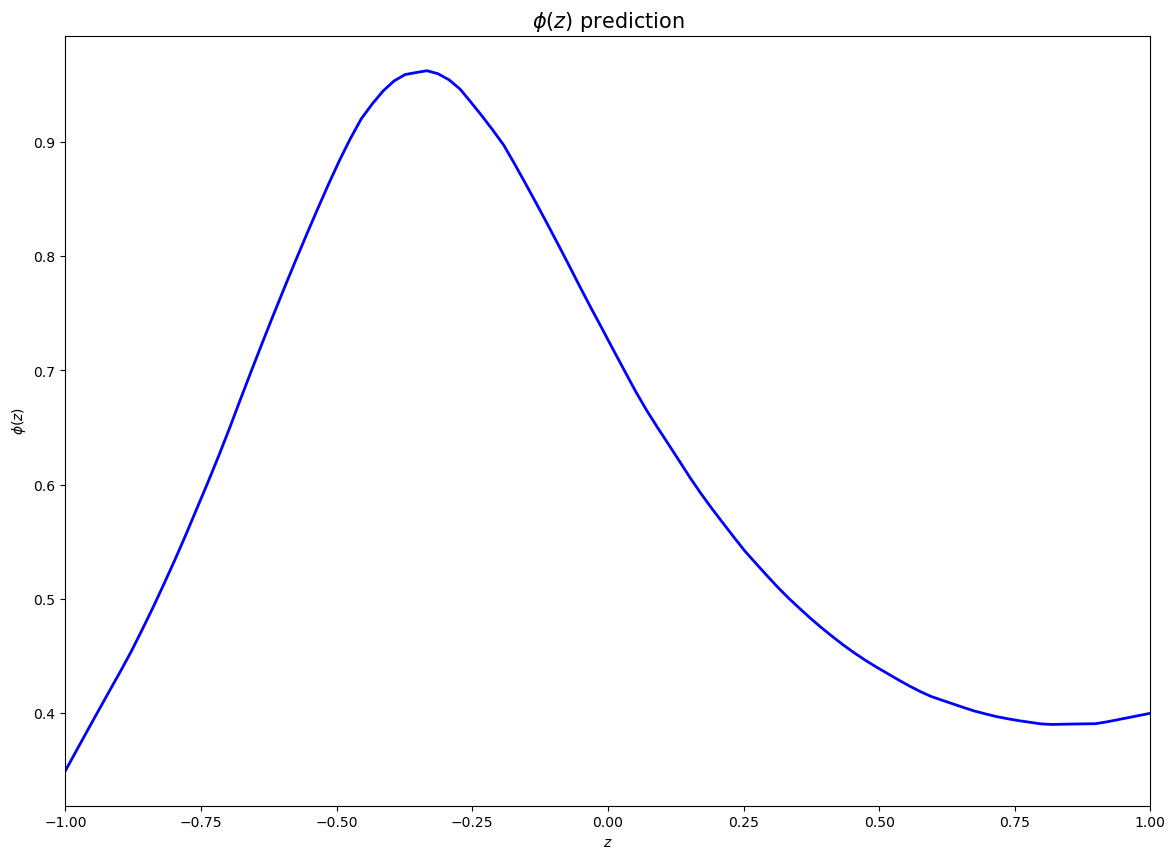

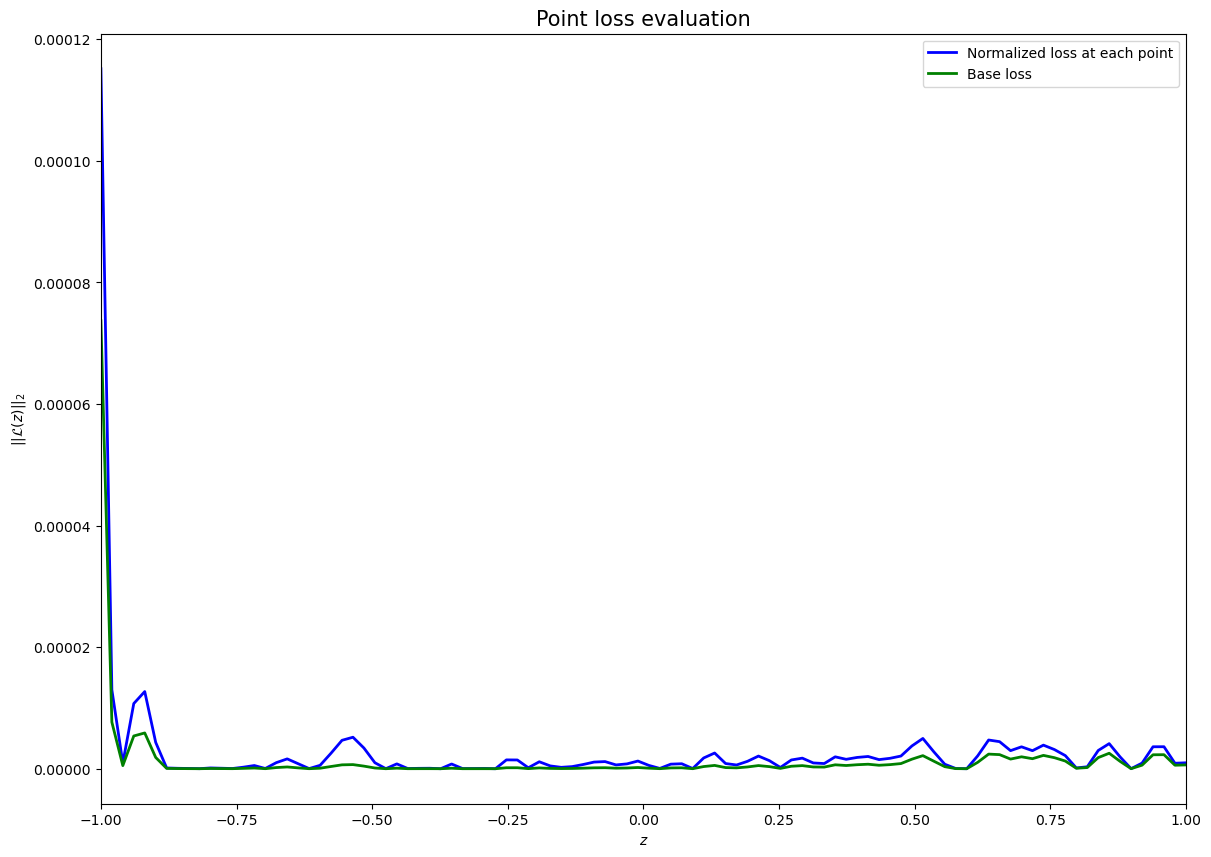

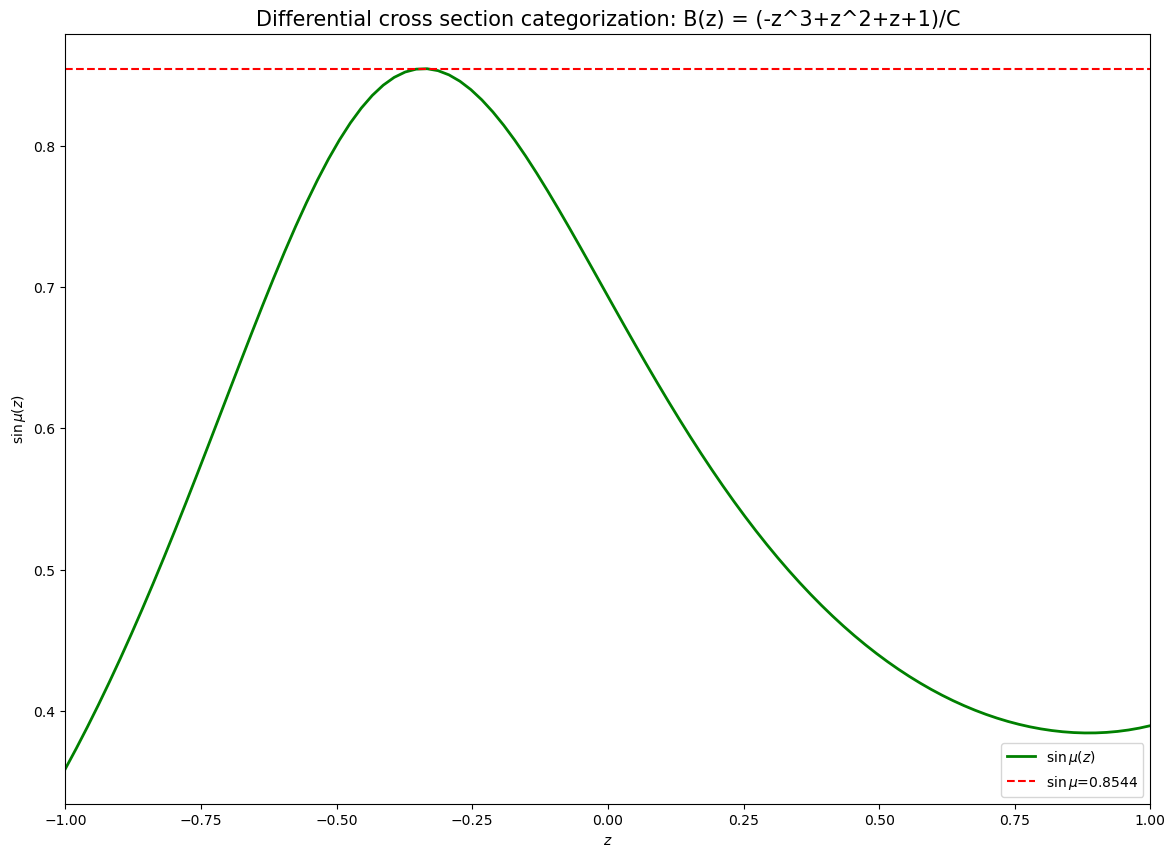

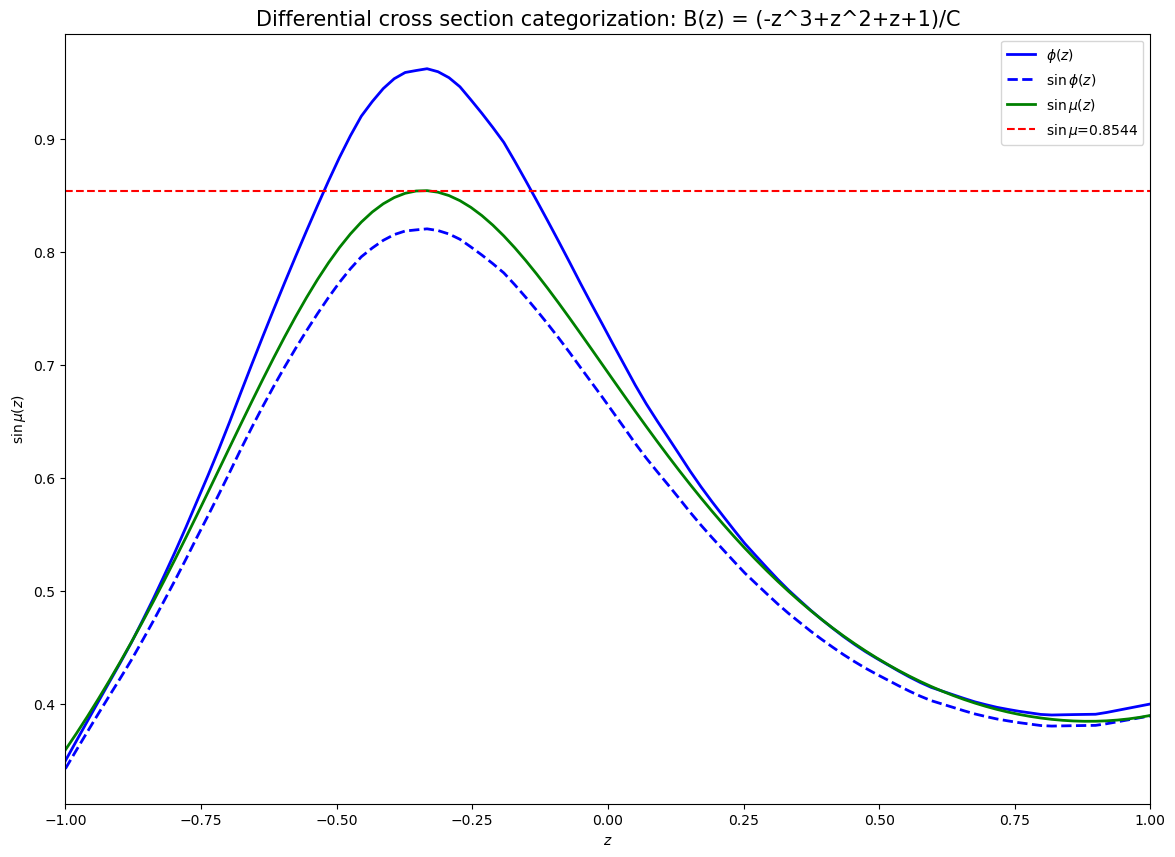

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 50 operations to synchronize with Neptune. Do not kill this process.
All 50 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-282
https://app.neptune.ai/zulap/2to2scattering/e/TOS-283
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5)

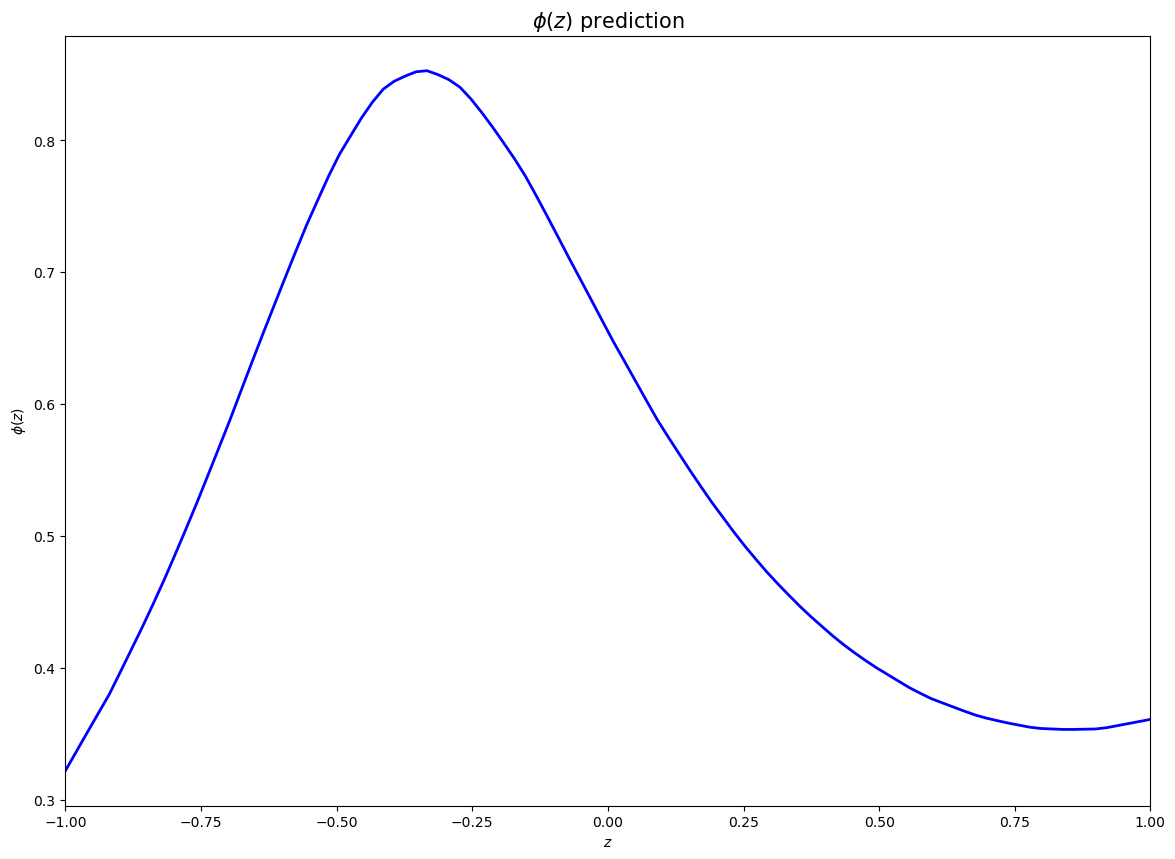

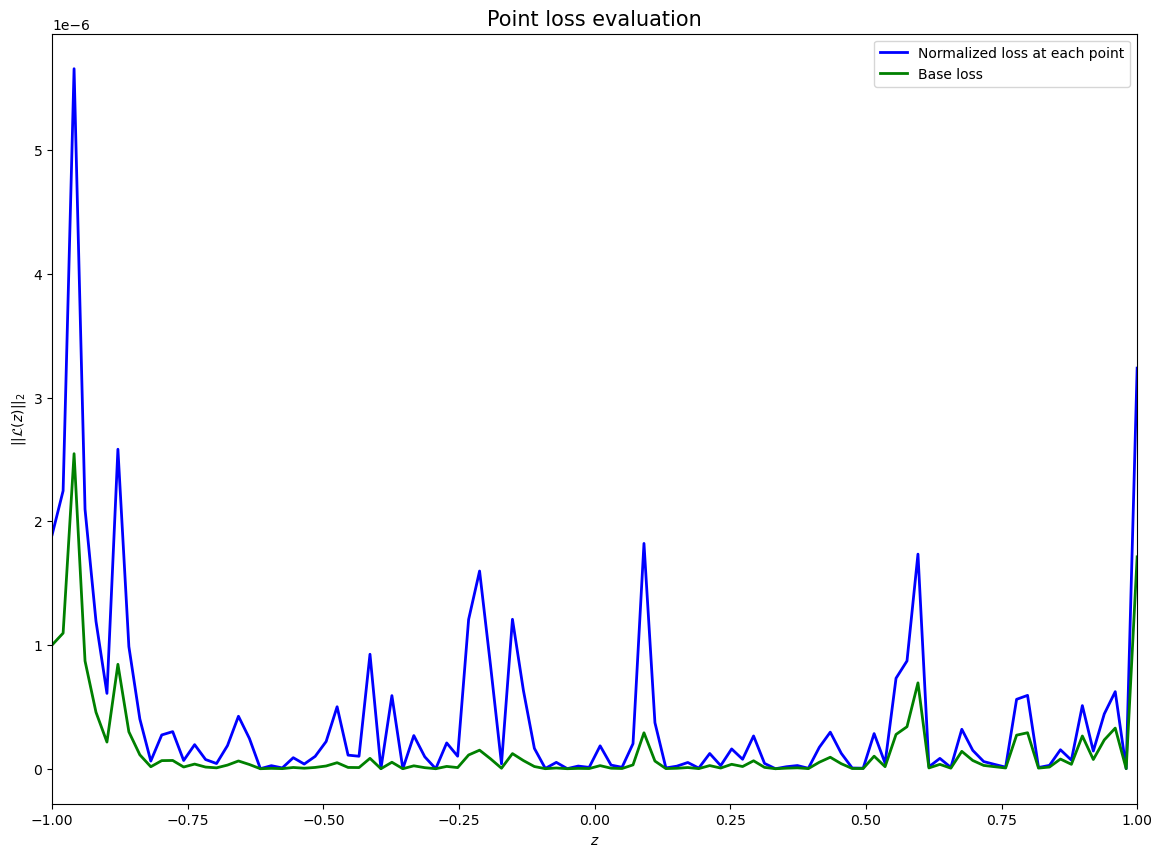

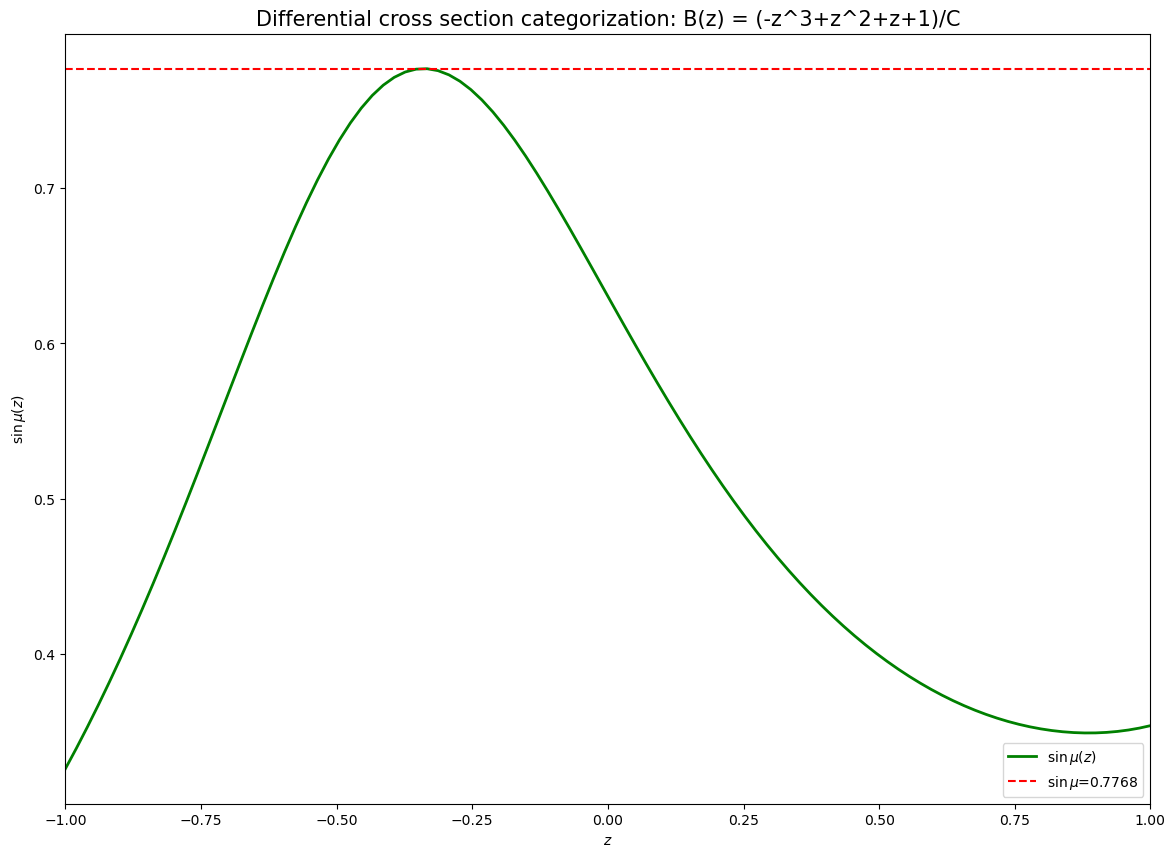

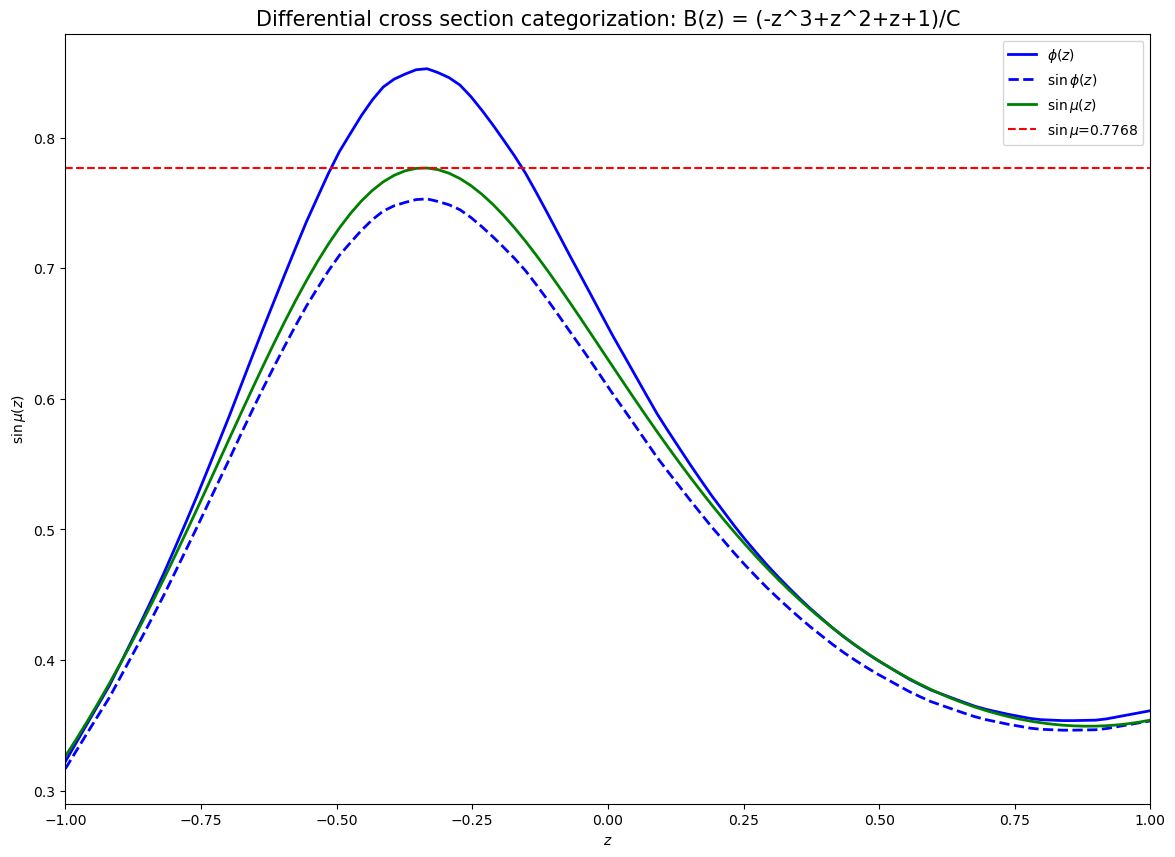

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-283
https://app.neptune.ai/zulap/2to2scattering/e/TOS-284
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): 

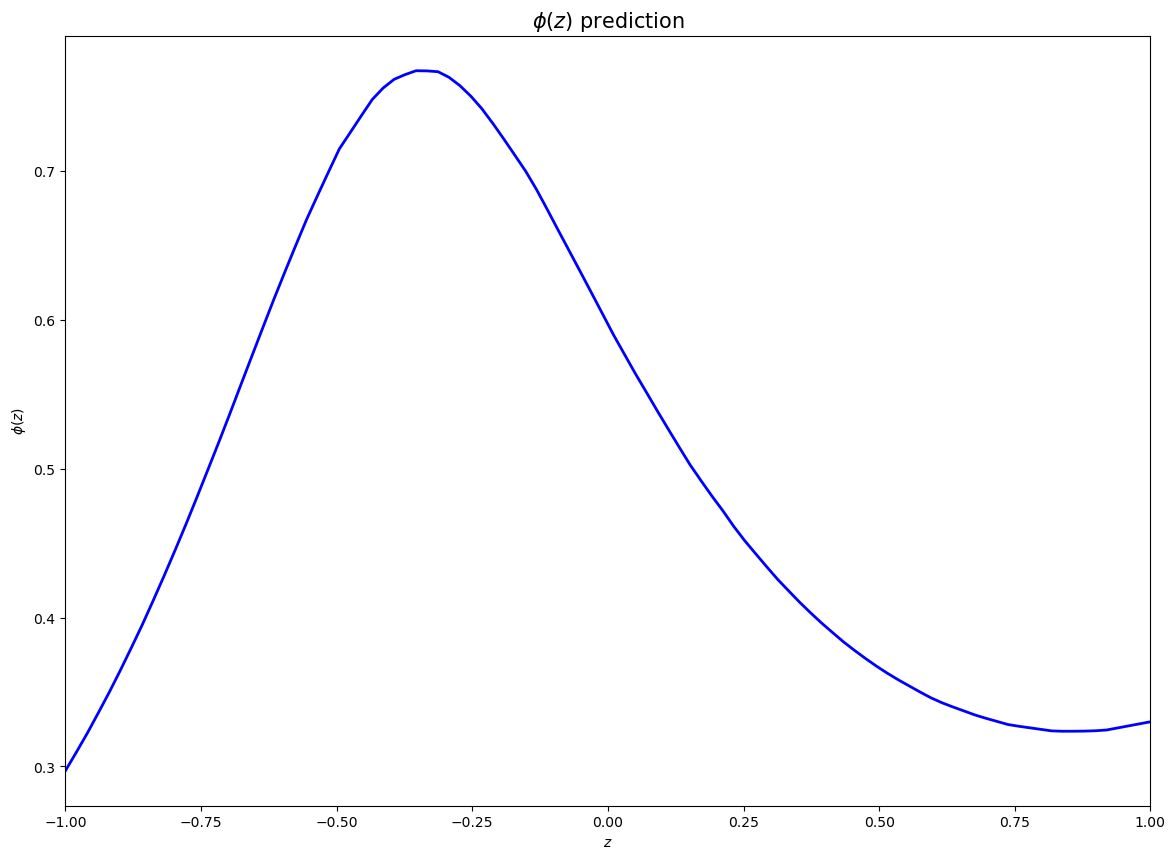

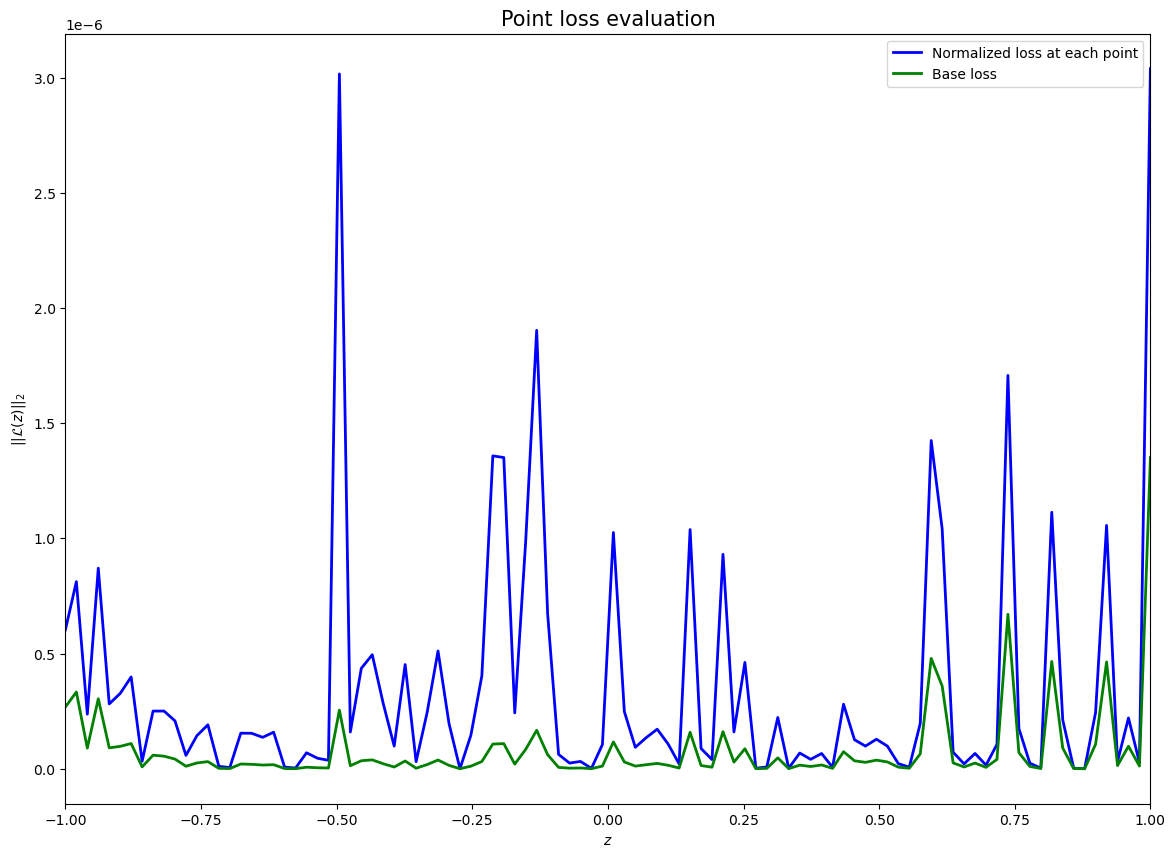

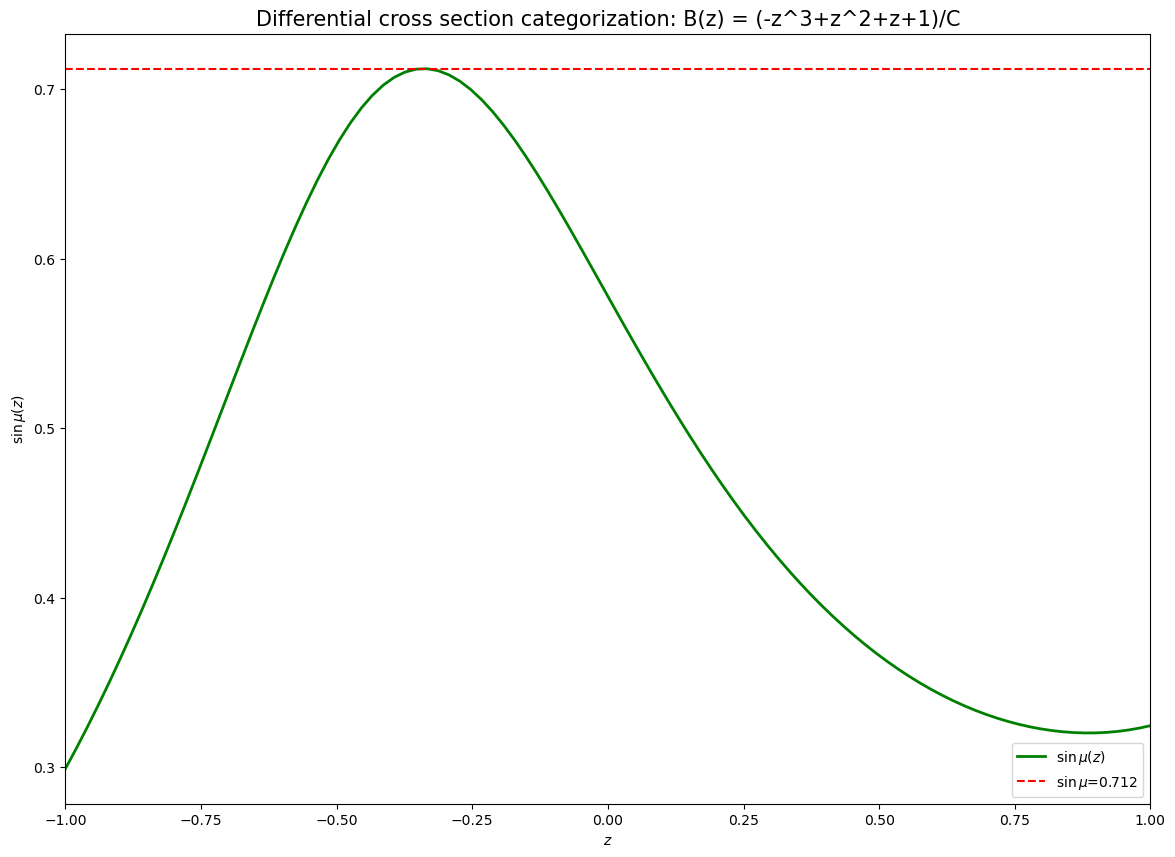

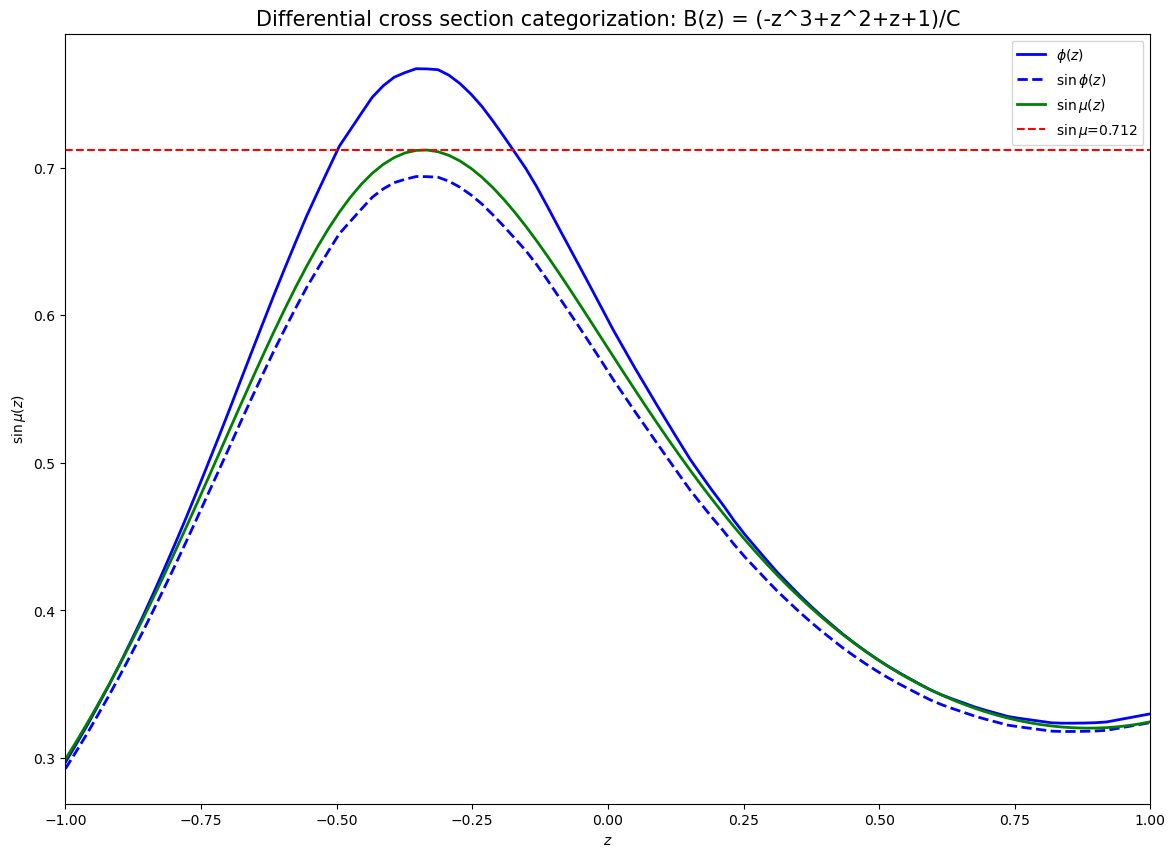

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 102 operations to synchronize with Neptune. Do not kill this process.
All 102 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-284


Exception in thread NeptuneWebhooks:
Traceback (most recent call last):
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/site-packages/websocket/_socket.py", line 108, in recv
    bytes_ = _recv()
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/site-packages/websocket/_socket.py", line 87, in _recv
Exception in thread NeptuneWebhooks:
Traceback (most recent call last):
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/site-packages/websocket/_socket.py", line 108, in recv
    return sock.recv(bufsize)
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/ssl.py", line 1227, in recv
    bytes_ = _recv()
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/site-packages/websocket/_socket.py", line 87, in _recv
    return sock.recv(bufsize)
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/ssl.py", line 1227, in recv
    return self.read(buflen)
  File "/Users/aurelien/miniforge3/

In [333]:
scan_range = np.linspace(1, 3, num=9)

for i, scan_param in enumerate(scan_range):

    run_scan = neptune.init_run(project=NEPTUNE_PROJECT, api_token=NEPTUNE_API_TOKEN, name="Run_ConstScan16_{}".format(i))


    params_scan = {'batch_size': 64,
             'epochs_num': 2500,
             'learning_rate': 0.001,
             'lr_scheduler': False, 
             'beta1' : 0.95,
             'beta2' : 0.999,
             'integral_points': 25,
             'method_int': 'trapz',
             'activation': 'ReLU',
             'layer_list': [64, 128, 128, 64],
             'loss': 'Huber',
             'scaled_loss': True,
             'scan_param': scan_param}

    tags_scan = {'constant function': '(-z^3+z^2+z+1)/C', 'optimizer': 'Adam', 'Mode': 'Scan param', 'Huber':0.1}
    run_scan["sys/tags"].add(list(tags_scan.values()))

    run_scan['parameters'] = params_scan
    
    netsolver = train_run(params_scan, device, run_scan)
    
    zpointseval, phieval, sinphieval, pt_loss_s, pt_loss_no_s = eval_run(netsolver, params_scan, device, run_scan)

    plot_phase(zpointseval, phieval, run_scan)
    plot_point_loss(zpointseval, pt_loss_s, pt_loss_no_s, run_scan)
    integralz = sin_mu_integral(params_scan, device, netsolver, zpointseval)
    plot_sin_mu(zpointseval, integralz, tags_scan)
    plot_summary(zpointseval, phieval, sinphieval, integralz, run_scan, tags_scan)
    
    # Make sure to kill the Neptune logger run
    run_scan.stop()

### Scan over linear functions

##### Assessing the existence

The idea here is to parametrize the differential cross section as $B(z)=az+b >0$ and map out the loss landscape. This will allow us to have a handle on the existence of a solution. We will tackle uniqueness later

In [651]:
class ModuleNetPolynomial(nn.Module):
    """
    Class for parametrizing the given differential cross section as a polynomial
    The input parameters correspond to the different weights of the polynomial
    """
    def __init__(self, polynomial_coeffs=None, device='cpu'):
        super(ModuleNetPolynomial, self).__init__()
        self.polynomial_coeffs = polynomial_coeffs
        self.device = device
        
    def forward(self, x):
        """
        Network forward pass is given by constructing the appropriate polynomial function
        """
        y = torch.zeros(x.size(), device=self.device)
        
        for i , coeff in enumerate(self.polynomial_coeffs):
            y = y + coeff * torch.pow(x, i)
        
        return y

In [652]:
def eval_run_scans(trained_solver, params, device, neptune_run, steps_eval=100):
    """
    At evaluation we verify if the integral equation is satisfied. 
    For this we take a larger sample of z points
    """
    
    # Make sure we are in evaluation mode
    trained_solver.phi_net.eval()
    with torch.no_grad(): 
        
        # Create the evaluation points and compute the phase at those points
        zpointstest = torch.linspace(-1,1,steps=steps_eval, device=device)
        
        # Also log the final loss values. Including the loss at individual z values
        eval_loss_scaled = trained_solver.loss_function(zpointstest, scaled=True, method_int=params['method_int'])
        neptune_run['metrics/eval_loss_scaled'].log(eval_loss_scaled)
        
        eval_loss_base = trained_solver.loss_function(zpointstest, scaled=False, method_int=params['method_int'])
        neptune_run['metrics/eval_loss_base'].log(eval_loss_base)
        
        # Look at sim mu value
        sinmu = max((sin_mu_integral(params, device, trained_solver, zpointstest)).cpu())

    return sinmu, eval_loss_scaled, eval_loss_base

In [697]:
def plot_contour_loss_curves_linear(log_results, neptune_run, log_type='natural', logging=True):
    # Plot the log of the loss
    if log_type == 'base10':
        loss_scale = np.log10(log_results['loss_scale'])
        loss_no_scale = np.log10(log_results['loss_no_scale'])
    elif log_type == 'natural':
        loss_scale = np.log(log_results['loss_scale'])
        loss_no_scale = np.log(log_results['loss_no_scale'])
    else:
        raise NotImplemented
        
    sin_mu = log_results['sinmu']
    
    min_a = min(log_res['params'][:,0])
    max_a = max(log_res['params'][:,0])
    min_b = min(log_res['params'][:,1])
    max_b = max(log_res['params'][:,1])
    
    fig = plt.figure(figsize=(14, 10))

    plt.imshow(loss_scale, extent=[min_b,max_b,min_a,max_a], cmap='jet')       
    plt.xlabel('$b$ parameter')
    plt.ylabel('$a$ parameter')    
    plt.title('Normalized loss lanscape of $B(z)=az+b$', fontsize = 15)
    plt.colorbar()
    plt.show()
    if logging:
        neptune_run[f'evaluation/contour_loss_scale'].upload(File.as_image(fig))
    plt.close(fig)
    
    fig2 = plt.figure(figsize=(14, 10))

    plt.imshow(loss_no_scale, extent=[min_b,max_b,min_a,max_a], cmap='jet')       
    plt.xlabel('$b$ parameter')
    plt.ylabel('$a$ parameter')    
    plt.title('Base loss lanscape of $B(z)=az+b$', fontsize = 15)
    plt.colorbar()
    plt.show()
    if logging:
        neptune_run[f'evaluation/contour_loss_no_scale'].upload(File.as_image(fig2))
    plt.close(fig2)
    
        
    fig3 = plt.figure(figsize=(14, 10))

    plt.imshow(sin_mu, extent=[min_b,max_b,min_a,max_a], cmap='jet', vmax=1.5)       
    plt.xlabel('$b$ parameter')
    plt.ylabel('$a$ parameter')    
    plt.title('$\sin \mu$ value of $B(z)=az+b$', fontsize = 15)
    plt.colorbar()
    plt.show()
    if logging:
        neptune_run[f'evaluation/contour_sinmu'].upload(File.as_image(fig3))
    plt.close(fig3)

In [732]:
def plot_sinmu_losses(log_results, neptune_run, log_type='natural', logging=True):
    
    sin_mu = log_results['sinmu'].flatten()
    
    if log_type == 'base10':
        loss_scalef = np.log10(log_results['loss_scale']).flatten()
        loss_no_scalef = np.log10(log_results['loss_no_scale']).flatten()
        sin_muf = np.log10(log_results['sinmu'].flatten())
        add_str = '10'
    elif log_type == 'natural':
        loss_scalef = np.log(log_results['loss_scale']).flatten()
        loss_no_scalef = np.log(log_results['loss_no_scale']).flatten()
        sin_muf = np.log(log_results['sinmu'].flatten())
        add_str = ''
    else:
        raise NotImplemented

    fig = plt.figure(figsize=(14, 10))

    plt.scatter(sin_muf, loss_scalef, c='b')       
    plt.xlabel('$\log_{{{}}}(\sin \mu)$ parameter'.format(add_str))
    plt.ylabel('Log{} loss'.format(add_str))    
    plt.title('Normalized loss lanscape of $B(z)=az+b$', fontsize = 15)
    plt.show()
    if logging:
        neptune_run[f'evaluation/sinmu_loss_scale'].upload(File.as_image(fig))
    plt.close(fig)
    
    fig2 = plt.figure(figsize=(14, 10))

    plt.scatter(sin_muf, loss_no_scalef, c='g')       
    plt.xlabel('$\log_{{{}}}(\sin \mu)$ parameter'.format(add_str))
    plt.ylabel('Log{} loss'.format(add_str))    
    plt.title('Base loss lanscape of $B(z)=az+b$', fontsize = 15)
    plt.show()
    if logging:
        neptune_run[f'evaluation/sinmu_loss_no_scale'].upload(File.as_image(fig2))
    plt.close(fig2)
    
    
    
    fig3 = plt.figure(figsize=(14, 10))

    plt.scatter(sin_mu, loss_scalef, c='b')       
    plt.xlabel('$\sin \mu$ parameter')
    plt.ylabel('Log{} loss'.format(add_str))    
    plt.xlim([0,3])
    plt.title('Normalized loss lanscape of $B(z)=az+b$', fontsize = 15)
    plt.show()
    if logging:
        neptune_run[f'evaluation/sinmu_loss_scale_r'].upload(File.as_image(fig3))
    plt.close(fig3)
    
    fig4 = plt.figure(figsize=(14, 10))

    plt.scatter(sin_mu, loss_no_scalef, c='g')       
    plt.xlabel('$\sin \mu$ parameter')
    plt.ylabel('Log{} loss'.format(add_str))    
    plt.xlim([0,3])
    plt.title('Base loss lanscape of $B(z)=az+b$', fontsize = 15)
    plt.show()
    if logging:
        neptune_run[f'evaluation/sinmu_loss_no_scale_r'].upload(File.as_image(fig4))
    plt.close(fig4)
    

In [721]:
num_a = 30
num_b = 30

scan_range_a = np.linspace(-0.5, 0.5, num=num_a)
scan_range_b = np.linspace(0, 1.25, num=num_b)
param_grid = np.dstack(np.meshgrid(scan_range_a, scan_range_b)).reshape(-1, 2)



run_scan = neptune.init_run(project=NEPTUNE_PROJECT, api_token=NEPTUNE_API_TOKEN, name="Run_LinScan2_{}".format(i))

log_res = {'params':param_grid, 'sinmu':np.empty([num_a, num_b]), 'loss_scale':np.empty([num_a, num_b]), 'loss_no_scale':np.empty([num_a, num_b])}

for i, params_lin in enumerate(param_grid):
    
    a_index = i % num_a
    b_index = int((i - i % num_a)/num_a)
    
    # Ensure that the differential cross section is positive for all z values
    if params_lin[1] > abs(params_lin[0]):
        print('Starting the simulation with a={} and b={}'.format(params_lin[0],params_lin[1]))

        params_scan = {'batch_size': 64,
                 'epochs_num': 300,
                 'learning_rate': 0.001,
                 'lr_scheduler': False, 
                 'beta1' : 0.85,
                 'beta2' : 0.999,
                 'integral_points': 25,
                 'method_int': 'trapz',
                 'activation': 'ReLU',
                 'layer_list': [64, 128, 128, 64],
                 'loss': 'Huber',
                 'scaled_loss': True,
                 'scan_param': None}

        tags_scan = {'constant function': 'az+b', 'optimizer': 'Adam', 'Mode': 'Scan param linear'}
        run_scan["sys/tags"].add(list(tags_scan.values()))

        run_scan['parameters'] = params_scan
        
        
        modnet = ModuleNetPolynomial(polynomial_coeffs=np.flip(params_lin), device=device)
        netsolver = train_run(params_scan, device, run_scan, module_net=modnet)

        sinmu, loss_scale, loss_no_scale = eval_run_scans(netsolver, params_scan, device, run_scan)
        log_res['sinmu'][a_index, b_index] = sinmu.cpu().numpy()
        log_res['loss_scale'][a_index, b_index] = loss_scale.cpu().numpy()
        log_res['loss_no_scale'][a_index, b_index] = loss_no_scale.cpu().numpy()
    else:
        log_res['sinmu'][a_index, b_index] = np.nan
        log_res['loss_scale'][a_index, b_index] = np.nan
        log_res['loss_no_scale'][a_index, b_index] = np.nan

https://app.neptune.ai/zulap/2to2scattering/e/TOS-316
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Starting the simulation with a=-0.017241379310344862 and b=0.04310344827586207
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.060592
Train Epoch: 15 ; tLoss: 0.000182
Train Epoch: 30 ; tLoss: 0.000402
Train Epoch: 45 ; tLoss: 0.000077


Train Epoch: 15 ; tLoss: 0.032592
Train Epoch: 30 ; tLoss: 0.009595
Train Epoch: 45 ; tLoss: 0.002923
Train Epoch: 60 ; tLoss: 0.021970
Train Epoch: 75 ; tLoss: 0.001747
Train Epoch: 90 ; tLoss: 0.037746
Train Epoch: 105 ; tLoss: 0.005996
Train Epoch: 120 ; tLoss: 0.011896
Train Epoch: 135 ; tLoss: 0.003588
Train Epoch: 150 ; tLoss: 0.327196
Train Epoch: 165 ; tLoss: 0.013706
Train Epoch: 180 ; tLoss: 0.002354
Train Epoch: 195 ; tLoss: 0.022037
Train Epoch: 210 ; tLoss: 0.242369
Train Epoch: 225 ; tLoss: 0.001024
Train Epoch: 240 ; tLoss: 0.039908
Train Epoch: 255 ; tLoss: 0.022442
Train Epoch: 270 ; tLoss: 0.013155
Train Epoch: 285 ; tLoss: 0.010924
Starting the simulation with a=-0.12068965517241381 and b=0.12931034482758622
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(i

Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute metrics/eval_loss_scaled


Train Epoch: 90 ; tLoss: 0.009559
Train Epoch: 105 ; tLoss: 0.006056
Train Epoch: 120 ; tLoss: 0.003158
Train Epoch: 135 ; tLoss: 0.005199
Train Epoch: 150 ; tLoss: 0.004257
Train Epoch: 165 ; tLoss: 0.001927
Train Epoch: 180 ; tLoss: 0.001324
Train Epoch: 195 ; tLoss: 0.001916
Train Epoch: 210 ; tLoss: 0.004669
Train Epoch: 225 ; tLoss: 0.005698
Train Epoch: 240 ; tLoss: 0.001979
Train Epoch: 255 ; tLoss: 0.003050
Train Epoch: 270 ; tLoss: 0.003903
Train Epoch: 285 ; tLoss: 0.005365
Starting the simulation with a=-0.08620689655172414 and b=0.12931034482758622
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    

Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.12068965517241381 and b=0.12931034482758622
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.054555
Train Epoch: 15 ; tLoss: 0.011333
Train Epoch: 30 ; tLoss: 0.004638
Train Epoch: 45 ; tLoss: 0.001426
Train Epoch: 60 ; tLoss: 0.003965
Train Epoch: 75 ; tLoss: 0.000512
Train Epoch: 90 ; tLoss: 0.005027
Train Epoch: 105 ; tLoss: 0.001618
Train Epoch: 120 ; tLoss: 0.001714
Train Epoch: 135 ; tLoss: 0.000827
Train Epoch: 150 ; tL

Train Epoch: 15 ; tLoss: 0.000875
Train Epoch: 30 ; tLoss: 0.000042
Train Epoch: 45 ; tLoss: 0.000002
Train Epoch: 60 ; tLoss: 0.000001
Train Epoch: 75 ; tLoss: 0.000000
Train Epoch: 90 ; tLoss: 0.000001
Train Epoch: 105 ; tLoss: 0.000000
Train Epoch: 120 ; tLoss: 0.000000
Train Epoch: 135 ; tLoss: 0.000000
Train Epoch: 150 ; tLoss: 0.000000
Train Epoch: 165 ; tLoss: 0.000000
Train Epoch: 180 ; tLoss: 0.000000
Train Epoch: 195 ; tLoss: 0.000000
Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.051724137931034475 and b=0.1724137931034483
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.000042
Train Epoch: 225 ; tLoss: 0.000104
Train Epoch: 240 ; tLoss: 0.000046
Train Epoch: 255 ; tLoss: 0.000034
Train Epoch: 270 ; tLoss: 0.000059
Train Epoch: 285 ; tLoss: 0.000062
Starting the simulation with a=-0.12068965517241381 and b=0.21551724137931036
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.086075
Train Epoch: 15 ; tLoss: 0.002586
Train Epoch: 30 ; tLoss: 0.000690
Train Epoch: 45 ; tLoss: 0.000164
Train Epoch: 60 ; tLoss: 0.000094
Train Epoch: 75 ; 

Train Epoch: 15 ; tLoss: 0.002943
Train Epoch: 30 ; tLoss: 0.000266
Train Epoch: 45 ; tLoss: 0.000073
Train Epoch: 60 ; tLoss: 0.000023
Train Epoch: 75 ; tLoss: 0.000005
Train Epoch: 90 ; tLoss: 0.000005
Train Epoch: 105 ; tLoss: 0.000001
Train Epoch: 120 ; tLoss: 0.000001
Train Epoch: 135 ; tLoss: 0.000001
Train Epoch: 150 ; tLoss: 0.000001
Train Epoch: 165 ; tLoss: 0.000000
Train Epoch: 180 ; tLoss: 0.000000
Train Epoch: 195 ; tLoss: 0.000000
Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.12068965517241381 and b=0.21551724137931036
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.000010
Train Epoch: 225 ; tLoss: 0.000018
Train Epoch: 240 ; tLoss: 0.000004
Train Epoch: 255 ; tLoss: 0.000010
Train Epoch: 270 ; tLoss: 0.000011
Train Epoch: 285 ; tLoss: 0.000010
Starting the simulation with a=-0.12068965517241381 and b=0.25862068965517243
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.108851
Train Epoch: 15 ; tLoss: 0.006917
Train Epoch: 30 ; tLoss: 0.000870
Train Epoch: 45 ; tLoss: 0.000306
Train Epoch: 60 ; tLoss: 0.000078
Train Epoch: 75 ; 

Train Epoch: 15 ; tLoss: 0.002787
Train Epoch: 30 ; tLoss: 0.000372
Train Epoch: 45 ; tLoss: 0.000045
Train Epoch: 60 ; tLoss: 0.000014
Train Epoch: 75 ; tLoss: 0.000005
Train Epoch: 90 ; tLoss: 0.000004
Train Epoch: 105 ; tLoss: 0.000002
Train Epoch: 120 ; tLoss: 0.000001
Train Epoch: 135 ; tLoss: 0.000001
Train Epoch: 150 ; tLoss: 0.000000
Train Epoch: 165 ; tLoss: 0.000000
Train Epoch: 180 ; tLoss: 0.000000
Train Epoch: 195 ; tLoss: 0.000000
Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.12068965517241381 and b=0.25862068965517243
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute metrics/eval_loss_scaled


Train Epoch: 45 ; tLoss: 0.024316
Train Epoch: 60 ; tLoss: 0.042869
Train Epoch: 75 ; tLoss: 0.053444
Train Epoch: 90 ; tLoss: 0.062600
Train Epoch: 105 ; tLoss: 0.045663
Train Epoch: 120 ; tLoss: 0.032784
Train Epoch: 135 ; tLoss: 0.044436
Train Epoch: 150 ; tLoss: 0.042143
Train Epoch: 165 ; tLoss: 0.022923
Train Epoch: 180 ; tLoss: 0.019694
Train Epoch: 195 ; tLoss: 0.018213
Train Epoch: 210 ; tLoss: 0.049042
Train Epoch: 225 ; tLoss: 0.049196
Train Epoch: 240 ; tLoss: 0.026856
Train Epoch: 255 ; tLoss: 0.033514
Train Epoch: 270 ; tLoss: 0.046424
Train Epoch: 285 ; tLoss: 0.048735
Starting the simulation with a=-0.25862068965517243 and b=0.3017241379310345
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU

Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=-0.051724137931034475 and b=0.3017241379310345
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.117594
Train Epoch: 15 ; tLoss: 0.001100
Train Epoch: 30 ; tLoss: 0.000237
Train Epoch: 45 ; tLoss: 0.000054
Train Epoch: 60 ; tLoss: 0.000005
Train Epoch: 75 ; tLoss: 0.000002
Train Epoch: 90 ; tLoss: 0.000001
Train Epoch: 105 ; t

Train Epoch: 15 ; tLoss: 0.016132
Train Epoch: 30 ; tLoss: 0.002349
Train Epoch: 45 ; tLoss: 0.000234
Train Epoch: 60 ; tLoss: 0.000099
Train Epoch: 75 ; tLoss: 0.000012
Train Epoch: 90 ; tLoss: 0.000022
Train Epoch: 105 ; tLoss: 0.000004
Train Epoch: 120 ; tLoss: 0.000004
Train Epoch: 135 ; tLoss: 0.000002
Train Epoch: 150 ; tLoss: 0.000004
Train Epoch: 165 ; tLoss: 0.000003
Train Epoch: 180 ; tLoss: 0.000001
Train Epoch: 195 ; tLoss: 0.000002
Train Epoch: 210 ; tLoss: 0.000001
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.18965517241379315 and b=0.3017241379310345
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.014281
Train Epoch: 225 ; tLoss: 0.009885
Train Epoch: 240 ; tLoss: 0.008317
Train Epoch: 255 ; tLoss: 0.009096
Train Epoch: 270 ; tLoss: 0.011161
Train Epoch: 285 ; tLoss: 0.009472
Starting the simulation with a=-0.25862068965517243 and b=0.3448275862068966
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.262149
Train Epoch: 15 ; tLoss: 0.034716
Train Epoch: 30 ; tLoss: 0.019829
Train Epoch: 45 ; tLoss: 0.006515
Train Epoch: 60 ; tLoss: 0.005978
Train Epoch: 75 ; t

Train Epoch: 15 ; tLoss: 0.006213
Train Epoch: 30 ; tLoss: 0.000501
Train Epoch: 45 ; tLoss: 0.000034
Train Epoch: 60 ; tLoss: 0.000014
Train Epoch: 75 ; tLoss: 0.000002
Train Epoch: 90 ; tLoss: 0.000001
Train Epoch: 105 ; tLoss: 0.000001
Train Epoch: 120 ; tLoss: 0.000001
Train Epoch: 135 ; tLoss: 0.000001
Train Epoch: 150 ; tLoss: 0.000001
Train Epoch: 165 ; tLoss: 0.000000
Train Epoch: 180 ; tLoss: 0.000001
Train Epoch: 195 ; tLoss: 0.000001
Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=-0.017241379310344862 and b=0.3448275862068966
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(i

Train Epoch: 210 ; tLoss: 0.000002
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.18965517241379315 and b=0.3448275862068966
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.153636
Train Epoch: 15 ; tLoss: 0.019540
Train Epoch: 30 ; tLoss: 0.004414
Train Epoch: 45 ; tLoss: 0.000670
Train Epoch: 60 ; tLoss: 0.000341
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.045305
Train Epoch: 30 ; tLoss: 0.047853
Train Epoch: 45 ; tLoss: 0.016881
Train Epoch: 60 ; tLoss: 0.016779
Train Epoch: 75 ; tLoss: 0.023594
Train Epoch: 90 ; tLoss: 0.019820
Train Epoch: 105 ; tLoss: 0.013888
Train Epoch: 120 ; tLoss: 0.013490
Train Epoch: 135 ; tLoss: 0.010797
Train Epoch: 150 ; tLoss: 0.015465
Train Epoch: 165 ; tLoss: 0.009219
Train Epoch: 180 ; tLoss: 0.007998
Train Epoch: 195 ; tLoss: 0.005431
Train Epoch: 210 ; tLoss: 0.017378
Train Epoch: 225 ; tLoss: 0.011863
Train Epoch: 240 ; tLoss: 0.010691
Train Epoch: 255 ; tLoss: 0.011492
Train Epoch: 270 ; tLoss: 0.013951
Train Epoch: 285 ; tLoss: 0.011511
Starting the simulation with a=-0.2931034482758621 and b=0.3879310344827587
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=-0.08620689655172414 and b=0.3879310344827587
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.184876
Train Epoch: 15 ; tLoss: 0.012842
Train Epoch: 30 ; tLoss: 0.000909
Train Epoch: 45 ; tLoss: 0.000136
Train Epoch: 60 ; tLoss: 0.000016
Train Epoch: 75 ; t

Train Epoch: 15 ; tLoss: 0.015144
Train Epoch: 30 ; tLoss: 0.000550
Train Epoch: 45 ; tLoss: 0.000123
Train Epoch: 60 ; tLoss: 0.000039
Train Epoch: 75 ; tLoss: 0.000014
Train Epoch: 90 ; tLoss: 0.000009
Train Epoch: 105 ; tLoss: 0.000003
Train Epoch: 120 ; tLoss: 0.000002
Train Epoch: 135 ; tLoss: 0.000001
Train Epoch: 150 ; tLoss: 0.000001
Train Epoch: 165 ; tLoss: 0.000001
Train Epoch: 180 ; tLoss: 0.000001
Train Epoch: 195 ; tLoss: 0.000000
Train Epoch: 210 ; tLoss: 0.000001
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.15517241379310343 and b=0.3879310344827587
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.001693
Train Epoch: 225 ; tLoss: 0.000418
Train Epoch: 240 ; tLoss: 0.001837
Train Epoch: 255 ; tLoss: 0.001531
Train Epoch: 270 ; tLoss: 0.001548
Train Epoch: 285 ; tLoss: 0.001984
Starting the simulation with a=0.3620689655172413 and b=0.3879310344827587
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.285136
Train Epoch: 15 ; tLoss: 0.043990
Train Epoch: 30 ; tLoss: 0.038827
Train Epoch: 45 ; tLoss: 0.014662
Train Epoch: 60 ; tLoss: 0.019083
Train Epoch: 75 ; tLo

Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute metrics/eval_loss_scaled


Train Epoch: 90 ; tLoss: 0.049724
Train Epoch: 105 ; tLoss: 0.035926
Train Epoch: 120 ; tLoss: 0.032831
Train Epoch: 135 ; tLoss: 0.030170
Train Epoch: 150 ; tLoss: 0.038972
Train Epoch: 165 ; tLoss: 0.024045
Train Epoch: 180 ; tLoss: 0.022081
Train Epoch: 195 ; tLoss: 0.014968
Train Epoch: 210 ; tLoss: 0.043436
Train Epoch: 225 ; tLoss: 0.033424
Train Epoch: 240 ; tLoss: 0.026539
Train Epoch: 255 ; tLoss: 0.029357
Train Epoch: 270 ; tLoss: 0.036381
Train Epoch: 285 ; tLoss: 0.031892
Starting the simulation with a=-0.3620689655172414 and b=0.4310344827586207
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (l

Train Epoch: 285 ; tLoss: 0.000006
Starting the simulation with a=-0.15517241379310343 and b=0.4310344827586207
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.232901
Train Epoch: 15 ; tLoss: 0.016907
Train Epoch: 30 ; tLoss: 0.004306
Train Epoch: 45 ; tLoss: 0.000523
Train Epoch: 60 ; tLoss: 0.000148
Train Epoch: 75 ; tLoss: 0.000052
Train Epoch: 90 ; tLoss: 0.000022
Train Epoch: 105 ; tLoss: 0.000008
Train Epoch: 120 ; tLoss: 0.000002
Train Epoch: 135 ; tLoss: 0.000002
Train Epoch: 150 ; tL

Train Epoch: 15 ; tLoss: 0.012769
Train Epoch: 30 ; tLoss: 0.000426
Train Epoch: 45 ; tLoss: 0.000106
Train Epoch: 60 ; tLoss: 0.000025
Train Epoch: 75 ; tLoss: 0.000002
Train Epoch: 90 ; tLoss: 0.000001
Train Epoch: 105 ; tLoss: 0.000001
Train Epoch: 120 ; tLoss: 0.000001
Train Epoch: 135 ; tLoss: 0.000000
Train Epoch: 150 ; tLoss: 0.000000
Train Epoch: 165 ; tLoss: 0.000000
Train Epoch: 180 ; tLoss: 0.000000
Train Epoch: 195 ; tLoss: 0.000000
Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.08620689655172409 and b=0.4310344827586207
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000021
Train Epoch: 225 ; tLoss: 0.000004
Train Epoch: 240 ; tLoss: 0.000014
Train Epoch: 255 ; tLoss: 0.000008
Train Epoch: 270 ; tLoss: 0.000006
Train Epoch: 285 ; tLoss: 0.000007
Starting the simulation with a=0.2931034482758621 and b=0.4310344827586207
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.232687
Train Epoch: 15 ; tLoss: 0.022505
Train Epoch: 30 ; tLoss: 0.013488
Train Epoch: 45 ; tLoss: 0.003574
Train Epoch: 60 ; tLoss: 0.002281
Train Epoch: 75 ; tLo

Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute metrics/eval_loss_scaled


Train Epoch: 90 ; tLoss: 0.142158
Train Epoch: 105 ; tLoss: 0.105776
Train Epoch: 120 ; tLoss: 0.072564
Train Epoch: 135 ; tLoss: 0.111942
Train Epoch: 150 ; tLoss: 0.094117
Train Epoch: 165 ; tLoss: 0.053783
Train Epoch: 180 ; tLoss: 0.050522
Train Epoch: 195 ; tLoss: 0.044365
Train Epoch: 210 ; tLoss: 0.105962
Train Epoch: 225 ; tLoss: 0.118325
Train Epoch: 240 ; tLoss: 0.059447
Train Epoch: 255 ; tLoss: 0.075666
Train Epoch: 270 ; tLoss: 0.111882
Train Epoch: 285 ; tLoss: 0.118419
Starting the simulation with a=-0.43103448275862066 and b=0.47413793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    

Train Epoch: 285 ; tLoss: 0.000473
Starting the simulation with a=-0.22413793103448276 and b=0.47413793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.288451
Train Epoch: 15 ; tLoss: 0.018636
Train Epoch: 30 ; tLoss: 0.011816
Train Epoch: 45 ; tLoss: 0.001549
Train Epoch: 60 ; tLoss: 0.001236
Train Epoch: 75 ; tLoss: 0.001159
Train Epoch: 90 ; tLoss: 0.000690
Train Epoch: 105 ; tLoss: 0.000284
Train Epoch: 120 ; tLoss: 0.000127
Train Epoch: 135 ; tLoss: 0.000134
Train Epoch: 150 ; t

Train Epoch: 15 ; tLoss: 0.011861
Train Epoch: 30 ; tLoss: 0.000672
Train Epoch: 45 ; tLoss: 0.000276
Train Epoch: 60 ; tLoss: 0.000121
Train Epoch: 75 ; tLoss: 0.000024
Train Epoch: 90 ; tLoss: 0.000006
Train Epoch: 105 ; tLoss: 0.000002
Train Epoch: 120 ; tLoss: 0.000002
Train Epoch: 135 ; tLoss: 0.000002
Train Epoch: 150 ; tLoss: 0.000001
Train Epoch: 165 ; tLoss: 0.000001
Train Epoch: 180 ; tLoss: 0.000001
Train Epoch: 195 ; tLoss: 0.000001
Train Epoch: 210 ; tLoss: 0.000001
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.017241379310344862 and b=0.47413793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(i

Train Epoch: 210 ; tLoss: 0.000002
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.22413793103448276 and b=0.47413793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.244256
Train Epoch: 15 ; tLoss: 0.014951
Train Epoch: 30 ; tLoss: 0.006923
Train Epoch: 45 ; tLoss: 0.001197
Train Epoch: 60 ; tLoss: 0.000414
Train Epoch: 75 ; t

Train Epoch: 15 ; tLoss: 0.042283
Train Epoch: 30 ; tLoss: 0.039487
Train Epoch: 45 ; tLoss: 0.017742
Train Epoch: 60 ; tLoss: 0.019754
Train Epoch: 75 ; tLoss: 0.007236
Train Epoch: 90 ; tLoss: 0.019695
Train Epoch: 105 ; tLoss: 0.008189
Train Epoch: 120 ; tLoss: 0.013712
Train Epoch: 135 ; tLoss: 0.010408
Train Epoch: 150 ; tLoss: 0.012926
Train Epoch: 165 ; tLoss: 0.014696
Train Epoch: 180 ; tLoss: 0.005548
Train Epoch: 195 ; tLoss: 0.013273
Train Epoch: 210 ; tLoss: 0.006907
Train Epoch: 225 ; tLoss: 0.003551
Train Epoch: 240 ; tLoss: 0.009693
Train Epoch: 255 ; tLoss: 0.006235
Train Epoch: 270 ; tLoss: 0.008620
Train Epoch: 285 ; tLoss: 0.008037
Starting the simulation with a=0.4655172413793103 and b=0.47413793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.009931
Train Epoch: 225 ; tLoss: 0.006414
Train Epoch: 240 ; tLoss: 0.006418
Train Epoch: 255 ; tLoss: 0.006726
Train Epoch: 270 ; tLoss: 0.008025
Train Epoch: 285 ; tLoss: 0.006199
Starting the simulation with a=-0.3275862068965517 and b=0.5172413793103449
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.378729
Train Epoch: 15 ; tLoss: 0.027192
Train Epoch: 30 ; tLoss: 0.027921
Train Epoch: 45 ; tLoss: 0.013550
Train Epoch: 60 ; tLoss: 0.007431
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.011565
Train Epoch: 30 ; tLoss: 0.003321
Train Epoch: 45 ; tLoss: 0.000119
Train Epoch: 60 ; tLoss: 0.000045
Train Epoch: 75 ; tLoss: 0.000009
Train Epoch: 90 ; tLoss: 0.000007
Train Epoch: 105 ; tLoss: 0.000005
Train Epoch: 120 ; tLoss: 0.000004
Train Epoch: 135 ; tLoss: 0.000004
Train Epoch: 150 ; tLoss: 0.000003
Train Epoch: 165 ; tLoss: 0.000002
Train Epoch: 180 ; tLoss: 0.000002
Train Epoch: 195 ; tLoss: 0.000001
Train Epoch: 210 ; tLoss: 0.000002
Train Epoch: 225 ; tLoss: 0.000002
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=-0.08620689655172414 and b=0.5172413793103449
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.000001
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.12068965517241381 and b=0.5172413793103449
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.264700
Train Epoch: 15 ; tLoss: 0.009450
Train Epoch: 30 ; tLoss: 0.004090
Train Epoch: 45 ; tLoss: 0.000402
Train Epoch: 60 ; tLoss: 0.000050
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.020184
Train Epoch: 30 ; tLoss: 0.016458
Train Epoch: 45 ; tLoss: 0.003206
Train Epoch: 60 ; tLoss: 0.002738
Train Epoch: 75 ; tLoss: 0.000986
Train Epoch: 90 ; tLoss: 0.001737
Train Epoch: 105 ; tLoss: 0.000512
Train Epoch: 120 ; tLoss: 0.000767
Train Epoch: 135 ; tLoss: 0.000386
Train Epoch: 150 ; tLoss: 0.000460
Train Epoch: 165 ; tLoss: 0.000382
Train Epoch: 180 ; tLoss: 0.000128
Train Epoch: 195 ; tLoss: 0.000297
Train Epoch: 210 ; tLoss: 0.000150
Train Epoch: 225 ; tLoss: 0.000040
Train Epoch: 240 ; tLoss: 0.000126
Train Epoch: 255 ; tLoss: 0.000087
Train Epoch: 270 ; tLoss: 0.000061
Train Epoch: 285 ; tLoss: 0.000097
Starting the simulation with a=0.3620689655172413 and b=0.5172413793103449
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 225 ; tLoss: 0.038533
Train Epoch: 240 ; tLoss: 0.033296
Train Epoch: 255 ; tLoss: 0.035281
Train Epoch: 270 ; tLoss: 0.042712
Train Epoch: 285 ; tLoss: 0.035824
Starting the simulation with a=-0.46551724137931033 and b=0.560344827586207
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.570587
Train Epoch: 15 ; tLoss: 0.051928
Train Epoch: 30 ; tLoss: 0.055191
Train Epoch: 45 ; tLoss: 0.045434
Train Epoch: 60 ; tLoss: 0.030087
Train Epoch: 75 ; tLoss: 0.041257
Train Epoch: 90 ; tLo

Train Epoch: 15 ; tLoss: 0.016354
Train Epoch: 30 ; tLoss: 0.016479
Train Epoch: 45 ; tLoss: 0.006378
Train Epoch: 60 ; tLoss: 0.002233
Train Epoch: 75 ; tLoss: 0.002468
Train Epoch: 90 ; tLoss: 0.001759
Train Epoch: 105 ; tLoss: 0.001042
Train Epoch: 120 ; tLoss: 0.000805
Train Epoch: 135 ; tLoss: 0.000571
Train Epoch: 150 ; tLoss: 0.000609
Train Epoch: 165 ; tLoss: 0.000321
Train Epoch: 180 ; tLoss: 0.000233
Train Epoch: 195 ; tLoss: 0.000166
Train Epoch: 210 ; tLoss: 0.000560
Train Epoch: 225 ; tLoss: 0.000479
Train Epoch: 240 ; tLoss: 0.000234
Train Epoch: 255 ; tLoss: 0.000279
Train Epoch: 270 ; tLoss: 0.000352
Train Epoch: 285 ; tLoss: 0.000380
Starting the simulation with a=-0.22413793103448276 and b=0.560344827586207
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000001
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=-0.017241379310344862 and b=0.560344827586207
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.298583
Train Epoch: 15 ; tLoss: 0.007796
Train Epoch: 30 ; tLoss: 0.001487
Train Epoch: 45 ; tLoss: 0.000360
Train Epoch: 60 ; tLoss: 0.000231
Train Epoch: 75 ; t

Train Epoch: 15 ; tLoss: 0.009771
Train Epoch: 30 ; tLoss: 0.006446
Train Epoch: 45 ; tLoss: 0.000297
Train Epoch: 60 ; tLoss: 0.000161
Train Epoch: 75 ; tLoss: 0.000085
Train Epoch: 90 ; tLoss: 0.000090
Train Epoch: 105 ; tLoss: 0.000034
Train Epoch: 120 ; tLoss: 0.000025
Train Epoch: 135 ; tLoss: 0.000012
Train Epoch: 150 ; tLoss: 0.000009
Train Epoch: 165 ; tLoss: 0.000004
Train Epoch: 180 ; tLoss: 0.000002
Train Epoch: 195 ; tLoss: 0.000002
Train Epoch: 210 ; tLoss: 0.000002
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.22413793103448276 and b=0.560344827586207
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.001066
Train Epoch: 225 ; tLoss: 0.000366
Train Epoch: 240 ; tLoss: 0.001248
Train Epoch: 255 ; tLoss: 0.000988
Train Epoch: 270 ; tLoss: 0.001071
Train Epoch: 285 ; tLoss: 0.001234
Starting the simulation with a=0.43103448275862066 and b=0.560344827586207
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.354360
Train Epoch: 15 ; tLoss: 0.030125
Train Epoch: 30 ; tLoss: 0.027133
Train Epoch: 45 ; tLoss: 0.010637
Train Epoch: 60 ; tLoss: 0.009459
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.031466
Train Epoch: 30 ; tLoss: 0.032909
Train Epoch: 45 ; tLoss: 0.025723
Train Epoch: 60 ; tLoss: 0.011730
Train Epoch: 75 ; tLoss: 0.016504
Train Epoch: 90 ; tLoss: 0.013334
Train Epoch: 105 ; tLoss: 0.009816
Train Epoch: 120 ; tLoss: 0.009872
Train Epoch: 135 ; tLoss: 0.007544
Train Epoch: 150 ; tLoss: 0.011057
Train Epoch: 165 ; tLoss: 0.007234
Train Epoch: 180 ; tLoss: 0.006908
Train Epoch: 195 ; tLoss: 0.004128
Train Epoch: 210 ; tLoss: 0.011373
Train Epoch: 225 ; tLoss: 0.007611
Train Epoch: 240 ; tLoss: 0.007602
Train Epoch: 255 ; tLoss: 0.007914
Train Epoch: 270 ; tLoss: 0.009417
Train Epoch: 285 ; tLoss: 0.007158
Starting the simulation with a=-0.3620689655172414 and b=0.603448275862069
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.000013
Train Epoch: 225 ; tLoss: 0.000014
Train Epoch: 240 ; tLoss: 0.000006
Train Epoch: 255 ; tLoss: 0.000007
Train Epoch: 270 ; tLoss: 0.000008
Train Epoch: 285 ; tLoss: 0.000010
Starting the simulation with a=-0.15517241379310343 and b=0.603448275862069
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.350551
Train Epoch: 15 ; tLoss: 0.006606
Train Epoch: 30 ; tLoss: 0.004939
Train Epoch: 45 ; tLoss: 0.000815
Train Epoch: 60 ; tLoss: 0.000093
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.004094
Train Epoch: 30 ; tLoss: 0.001774
Train Epoch: 45 ; tLoss: 0.000392
Train Epoch: 60 ; tLoss: 0.000188
Train Epoch: 75 ; tLoss: 0.000064
Train Epoch: 90 ; tLoss: 0.000033
Train Epoch: 105 ; tLoss: 0.000011
Train Epoch: 120 ; tLoss: 0.000007
Train Epoch: 135 ; tLoss: 0.000004
Train Epoch: 150 ; tLoss: 0.000003
Train Epoch: 165 ; tLoss: 0.000002
Train Epoch: 180 ; tLoss: 0.000001
Train Epoch: 195 ; tLoss: 0.000001
Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.08620689655172409 and b=0.603448275862069
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.000006
Train Epoch: 225 ; tLoss: 0.000002
Train Epoch: 240 ; tLoss: 0.000004
Train Epoch: 255 ; tLoss: 0.000002
Train Epoch: 270 ; tLoss: 0.000002
Train Epoch: 285 ; tLoss: 0.000002
Starting the simulation with a=0.2931034482758621 and b=0.603448275862069
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.340714
Train Epoch: 15 ; tLoss: 0.015874
Train Epoch: 30 ; tLoss: 0.014460
Train Epoch: 45 ; tLoss: 0.003940
Train Epoch: 60 ; tLoss: 0.001563
Train Epoch: 75 ; tLos

Train Epoch: 15 ; tLoss: 0.038715
Train Epoch: 30 ; tLoss: 0.033215
Train Epoch: 45 ; tLoss: 0.017932
Train Epoch: 60 ; tLoss: 0.015035
Train Epoch: 75 ; tLoss: 0.005875
Train Epoch: 90 ; tLoss: 0.013645
Train Epoch: 105 ; tLoss: 0.006609
Train Epoch: 120 ; tLoss: 0.009757
Train Epoch: 135 ; tLoss: 0.007947
Train Epoch: 150 ; tLoss: 0.008624
Train Epoch: 165 ; tLoss: 0.010924
Train Epoch: 180 ; tLoss: 0.004108
Train Epoch: 195 ; tLoss: 0.009339
Train Epoch: 210 ; tLoss: 0.005118
Train Epoch: 225 ; tLoss: 0.003405
Train Epoch: 240 ; tLoss: 0.007807
Train Epoch: 255 ; tLoss: 0.004464
Train Epoch: 270 ; tLoss: 0.007089
Train Epoch: 285 ; tLoss: 0.006388
Starting the simulation with a=-0.5 and b=0.646551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, ou

Train Epoch: 225 ; tLoss: 0.002531
Train Epoch: 240 ; tLoss: 0.002541
Train Epoch: 255 ; tLoss: 0.002619
Train Epoch: 270 ; tLoss: 0.003099
Train Epoch: 285 ; tLoss: 0.002366
Starting the simulation with a=-0.2931034482758621 and b=0.646551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.425587
Train Epoch: 15 ; tLoss: 0.016587
Train Epoch: 30 ; tLoss: 0.018227
Train Epoch: 45 ; tLoss: 0.011194
Train Epoch: 60 ; tLoss: 0.004277
Train Epoch: 75 ; tLoss: 0.004519
Train Epoch: 90 ; tLos

Train Epoch: 15 ; tLoss: 0.001899
Train Epoch: 30 ; tLoss: 0.002460
Train Epoch: 45 ; tLoss: 0.000375
Train Epoch: 60 ; tLoss: 0.000247
Train Epoch: 75 ; tLoss: 0.000107
Train Epoch: 90 ; tLoss: 0.000058
Train Epoch: 105 ; tLoss: 0.000020
Train Epoch: 120 ; tLoss: 0.000012
Train Epoch: 135 ; tLoss: 0.000007
Train Epoch: 150 ; tLoss: 0.000005
Train Epoch: 165 ; tLoss: 0.000004
Train Epoch: 180 ; tLoss: 0.000002
Train Epoch: 195 ; tLoss: 0.000002
Train Epoch: 210 ; tLoss: 0.000001
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=-0.051724137931034475 and b=0.646551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.000001
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.15517241379310343 and b=0.646551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.357294
Train Epoch: 15 ; tLoss: 0.007184
Train Epoch: 30 ; tLoss: 0.007473
Train Epoch: 45 ; tLoss: 0.000992
Train Epoch: 60 ; tLoss: 0.000132
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.021551
Train Epoch: 30 ; tLoss: 0.018361
Train Epoch: 45 ; tLoss: 0.009752
Train Epoch: 60 ; tLoss: 0.003908
Train Epoch: 75 ; tLoss: 0.001470
Train Epoch: 90 ; tLoss: 0.002524
Train Epoch: 105 ; tLoss: 0.001177
Train Epoch: 120 ; tLoss: 0.001419
Train Epoch: 135 ; tLoss: 0.000958
Train Epoch: 150 ; tLoss: 0.000886
Train Epoch: 165 ; tLoss: 0.000838
Train Epoch: 180 ; tLoss: 0.000329
Train Epoch: 195 ; tLoss: 0.000617
Train Epoch: 210 ; tLoss: 0.000330
Train Epoch: 225 ; tLoss: 0.000092
Train Epoch: 240 ; tLoss: 0.000313
Train Epoch: 255 ; tLoss: 0.000267
Train Epoch: 270 ; tLoss: 0.000232
Train Epoch: 285 ; tLoss: 0.000333
Starting the simulation with a=0.39655172413793105 and b=0.646551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 225 ; tLoss: 0.013318
Train Epoch: 240 ; tLoss: 0.013082
Train Epoch: 255 ; tLoss: 0.013253
Train Epoch: 270 ; tLoss: 0.015624
Train Epoch: 285 ; tLoss: 0.012072
Starting the simulation with a=-0.43103448275862066 and b=0.6896551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.535067
Train Epoch: 15 ; tLoss: 0.032066
Train Epoch: 30 ; tLoss: 0.031862
Train Epoch: 45 ; tLoss: 0.028658
Train Epoch: 60 ; tLoss: 0.022752
Train Epoch: 75 ; tLoss: 0.020345
Train Epoch: 90 ; tL

Train Epoch: 15 ; tLoss: 0.010154
Train Epoch: 30 ; tLoss: 0.012072
Train Epoch: 45 ; tLoss: 0.005396
Train Epoch: 60 ; tLoss: 0.001999
Train Epoch: 75 ; tLoss: 0.001200
Train Epoch: 90 ; tLoss: 0.000949
Train Epoch: 105 ; tLoss: 0.000660
Train Epoch: 120 ; tLoss: 0.000502
Train Epoch: 135 ; tLoss: 0.000355
Train Epoch: 150 ; tLoss: 0.000399
Train Epoch: 165 ; tLoss: 0.000198
Train Epoch: 180 ; tLoss: 0.000131
Train Epoch: 195 ; tLoss: 0.000083
Train Epoch: 210 ; tLoss: 0.000241
Train Epoch: 225 ; tLoss: 0.000184
Train Epoch: 240 ; tLoss: 0.000095
Train Epoch: 255 ; tLoss: 0.000106
Train Epoch: 270 ; tLoss: 0.000132
Train Epoch: 285 ; tLoss: 0.000137
Starting the simulation with a=-0.1896551724137931 and b=0.6896551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000002
Train Epoch: 225 ; tLoss: 0.000002
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.017241379310344862 and b=0.6896551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.389046
Train Epoch: 15 ; tLoss: 0.001332
Train Epoch: 30 ; tLoss: 0.003421
Train Epoch: 45 ; tLoss: 0.000447
Train Epoch: 60 ; tLoss: 0.000279
Train Epoch: 75 ; t

Train Epoch: 15 ; tLoss: 0.012799
Train Epoch: 30 ; tLoss: 0.010966
Train Epoch: 45 ; tLoss: 0.004363
Train Epoch: 60 ; tLoss: 0.000335
Train Epoch: 75 ; tLoss: 0.000162
Train Epoch: 90 ; tLoss: 0.000205
Train Epoch: 105 ; tLoss: 0.000096
Train Epoch: 120 ; tLoss: 0.000090
Train Epoch: 135 ; tLoss: 0.000053
Train Epoch: 150 ; tLoss: 0.000049
Train Epoch: 165 ; tLoss: 0.000034
Train Epoch: 180 ; tLoss: 0.000014
Train Epoch: 195 ; tLoss: 0.000018
Train Epoch: 210 ; tLoss: 0.000009
Train Epoch: 225 ; tLoss: 0.000003
Train Epoch: 240 ; tLoss: 0.000005
Train Epoch: 255 ; tLoss: 0.000004
Train Epoch: 270 ; tLoss: 0.000003
Train Epoch: 285 ; tLoss: 0.000004
Starting the simulation with a=0.2586206896551724 and b=0.6896551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.001329
Train Epoch: 225 ; tLoss: 0.000727
Train Epoch: 240 ; tLoss: 0.001774
Train Epoch: 255 ; tLoss: 0.001108
Train Epoch: 270 ; tLoss: 0.001604
Train Epoch: 285 ; tLoss: 0.001447
Starting the simulation with a=0.4655172413793103 and b=0.6896551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.434178
Train Epoch: 15 ; tLoss: 0.031650
Train Epoch: 30 ; tLoss: 0.024404
Train Epoch: 45 ; tLoss: 0.017653
Train Epoch: 60 ; tLoss: 0.008693
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.022972
Train Epoch: 30 ; tLoss: 0.021999
Train Epoch: 45 ; tLoss: 0.019086
Train Epoch: 60 ; tLoss: 0.014477
Train Epoch: 75 ; tLoss: 0.012888
Train Epoch: 90 ; tLoss: 0.008646
Train Epoch: 105 ; tLoss: 0.006391
Train Epoch: 120 ; tLoss: 0.006404
Train Epoch: 135 ; tLoss: 0.004851
Train Epoch: 150 ; tLoss: 0.006986
Train Epoch: 165 ; tLoss: 0.004657
Train Epoch: 180 ; tLoss: 0.004533
Train Epoch: 195 ; tLoss: 0.002599
Train Epoch: 210 ; tLoss: 0.006760
Train Epoch: 225 ; tLoss: 0.004496
Train Epoch: 240 ; tLoss: 0.004547
Train Epoch: 255 ; tLoss: 0.004687
Train Epoch: 270 ; tLoss: 0.005494
Train Epoch: 285 ; tLoss: 0.004074
Starting the simulation with a=-0.3275862068965517 and b=0.7327586206896552
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000028
Train Epoch: 225 ; tLoss: 0.000019
Train Epoch: 240 ; tLoss: 0.000010
Train Epoch: 255 ; tLoss: 0.000010
Train Epoch: 270 ; tLoss: 0.000009
Train Epoch: 285 ; tLoss: 0.000007
Starting the simulation with a=-0.12068965517241381 and b=0.7327586206896552
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.434766
Train Epoch: 15 ; tLoss: 0.005724
Train Epoch: 30 ; tLoss: 0.006554
Train Epoch: 45 ; tLoss: 0.001272
Train Epoch: 60 ; tLoss: 0.000403
Train Epoch: 75 ; t

Train Epoch: 15 ; tLoss: 0.007614
Train Epoch: 30 ; tLoss: 0.005780
Train Epoch: 45 ; tLoss: 0.001309
Train Epoch: 60 ; tLoss: 0.000158
Train Epoch: 75 ; tLoss: 0.000065
Train Epoch: 90 ; tLoss: 0.000039
Train Epoch: 105 ; tLoss: 0.000014
Train Epoch: 120 ; tLoss: 0.000006
Train Epoch: 135 ; tLoss: 0.000004
Train Epoch: 150 ; tLoss: 0.000003
Train Epoch: 165 ; tLoss: 0.000002
Train Epoch: 180 ; tLoss: 0.000001
Train Epoch: 195 ; tLoss: 0.000001
Train Epoch: 210 ; tLoss: 0.000001
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.12068965517241381 and b=0.7327586206896552
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000100
Train Epoch: 225 ; tLoss: 0.000030
Train Epoch: 240 ; tLoss: 0.000068
Train Epoch: 255 ; tLoss: 0.000055
Train Epoch: 270 ; tLoss: 0.000043
Train Epoch: 285 ; tLoss: 0.000061
Starting the simulation with a=0.3275862068965517 and b=0.7327586206896552
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.432069
Train Epoch: 15 ; tLoss: 0.021685
Train Epoch: 30 ; tLoss: 0.014734
Train Epoch: 45 ; tLoss: 0.010519
Train Epoch: 60 ; tLoss: 0.003099
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.039832
Train Epoch: 30 ; tLoss: 0.036047
Train Epoch: 45 ; tLoss: 0.034567
Train Epoch: 60 ; tLoss: 0.032048
Train Epoch: 75 ; tLoss: 0.038496
Train Epoch: 90 ; tLoss: 0.030007
Train Epoch: 105 ; tLoss: 0.018840
Train Epoch: 120 ; tLoss: 0.018711
Train Epoch: 135 ; tLoss: 0.014944
Train Epoch: 150 ; tLoss: 0.020689
Train Epoch: 165 ; tLoss: 0.014858
Train Epoch: 180 ; tLoss: 0.015828
Train Epoch: 195 ; tLoss: 0.008829
Train Epoch: 210 ; tLoss: 0.020420
Train Epoch: 225 ; tLoss: 0.015496
Train Epoch: 240 ; tLoss: 0.015159
Train Epoch: 255 ; tLoss: 0.014938
Train Epoch: 270 ; tLoss: 0.017467
Train Epoch: 285 ; tLoss: 0.013981
Starting the simulation with a=-0.46551724137931033 and b=0.7758620689655173
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.003339
Train Epoch: 225 ; tLoss: 0.002128
Train Epoch: 240 ; tLoss: 0.002168
Train Epoch: 255 ; tLoss: 0.002216
Train Epoch: 270 ; tLoss: 0.002559
Train Epoch: 285 ; tLoss: 0.001883
Starting the simulation with a=-0.25862068965517243 and b=0.7758620689655173
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.496598
Train Epoch: 15 ; tLoss: 0.016171
Train Epoch: 30 ; tLoss: 0.012628
Train Epoch: 45 ; tLoss: 0.009614
Train Epoch: 60 ; tLoss: 0.006302
Train Epoch: 75 ; t

Train Epoch: 15 ; tLoss: 0.009484
Train Epoch: 30 ; tLoss: 0.004455
Train Epoch: 45 ; tLoss: 0.000537
Train Epoch: 60 ; tLoss: 0.000273
Train Epoch: 75 ; tLoss: 0.000153
Train Epoch: 90 ; tLoss: 0.000140
Train Epoch: 105 ; tLoss: 0.000081
Train Epoch: 120 ; tLoss: 0.000064
Train Epoch: 135 ; tLoss: 0.000037
Train Epoch: 150 ; tLoss: 0.000027
Train Epoch: 165 ; tLoss: 0.000012
Train Epoch: 180 ; tLoss: 0.000007
Train Epoch: 195 ; tLoss: 0.000005
Train Epoch: 210 ; tLoss: 0.000005
Train Epoch: 225 ; tLoss: 0.000003
Train Epoch: 240 ; tLoss: 0.000002
Train Epoch: 255 ; tLoss: 0.000002
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=-0.017241379310344862 and b=0.7758620689655173
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(i

Train Epoch: 210 ; tLoss: 0.000006
Train Epoch: 225 ; tLoss: 0.000003
Train Epoch: 240 ; tLoss: 0.000004
Train Epoch: 255 ; tLoss: 0.000004
Train Epoch: 270 ; tLoss: 0.000003
Train Epoch: 285 ; tLoss: 0.000003
Starting the simulation with a=0.18965517241379315 and b=0.7758620689655173
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.449896
Train Epoch: 15 ; tLoss: 0.016618
Train Epoch: 30 ; tLoss: 0.008146
Train Epoch: 45 ; tLoss: 0.004702
Train Epoch: 60 ; tLoss: 0.000974
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.028986
Train Epoch: 30 ; tLoss: 0.017462
Train Epoch: 45 ; tLoss: 0.014464
Train Epoch: 60 ; tLoss: 0.009580
Train Epoch: 75 ; tLoss: 0.002353
Train Epoch: 90 ; tLoss: 0.003356
Train Epoch: 105 ; tLoss: 0.001848
Train Epoch: 120 ; tLoss: 0.002221
Train Epoch: 135 ; tLoss: 0.001770
Train Epoch: 150 ; tLoss: 0.001745
Train Epoch: 165 ; tLoss: 0.002022
Train Epoch: 180 ; tLoss: 0.000747
Train Epoch: 195 ; tLoss: 0.001705
Train Epoch: 210 ; tLoss: 0.000867
Train Epoch: 225 ; tLoss: 0.000567
Train Epoch: 240 ; tLoss: 0.001205
Train Epoch: 255 ; tLoss: 0.000752
Train Epoch: 270 ; tLoss: 0.001098
Train Epoch: 285 ; tLoss: 0.000979
Starting the simulation with a=0.43103448275862066 and b=0.7758620689655173
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 225 ; tLoss: 0.009325
Train Epoch: 240 ; tLoss: 0.009248
Train Epoch: 255 ; tLoss: 0.009125
Train Epoch: 270 ; tLoss: 0.010642
Train Epoch: 285 ; tLoss: 0.008320
Starting the simulation with a=-0.39655172413793105 and b=0.8189655172413793
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.579289
Train Epoch: 15 ; tLoss: 0.028970
Train Epoch: 30 ; tLoss: 0.022244
Train Epoch: 45 ; tLoss: 0.021307
Train Epoch: 60 ; tLoss: 0.018681
Train Epoch: 75 ; tLoss: 0.020113
Train Epoch: 90 ; tL

Train Epoch: 15 ; tLoss: 0.017254
Train Epoch: 30 ; tLoss: 0.007593
Train Epoch: 45 ; tLoss: 0.004479
Train Epoch: 60 ; tLoss: 0.002412
Train Epoch: 75 ; tLoss: 0.001316
Train Epoch: 90 ; tLoss: 0.000814
Train Epoch: 105 ; tLoss: 0.000597
Train Epoch: 120 ; tLoss: 0.000554
Train Epoch: 135 ; tLoss: 0.000415
Train Epoch: 150 ; tLoss: 0.000553
Train Epoch: 165 ; tLoss: 0.000329
Train Epoch: 180 ; tLoss: 0.000275
Train Epoch: 195 ; tLoss: 0.000182
Train Epoch: 210 ; tLoss: 0.000480
Train Epoch: 225 ; tLoss: 0.000304
Train Epoch: 240 ; tLoss: 0.000243
Train Epoch: 255 ; tLoss: 0.000244
Train Epoch: 270 ; tLoss: 0.000275
Train Epoch: 285 ; tLoss: 0.000223
Starting the simulation with a=-0.15517241379310343 and b=0.8189655172413793
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.000005
Train Epoch: 225 ; tLoss: 0.000002
Train Epoch: 240 ; tLoss: 0.000002
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.051724137931034475 and b=0.8189655172413793
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.480234
Train Epoch: 15 ; tLoss: 0.016879
Train Epoch: 30 ; tLoss: 0.004134
Train Epoch: 45 ; tLoss: 0.001044
Train Epoch: 60 ; tLoss: 0.000378
Train Epoch: 75 ; t

Train Epoch: 15 ; tLoss: 0.024304
Train Epoch: 30 ; tLoss: 0.009881
Train Epoch: 45 ; tLoss: 0.008268
Train Epoch: 60 ; tLoss: 0.005033
Train Epoch: 75 ; tLoss: 0.000443
Train Epoch: 90 ; tLoss: 0.000676
Train Epoch: 105 ; tLoss: 0.000390
Train Epoch: 120 ; tLoss: 0.000438
Train Epoch: 135 ; tLoss: 0.000331
Train Epoch: 150 ; tLoss: 0.000318
Train Epoch: 165 ; tLoss: 0.000300
Train Epoch: 180 ; tLoss: 0.000119
Train Epoch: 195 ; tLoss: 0.000237
Train Epoch: 210 ; tLoss: 0.000116
Train Epoch: 225 ; tLoss: 0.000060
Train Epoch: 240 ; tLoss: 0.000118
Train Epoch: 255 ; tLoss: 0.000080
Train Epoch: 270 ; tLoss: 0.000086
Train Epoch: 285 ; tLoss: 0.000086
Starting the simulation with a=0.2931034482758621 and b=0.8189655172413793
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.001920
Train Epoch: 225 ; tLoss: 0.001663
Train Epoch: 240 ; tLoss: 0.002877
Train Epoch: 255 ; tLoss: 0.001811
Train Epoch: 270 ; tLoss: 0.002813
Train Epoch: 285 ; tLoss: 0.002273
Starting the simulation with a=0.5 and b=0.8189655172413793
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.520322
Train Epoch: 15 ; tLoss: 0.039795
Train Epoch: 30 ; tLoss: 0.022952
Train Epoch: 45 ; tLoss: 0.020104
Train Epoch: 60 ; tLoss: 0.019917
Train Epoch: 75 ; tLoss: 0.005437
Tr

Train Epoch: 15 ; tLoss: 0.027554
Train Epoch: 30 ; tLoss: 0.015347
Train Epoch: 45 ; tLoss: 0.014773
Train Epoch: 60 ; tLoss: 0.012905
Train Epoch: 75 ; tLoss: 0.013396
Train Epoch: 90 ; tLoss: 0.011135
Train Epoch: 105 ; tLoss: 0.006362
Train Epoch: 120 ; tLoss: 0.006115
Train Epoch: 135 ; tLoss: 0.004763
Train Epoch: 150 ; tLoss: 0.006444
Train Epoch: 165 ; tLoss: 0.004576
Train Epoch: 180 ; tLoss: 0.004808
Train Epoch: 195 ; tLoss: 0.002688
Train Epoch: 210 ; tLoss: 0.006161
Train Epoch: 225 ; tLoss: 0.004430
Train Epoch: 240 ; tLoss: 0.004479
Train Epoch: 255 ; tLoss: 0.004426
Train Epoch: 270 ; tLoss: 0.005155
Train Epoch: 285 ; tLoss: 0.003949
Starting the simulation with a=-0.2931034482758621 and b=0.8620689655172414
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000061
Train Epoch: 225 ; tLoss: 0.000040
Train Epoch: 240 ; tLoss: 0.000032
Train Epoch: 255 ; tLoss: 0.000033
Train Epoch: 270 ; tLoss: 0.000036
Train Epoch: 285 ; tLoss: 0.000030
Starting the simulation with a=-0.08620689655172414 and b=0.8620689655172414
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.522043
Train Epoch: 15 ; tLoss: 0.022058
Train Epoch: 30 ; tLoss: 0.002993
Train Epoch: 45 ; tLoss: 0.000765
Train Epoch: 60 ; tLoss: 0.000428
Train Epoch: 75 ; t

Train Epoch: 15 ; tLoss: 0.024464
Train Epoch: 30 ; tLoss: 0.004015
Train Epoch: 45 ; tLoss: 0.003330
Train Epoch: 60 ; tLoss: 0.001692
Train Epoch: 75 ; tLoss: 0.000749
Train Epoch: 90 ; tLoss: 0.000104
Train Epoch: 105 ; tLoss: 0.000024
Train Epoch: 120 ; tLoss: 0.000020
Train Epoch: 135 ; tLoss: 0.000016
Train Epoch: 150 ; tLoss: 0.000013
Train Epoch: 165 ; tLoss: 0.000012
Train Epoch: 180 ; tLoss: 0.000007
Train Epoch: 195 ; tLoss: 0.000005
Train Epoch: 210 ; tLoss: 0.000003
Train Epoch: 225 ; tLoss: 0.000002
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.15517241379310343 and b=0.8620689655172414
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000559
Train Epoch: 225 ; tLoss: 0.000409
Train Epoch: 240 ; tLoss: 0.000715
Train Epoch: 255 ; tLoss: 0.000492
Train Epoch: 270 ; tLoss: 0.000692
Train Epoch: 285 ; tLoss: 0.000581
Starting the simulation with a=0.3620689655172413 and b=0.8620689655172414
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.523837
Train Epoch: 15 ; tLoss: 0.034250
Train Epoch: 30 ; tLoss: 0.014212
Train Epoch: 45 ; tLoss: 0.012822
Train Epoch: 60 ; tLoss: 0.011838
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.040351
Train Epoch: 30 ; tLoss: 0.026502
Train Epoch: 45 ; tLoss: 0.026335
Train Epoch: 60 ; tLoss: 0.024450
Train Epoch: 75 ; tLoss: 0.030104
Train Epoch: 90 ; tLoss: 0.028779
Train Epoch: 105 ; tLoss: 0.020019
Train Epoch: 120 ; tLoss: 0.015967
Train Epoch: 135 ; tLoss: 0.012621
Train Epoch: 150 ; tLoss: 0.016487
Train Epoch: 165 ; tLoss: 0.012315
Train Epoch: 180 ; tLoss: 0.013561
Train Epoch: 195 ; tLoss: 0.007562
Train Epoch: 210 ; tLoss: 0.015798
Train Epoch: 225 ; tLoss: 0.012742
Train Epoch: 240 ; tLoss: 0.012392
Train Epoch: 255 ; tLoss: 0.011859
Train Epoch: 270 ; tLoss: 0.013628
Train Epoch: 285 ; tLoss: 0.011305
Starting the simulation with a=-0.43103448275862066 and b=0.9051724137931035
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.003763
Train Epoch: 225 ; tLoss: 0.002654
Train Epoch: 240 ; tLoss: 0.002724
Train Epoch: 255 ; tLoss: 0.002701
Train Epoch: 270 ; tLoss: 0.003141
Train Epoch: 285 ; tLoss: 0.002400
Starting the simulation with a=-0.22413793103448276 and b=0.9051724137931035
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.576342
Train Epoch: 15 ; tLoss: 0.029406
Train Epoch: 30 ; tLoss: 0.007766
Train Epoch: 45 ; tLoss: 0.007158
Train Epoch: 60 ; tLoss: 0.005571
Train Epoch: 75 ; t

Train Epoch: 15 ; tLoss: 0.028738
Train Epoch: 30 ; tLoss: 0.000950
Train Epoch: 45 ; tLoss: 0.000683
Train Epoch: 60 ; tLoss: 0.000142
Train Epoch: 75 ; tLoss: 0.000101
Train Epoch: 90 ; tLoss: 0.000095
Train Epoch: 105 ; tLoss: 0.000071
Train Epoch: 120 ; tLoss: 0.000073
Train Epoch: 135 ; tLoss: 0.000057
Train Epoch: 150 ; tLoss: 0.000058
Train Epoch: 165 ; tLoss: 0.000043
Train Epoch: 180 ; tLoss: 0.000027
Train Epoch: 195 ; tLoss: 0.000028
Train Epoch: 210 ; tLoss: 0.000028
Train Epoch: 225 ; tLoss: 0.000016
Train Epoch: 240 ; tLoss: 0.000015
Train Epoch: 255 ; tLoss: 0.000011
Train Epoch: 270 ; tLoss: 0.000008
Train Epoch: 285 ; tLoss: 0.000005
Starting the simulation with a=0.017241379310344862 and b=0.9051724137931035
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.000110
Train Epoch: 225 ; tLoss: 0.000086
Train Epoch: 240 ; tLoss: 0.000129
Train Epoch: 255 ; tLoss: 0.000098
Train Epoch: 270 ; tLoss: 0.000125
Train Epoch: 285 ; tLoss: 0.000100
Starting the simulation with a=0.22413793103448276 and b=0.9051724137931035
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.542503
Train Epoch: 15 ; tLoss: 0.033396
Train Epoch: 30 ; tLoss: 0.007298
Train Epoch: 45 ; tLoss: 0.006752
Train Epoch: 60 ; tLoss: 0.006337
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.042827
Train Epoch: 30 ; tLoss: 0.017599
Train Epoch: 45 ; tLoss: 0.016003
Train Epoch: 60 ; tLoss: 0.016475
Train Epoch: 75 ; tLoss: 0.012521
Train Epoch: 90 ; tLoss: 0.008219
Train Epoch: 105 ; tLoss: 0.003492
Train Epoch: 120 ; tLoss: 0.003965
Train Epoch: 135 ; tLoss: 0.003495
Train Epoch: 150 ; tLoss: 0.003114
Train Epoch: 165 ; tLoss: 0.003869
Train Epoch: 180 ; tLoss: 0.001876
Train Epoch: 195 ; tLoss: 0.003236
Train Epoch: 210 ; tLoss: 0.001956
Train Epoch: 225 ; tLoss: 0.001755
Train Epoch: 240 ; tLoss: 0.002661
Train Epoch: 255 ; tLoss: 0.001894
Train Epoch: 270 ; tLoss: 0.002758
Train Epoch: 285 ; tLoss: 0.002244
Starting the simulation with a=0.4655172413793103 and b=0.9051724137931035
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 225 ; tLoss: 0.009206
Train Epoch: 240 ; tLoss: 0.008995
Train Epoch: 255 ; tLoss: 0.008588
Train Epoch: 270 ; tLoss: 0.009819
Train Epoch: 285 ; tLoss: 0.008214
Starting the simulation with a=-0.3620689655172414 and b=0.9482758620689655
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.645572
Train Epoch: 15 ; tLoss: 0.038782
Train Epoch: 30 ; tLoss: 0.016863
Train Epoch: 45 ; tLoss: 0.016589
Train Epoch: 60 ; tLoss: 0.015117
Train Epoch: 75 ; tLoss: 0.017146
Train Epoch: 90 ; tLo

Train Epoch: 15 ; tLoss: 0.035130
Train Epoch: 30 ; tLoss: 0.003801
Train Epoch: 45 ; tLoss: 0.003471
Train Epoch: 60 ; tLoss: 0.002967
Train Epoch: 75 ; tLoss: 0.002589
Train Epoch: 90 ; tLoss: 0.001671
Train Epoch: 105 ; tLoss: 0.001131
Train Epoch: 120 ; tLoss: 0.001187
Train Epoch: 135 ; tLoss: 0.000918
Train Epoch: 150 ; tLoss: 0.001297
Train Epoch: 165 ; tLoss: 0.000883
Train Epoch: 180 ; tLoss: 0.000889
Train Epoch: 195 ; tLoss: 0.000520
Train Epoch: 210 ; tLoss: 0.001287
Train Epoch: 225 ; tLoss: 0.000875
Train Epoch: 240 ; tLoss: 0.000894
Train Epoch: 255 ; tLoss: 0.000888
Train Epoch: 270 ; tLoss: 0.001039
Train Epoch: 285 ; tLoss: 0.000796
Starting the simulation with a=-0.12068965517241381 and b=0.9482758620689655
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.000006
Train Epoch: 225 ; tLoss: 0.000004
Train Epoch: 240 ; tLoss: 0.000002
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.08620689655172409 and b=0.9482758620689655
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.571831
Train Epoch: 15 ; tLoss: 0.036366
Train Epoch: 30 ; tLoss: 0.001582
Train Epoch: 45 ; tLoss: 0.001542
Train Epoch: 60 ; tLoss: 0.001396
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.041631
Train Epoch: 30 ; tLoss: 0.010635
Train Epoch: 45 ; tLoss: 0.009569
Train Epoch: 60 ; tLoss: 0.009504
Train Epoch: 75 ; tLoss: 0.007731
Train Epoch: 90 ; tLoss: 0.004175
Train Epoch: 105 ; tLoss: 0.001820
Train Epoch: 120 ; tLoss: 0.001822
Train Epoch: 135 ; tLoss: 0.001573
Train Epoch: 150 ; tLoss: 0.001367
Train Epoch: 165 ; tLoss: 0.001645
Train Epoch: 180 ; tLoss: 0.000852
Train Epoch: 195 ; tLoss: 0.001266
Train Epoch: 210 ; tLoss: 0.000855
Train Epoch: 225 ; tLoss: 0.000724
Train Epoch: 240 ; tLoss: 0.001034
Train Epoch: 255 ; tLoss: 0.000860
Train Epoch: 270 ; tLoss: 0.001028
Train Epoch: 285 ; tLoss: 0.000930
Starting the simulation with a=0.3275862068965517 and b=0.9482758620689655
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 225 ; tLoss: 0.003589
Train Epoch: 240 ; tLoss: 0.005054
Train Epoch: 255 ; tLoss: 0.003592
Train Epoch: 270 ; tLoss: 0.004879
Train Epoch: 285 ; tLoss: 0.004329
Starting the simulation with a=-0.5 and b=0.9913793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.733859
Train Epoch: 15 ; tLoss: 0.050611
Train Epoch: 30 ; tLoss: 0.028453
Train Epoch: 45 ; tLoss: 0.028127
Train Epoch: 60 ; tLoss: 0.026515
Train Epoch: 75 ; tLoss: 0.033280
Train Epoch: 90 ; tLoss: 0.029137
Tr

Train Epoch: 15 ; tLoss: 0.042788
Train Epoch: 30 ; tLoss: 0.012142
Train Epoch: 45 ; tLoss: 0.011676
Train Epoch: 60 ; tLoss: 0.011027
Train Epoch: 75 ; tLoss: 0.012858
Train Epoch: 90 ; tLoss: 0.011000
Train Epoch: 105 ; tLoss: 0.007007
Train Epoch: 120 ; tLoss: 0.006821
Train Epoch: 135 ; tLoss: 0.005603
Train Epoch: 150 ; tLoss: 0.007373
Train Epoch: 165 ; tLoss: 0.005623
Train Epoch: 180 ; tLoss: 0.006248
Train Epoch: 195 ; tLoss: 0.003521
Train Epoch: 210 ; tLoss: 0.006928
Train Epoch: 225 ; tLoss: 0.005719
Train Epoch: 240 ; tLoss: 0.005597
Train Epoch: 255 ; tLoss: 0.005303
Train Epoch: 270 ; tLoss: 0.006050
Train Epoch: 285 ; tLoss: 0.005003
Starting the simulation with a=-0.25862068965517243 and b=0.9913793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.000648
Train Epoch: 225 ; tLoss: 0.000480
Train Epoch: 240 ; tLoss: 0.000456
Train Epoch: 255 ; tLoss: 0.000431
Train Epoch: 270 ; tLoss: 0.000484
Train Epoch: 285 ; tLoss: 0.000382
Starting the simulation with a=-0.051724137931034475 and b=0.9913793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.610934
Train Epoch: 15 ; tLoss: 0.041280
Train Epoch: 30 ; tLoss: 0.000742
Train Epoch: 45 ; tLoss: 0.000365
Train Epoch: 60 ; tLoss: 0.000380
Train Epoch: 75 ; 

Train Epoch: 15 ; tLoss: 0.044015
Train Epoch: 30 ; tLoss: 0.005017
Train Epoch: 45 ; tLoss: 0.003785
Train Epoch: 60 ; tLoss: 0.003763
Train Epoch: 75 ; tLoss: 0.003427
Train Epoch: 90 ; tLoss: 0.003881
Train Epoch: 105 ; tLoss: 0.001197
Train Epoch: 120 ; tLoss: 0.000828
Train Epoch: 135 ; tLoss: 0.000653
Train Epoch: 150 ; tLoss: 0.000574
Train Epoch: 165 ; tLoss: 0.000711
Train Epoch: 180 ; tLoss: 0.000399
Train Epoch: 195 ; tLoss: 0.000539
Train Epoch: 210 ; tLoss: 0.000432
Train Epoch: 225 ; tLoss: 0.000328
Train Epoch: 240 ; tLoss: 0.000457
Train Epoch: 255 ; tLoss: 0.000303
Train Epoch: 270 ; tLoss: 0.000387
Train Epoch: 285 ; tLoss: 0.000308
Starting the simulation with a=0.18965517241379315 and b=0.9913793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.002292
Train Epoch: 225 ; tLoss: 0.002318
Train Epoch: 240 ; tLoss: 0.002983
Train Epoch: 255 ; tLoss: 0.002056
Train Epoch: 270 ; tLoss: 0.002771
Train Epoch: 285 ; tLoss: 0.002375
Starting the simulation with a=0.39655172413793105 and b=0.9913793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.615842
Train Epoch: 15 ; tLoss: 0.051674
Train Epoch: 30 ; tLoss: 0.016370
Train Epoch: 45 ; tLoss: 0.014560
Train Epoch: 60 ; tLoss: 0.014658
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.052488
Train Epoch: 30 ; tLoss: 0.022533
Train Epoch: 45 ; tLoss: 0.021752
Train Epoch: 60 ; tLoss: 0.020795
Train Epoch: 75 ; tLoss: 0.025671
Train Epoch: 90 ; tLoss: 0.023019
Train Epoch: 105 ; tLoss: 0.015023
Train Epoch: 120 ; tLoss: 0.014592
Train Epoch: 135 ; tLoss: 0.012193
Train Epoch: 150 ; tLoss: 0.015961
Train Epoch: 165 ; tLoss: 0.012561
Train Epoch: 180 ; tLoss: 0.014210
Train Epoch: 195 ; tLoss: 0.007985
Train Epoch: 210 ; tLoss: 0.015171
Train Epoch: 225 ; tLoss: 0.013343
Train Epoch: 240 ; tLoss: 0.012461
Train Epoch: 255 ; tLoss: 0.012063
Train Epoch: 270 ; tLoss: 0.013520
Train Epoch: 285 ; tLoss: 0.011312
Starting the simulation with a=-0.39655172413793105 and b=1.0344827586206897
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.005637
Train Epoch: 225 ; tLoss: 0.004863
Train Epoch: 240 ; tLoss: 0.004518
Train Epoch: 255 ; tLoss: 0.004357
Train Epoch: 270 ; tLoss: 0.004867
Train Epoch: 285 ; tLoss: 0.004003
Starting the simulation with a=-0.1896551724137931 and b=1.0344827586206897
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.660309
Train Epoch: 15 ; tLoss: 0.047950
Train Epoch: 30 ; tLoss: 0.007281
Train Epoch: 45 ; tLoss: 0.006304
Train Epoch: 60 ; tLoss: 0.006118
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.048164
Train Epoch: 30 ; tLoss: 0.002798
Train Epoch: 45 ; tLoss: 0.001054
Train Epoch: 60 ; tLoss: 0.000839
Train Epoch: 75 ; tLoss: 0.000627
Train Epoch: 90 ; tLoss: 0.000672
Train Epoch: 105 ; tLoss: 0.000597
Train Epoch: 120 ; tLoss: 0.000661
Train Epoch: 135 ; tLoss: 0.000660
Train Epoch: 150 ; tLoss: 0.000606
Train Epoch: 165 ; tLoss: 0.000690
Train Epoch: 180 ; tLoss: 0.000592
Train Epoch: 195 ; tLoss: 0.000705
Train Epoch: 210 ; tLoss: 0.000603
Train Epoch: 225 ; tLoss: 0.000609
Train Epoch: 240 ; tLoss: 0.000645
Train Epoch: 255 ; tLoss: 0.000612
Train Epoch: 270 ; tLoss: 0.000645
Train Epoch: 285 ; tLoss: 0.000659
Starting the simulation with a=0.051724137931034475 and b=1.0344827586206897
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.006280
Train Epoch: 225 ; tLoss: 0.006059
Train Epoch: 240 ; tLoss: 0.006899
Train Epoch: 255 ; tLoss: 0.005516
Train Epoch: 270 ; tLoss: 0.006831
Train Epoch: 285 ; tLoss: 0.006746
Starting the simulation with a=0.2586206896551724 and b=1.0344827586206897
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.635113
Train Epoch: 15 ; tLoss: 0.052849
Train Epoch: 30 ; tLoss: 0.010981
Train Epoch: 45 ; tLoss: 0.008967
Train Epoch: 60 ; tLoss: 0.008858
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.060704
Train Epoch: 30 ; tLoss: 0.020909
Train Epoch: 45 ; tLoss: 0.018328
Train Epoch: 60 ; tLoss: 0.018618
Train Epoch: 75 ; tLoss: 0.015491
Train Epoch: 90 ; tLoss: 0.021306
Train Epoch: 105 ; tLoss: 0.014204
Train Epoch: 120 ; tLoss: 0.018802
Train Epoch: 135 ; tLoss: 0.017381
Train Epoch: 150 ; tLoss: 0.016413
Train Epoch: 165 ; tLoss: 0.020433
Train Epoch: 180 ; tLoss: 0.011370
Train Epoch: 195 ; tLoss: 0.008679
Train Epoch: 210 ; tLoss: 0.005705
Train Epoch: 225 ; tLoss: 0.005193
Train Epoch: 240 ; tLoss: 0.006893
Train Epoch: 255 ; tLoss: 0.004511
Train Epoch: 270 ; tLoss: 0.006233
Train Epoch: 285 ; tLoss: 0.005998
Starting the simulation with a=0.5 and b=1.0344827586206897
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, ou

Train Epoch: 225 ; tLoss: 0.011480
Train Epoch: 240 ; tLoss: 0.010546
Train Epoch: 255 ; tLoss: 0.010274
Train Epoch: 270 ; tLoss: 0.011358
Train Epoch: 285 ; tLoss: 0.009539
Starting the simulation with a=-0.3275862068965517 and b=1.0775862068965518
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.721355
Train Epoch: 15 ; tLoss: 0.055785
Train Epoch: 30 ; tLoss: 0.016303
Train Epoch: 45 ; tLoss: 0.014953
Train Epoch: 60 ; tLoss: 0.014661
Train Epoch: 75 ; tLoss: 0.018174
Train Epoch: 90 ; tLo

Train Epoch: 15 ; tLoss: 0.053784
Train Epoch: 30 ; tLoss: 0.007439
Train Epoch: 45 ; tLoss: 0.005385
Train Epoch: 60 ; tLoss: 0.004996
Train Epoch: 75 ; tLoss: 0.006366
Train Epoch: 90 ; tLoss: 0.005707
Train Epoch: 105 ; tLoss: 0.005649
Train Epoch: 120 ; tLoss: 0.005146
Train Epoch: 135 ; tLoss: 0.004866
Train Epoch: 150 ; tLoss: 0.005902
Train Epoch: 165 ; tLoss: 0.005050
Train Epoch: 180 ; tLoss: 0.005872
Train Epoch: 195 ; tLoss: 0.004144
Train Epoch: 210 ; tLoss: 0.005820
Train Epoch: 225 ; tLoss: 0.005576
Train Epoch: 240 ; tLoss: 0.005307
Train Epoch: 255 ; tLoss: 0.005241
Train Epoch: 270 ; tLoss: 0.005290
Train Epoch: 285 ; tLoss: 0.004940
Starting the simulation with a=-0.08620689655172414 and b=1.0775862068965518
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.003640
Train Epoch: 225 ; tLoss: 0.003670
Train Epoch: 240 ; tLoss: 0.004062
Train Epoch: 255 ; tLoss: 0.003658
Train Epoch: 270 ; tLoss: 0.004077
Train Epoch: 285 ; tLoss: 0.004211
Starting the simulation with a=0.12068965517241381 and b=1.0775862068965518
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.663681
Train Epoch: 15 ; tLoss: 0.056015
Train Epoch: 30 ; tLoss: 0.008448
Train Epoch: 45 ; tLoss: 0.005664
Train Epoch: 60 ; tLoss: 0.005401
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.061160
Train Epoch: 30 ; tLoss: 0.015827
Train Epoch: 45 ; tLoss: 0.013107
Train Epoch: 60 ; tLoss: 0.013161
Train Epoch: 75 ; tLoss: 0.010659
Train Epoch: 90 ; tLoss: 0.014229
Train Epoch: 105 ; tLoss: 0.009776
Train Epoch: 120 ; tLoss: 0.013126
Train Epoch: 135 ; tLoss: 0.012357
Train Epoch: 150 ; tLoss: 0.011340
Train Epoch: 165 ; tLoss: 0.014632
Train Epoch: 180 ; tLoss: 0.010307
Train Epoch: 195 ; tLoss: 0.013456
Train Epoch: 210 ; tLoss: 0.010951
Train Epoch: 225 ; tLoss: 0.010743
Train Epoch: 240 ; tLoss: 0.012267
Train Epoch: 255 ; tLoss: 0.010207
Train Epoch: 270 ; tLoss: 0.012413
Train Epoch: 285 ; tLoss: 0.012476
Starting the simulation with a=0.3620689655172413 and b=1.0775862068965518
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 225 ; tLoss: 0.020249
Train Epoch: 240 ; tLoss: 0.018508
Train Epoch: 255 ; tLoss: 0.018321
Train Epoch: 270 ; tLoss: 0.019905
Train Epoch: 285 ; tLoss: 0.016974
Starting the simulation with a=-0.46551724137931033 and b=1.120689655172414
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.796391
Train Epoch: 15 ; tLoss: 0.065396
Train Epoch: 30 ; tLoss: 0.026817
Train Epoch: 45 ; tLoss: 0.025151
Train Epoch: 60 ; tLoss: 0.024787
Train Epoch: 75 ; tLoss: 0.031270
Train Epoch: 90 ; tLo

Train Epoch: 15 ; tLoss: 0.061107
Train Epoch: 30 ; tLoss: 0.014707
Train Epoch: 45 ; tLoss: 0.012695
Train Epoch: 60 ; tLoss: 0.012416
Train Epoch: 75 ; tLoss: 0.015687
Train Epoch: 90 ; tLoss: 0.014542
Train Epoch: 105 ; tLoss: 0.014028
Train Epoch: 120 ; tLoss: 0.012999
Train Epoch: 135 ; tLoss: 0.012242
Train Epoch: 150 ; tLoss: 0.014815
Train Epoch: 165 ; tLoss: 0.012967
Train Epoch: 180 ; tLoss: 0.014590
Train Epoch: 195 ; tLoss: 0.010480
Train Epoch: 210 ; tLoss: 0.014563
Train Epoch: 225 ; tLoss: 0.013809
Train Epoch: 240 ; tLoss: 0.013410
Train Epoch: 255 ; tLoss: 0.012880
Train Epoch: 270 ; tLoss: 0.013196
Train Epoch: 285 ; tLoss: 0.012011
Starting the simulation with a=-0.22413793103448276 and b=1.120689655172414
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.007590
Train Epoch: 225 ; tLoss: 0.007495
Train Epoch: 240 ; tLoss: 0.007247
Train Epoch: 255 ; tLoss: 0.007416
Train Epoch: 270 ; tLoss: 0.007252
Train Epoch: 285 ; tLoss: 0.007083
Starting the simulation with a=-0.017241379310344862 and b=1.120689655172414
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.700791
Train Epoch: 15 ; tLoss: 0.060580
Train Epoch: 30 ; tLoss: 0.011011
Train Epoch: 45 ; tLoss: 0.007845
Train Epoch: 60 ; tLoss: 0.007296
Train Epoch: 75 ; t

Train Epoch: 15 ; tLoss: 0.063773
Train Epoch: 30 ; tLoss: 0.013669
Train Epoch: 45 ; tLoss: 0.010353
Train Epoch: 60 ; tLoss: 0.010241
Train Epoch: 75 ; tLoss: 0.007820
Train Epoch: 90 ; tLoss: 0.009959
Train Epoch: 105 ; tLoss: 0.007890
Train Epoch: 120 ; tLoss: 0.009868
Train Epoch: 135 ; tLoss: 0.009725
Train Epoch: 150 ; tLoss: 0.008471
Train Epoch: 165 ; tLoss: 0.010654
Train Epoch: 180 ; tLoss: 0.007955
Train Epoch: 195 ; tLoss: 0.010783
Train Epoch: 210 ; tLoss: 0.008388
Train Epoch: 225 ; tLoss: 0.008413
Train Epoch: 240 ; tLoss: 0.009383
Train Epoch: 255 ; tLoss: 0.008447
Train Epoch: 270 ; tLoss: 0.009483
Train Epoch: 285 ; tLoss: 0.009739
Starting the simulation with a=0.22413793103448276 and b=1.120689655172414
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.014657
Train Epoch: 225 ; tLoss: 0.014439
Train Epoch: 240 ; tLoss: 0.016593
Train Epoch: 255 ; tLoss: 0.014049
Train Epoch: 270 ; tLoss: 0.016821
Train Epoch: 285 ; tLoss: 0.016953
Starting the simulation with a=0.43103448275862066 and b=1.120689655172414
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.707995
Train Epoch: 15 ; tLoss: 0.071105
Train Epoch: 30 ; tLoss: 0.022455
Train Epoch: 45 ; tLoss: 0.018860
Train Epoch: 60 ; tLoss: 0.019262
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.069519
Train Epoch: 30 ; tLoss: 0.023671
Train Epoch: 45 ; tLoss: 0.021622
Train Epoch: 60 ; tLoss: 0.021503
Train Epoch: 75 ; tLoss: 0.027148
Train Epoch: 90 ; tLoss: 0.025415
Train Epoch: 105 ; tLoss: 0.024060
Train Epoch: 120 ; tLoss: 0.022602
Train Epoch: 135 ; tLoss: 0.021170
Train Epoch: 150 ; tLoss: 0.025599
Train Epoch: 165 ; tLoss: 0.022584
Train Epoch: 180 ; tLoss: 0.024946
Train Epoch: 195 ; tLoss: 0.017912
Train Epoch: 210 ; tLoss: 0.024966
Train Epoch: 225 ; tLoss: 0.023168
Train Epoch: 240 ; tLoss: 0.018736
Train Epoch: 255 ; tLoss: 0.016370
Train Epoch: 270 ; tLoss: 0.016898
Train Epoch: 285 ; tLoss: 0.014884
Starting the simulation with a=-0.3620689655172414 and b=1.163793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.014630
Train Epoch: 225 ; tLoss: 0.014165
Train Epoch: 240 ; tLoss: 0.013478
Train Epoch: 255 ; tLoss: 0.013764
Train Epoch: 270 ; tLoss: 0.013476
Train Epoch: 285 ; tLoss: 0.012749
Starting the simulation with a=-0.15517241379310343 and b=1.163793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.746667
Train Epoch: 15 ; tLoss: 0.066566
Train Epoch: 30 ; tLoss: 0.015724
Train Epoch: 45 ; tLoss: 0.012796
Train Epoch: 60 ; tLoss: 0.012120
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.067685
Train Epoch: 30 ; tLoss: 0.015791
Train Epoch: 45 ; tLoss: 0.012340
Train Epoch: 60 ; tLoss: 0.011923
Train Epoch: 75 ; tLoss: 0.010872
Train Epoch: 90 ; tLoss: 0.011455
Train Epoch: 105 ; tLoss: 0.011030
Train Epoch: 120 ; tLoss: 0.011528
Train Epoch: 135 ; tLoss: 0.011572
Train Epoch: 150 ; tLoss: 0.011073
Train Epoch: 165 ; tLoss: 0.011754
Train Epoch: 180 ; tLoss: 0.010995
Train Epoch: 195 ; tLoss: 0.011977
Train Epoch: 210 ; tLoss: 0.011067
Train Epoch: 225 ; tLoss: 0.011144
Train Epoch: 240 ; tLoss: 0.011420
Train Epoch: 255 ; tLoss: 0.011208
Train Epoch: 270 ; tLoss: 0.011414
Train Epoch: 285 ; tLoss: 0.011563
Starting the simulation with a=0.08620689655172409 and b=1.163793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.012769
Train Epoch: 225 ; tLoss: 0.012769
Train Epoch: 240 ; tLoss: 0.014240
Train Epoch: 255 ; tLoss: 0.012889
Train Epoch: 270 ; tLoss: 0.014341
Train Epoch: 285 ; tLoss: 0.014736
Starting the simulation with a=0.2931034482758621 and b=1.163793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.727725
Train Epoch: 15 ; tLoss: 0.072642
Train Epoch: 30 ; tLoss: 0.020045
Train Epoch: 45 ; tLoss: 0.016179
Train Epoch: 60 ; tLoss: 0.016374
Train Epoch: 75 ; tLos

Train Epoch: 15 ; tLoss: 0.080130
Train Epoch: 30 ; tLoss: 0.027897
Train Epoch: 45 ; tLoss: 0.023510
Train Epoch: 60 ; tLoss: 0.024369
Train Epoch: 75 ; tLoss: 0.018535
Train Epoch: 90 ; tLoss: 0.025377
Train Epoch: 105 ; tLoss: 0.018177
Train Epoch: 120 ; tLoss: 0.024211
Train Epoch: 135 ; tLoss: 0.023275
Train Epoch: 150 ; tLoss: 0.020676
Train Epoch: 165 ; tLoss: 0.026914
Train Epoch: 180 ; tLoss: 0.018758
Train Epoch: 195 ; tLoss: 0.025827
Train Epoch: 210 ; tLoss: 0.020035
Train Epoch: 225 ; tLoss: 0.019716
Train Epoch: 240 ; tLoss: 0.022904
Train Epoch: 255 ; tLoss: 0.019379
Train Epoch: 270 ; tLoss: 0.023107
Train Epoch: 285 ; tLoss: 0.023331
Starting the simulation with a=-0.5 and b=1.206896551724138
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, ou

Train Epoch: 225 ; tLoss: 0.022556
Train Epoch: 240 ; tLoss: 0.021613
Train Epoch: 255 ; tLoss: 0.021674
Train Epoch: 270 ; tLoss: 0.021622
Train Epoch: 285 ; tLoss: 0.020167
Starting the simulation with a=-0.2931034482758621 and b=1.206896551724138
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.802167
Train Epoch: 15 ; tLoss: 0.074045
Train Epoch: 30 ; tLoss: 0.022308
Train Epoch: 45 ; tLoss: 0.019518
Train Epoch: 60 ; tLoss: 0.018869
Train Epoch: 75 ; tLoss: 0.023664
Train Epoch: 90 ; tLos

Train Epoch: 15 ; tLoss: 0.072981
Train Epoch: 30 ; tLoss: 0.019874
Train Epoch: 45 ; tLoss: 0.016542
Train Epoch: 60 ; tLoss: 0.015817
Train Epoch: 75 ; tLoss: 0.017153
Train Epoch: 90 ; tLoss: 0.016049
Train Epoch: 105 ; tLoss: 0.016625
Train Epoch: 120 ; tLoss: 0.015812
Train Epoch: 135 ; tLoss: 0.015695
Train Epoch: 150 ; tLoss: 0.016589
Train Epoch: 165 ; tLoss: 0.015445
Train Epoch: 180 ; tLoss: 0.016686
Train Epoch: 195 ; tLoss: 0.014974
Train Epoch: 210 ; tLoss: 0.016584
Train Epoch: 225 ; tLoss: 0.016423
Train Epoch: 240 ; tLoss: 0.015977
Train Epoch: 255 ; tLoss: 0.016284
Train Epoch: 270 ; tLoss: 0.015991
Train Epoch: 285 ; tLoss: 0.015710
Starting the simulation with a=-0.051724137931034475 and b=1.206896551724138
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.015193
Train Epoch: 225 ; tLoss: 0.015354
Train Epoch: 240 ; tLoss: 0.016011
Train Epoch: 255 ; tLoss: 0.015481
Train Epoch: 270 ; tLoss: 0.015998
Train Epoch: 285 ; tLoss: 0.016328
Starting the simulation with a=0.15517241379310343 and b=1.206896551724138
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.755700
Train Epoch: 15 ; tLoss: 0.075720
Train Epoch: 30 ; tLoss: 0.021217
Train Epoch: 45 ; tLoss: 0.017358
Train Epoch: 60 ; tLoss: 0.017181
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.080941
Train Epoch: 30 ; tLoss: 0.025651
Train Epoch: 45 ; tLoss: 0.021269
Train Epoch: 60 ; tLoss: 0.021760
Train Epoch: 75 ; tLoss: 0.016617
Train Epoch: 90 ; tLoss: 0.021366
Train Epoch: 105 ; tLoss: 0.017157
Train Epoch: 120 ; tLoss: 0.021155
Train Epoch: 135 ; tLoss: 0.020897
Train Epoch: 150 ; tLoss: 0.018312
Train Epoch: 165 ; tLoss: 0.022894
Train Epoch: 180 ; tLoss: 0.017143
Train Epoch: 195 ; tLoss: 0.023198
Train Epoch: 210 ; tLoss: 0.018117
Train Epoch: 225 ; tLoss: 0.018056
Train Epoch: 240 ; tLoss: 0.020280
Train Epoch: 255 ; tLoss: 0.018206
Train Epoch: 270 ; tLoss: 0.020386
Train Epoch: 285 ; tLoss: 0.020919
Starting the simulation with a=0.39655172413793105 and b=1.206896551724138
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 240 ; tLoss: 0.031592
Train Epoch: 255 ; tLoss: 0.031199
Train Epoch: 270 ; tLoss: 0.031695
Train Epoch: 285 ; tLoss: 0.029302
Starting the simulation with a=-0.43103448275862066 and b=1.25
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.868723
Train Epoch: 15 ; tLoss: 0.082561
Train Epoch: 30 ; tLoss: 0.030542
Train Epoch: 45 ; tLoss: 0.027828
Train Epoch: 60 ; tLoss: 0.027341
Train Epoch: 75 ; tLoss: 0.034890
Train Epoch: 90 ; tLoss: 0.031318
Train Epoch: 105 ; tLoss: 0.031461


Train Epoch: 15 ; tLoss: 0.079811
Train Epoch: 30 ; tLoss: 0.025288
Train Epoch: 45 ; tLoss: 0.021937
Train Epoch: 60 ; tLoss: 0.020910
Train Epoch: 75 ; tLoss: 0.024860
Train Epoch: 90 ; tLoss: 0.022148
Train Epoch: 105 ; tLoss: 0.023364
Train Epoch: 120 ; tLoss: 0.021359
Train Epoch: 135 ; tLoss: 0.020924
Train Epoch: 150 ; tLoss: 0.023469
Train Epoch: 165 ; tLoss: 0.020446
Train Epoch: 180 ; tLoss: 0.023581
Train Epoch: 195 ; tLoss: 0.018939
Train Epoch: 210 ; tLoss: 0.023396
Train Epoch: 225 ; tLoss: 0.022859
Train Epoch: 240 ; tLoss: 0.021760
Train Epoch: 255 ; tLoss: 0.022427
Train Epoch: 270 ; tLoss: 0.021817
Train Epoch: 285 ; tLoss: 0.020981
Starting the simulation with a=-0.1896551724137931 and b=1.25
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, 

Train Epoch: 240 ; tLoss: 0.020022
Train Epoch: 255 ; tLoss: 0.020088
Train Epoch: 270 ; tLoss: 0.020024
Train Epoch: 285 ; tLoss: 0.019971
Starting the simulation with a=0.017241379310344862 and b=1.25
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.791274
Train Epoch: 15 ; tLoss: 0.080027
Train Epoch: 30 ; tLoss: 0.024530
Train Epoch: 45 ; tLoss: 0.020916
Train Epoch: 60 ; tLoss: 0.020381
Train Epoch: 75 ; tLoss: 0.019874
Train Epoch: 90 ; tLoss: 0.020021
Train Epoch: 105 ; tLoss: 0.019874


Train Epoch: 15 ; tLoss: 0.083490
Train Epoch: 30 ; tLoss: 0.026573
Train Epoch: 45 ; tLoss: 0.022390
Train Epoch: 60 ; tLoss: 0.022376
Train Epoch: 75 ; tLoss: 0.018612
Train Epoch: 90 ; tLoss: 0.021485
Train Epoch: 105 ; tLoss: 0.019384
Train Epoch: 120 ; tLoss: 0.021663
Train Epoch: 135 ; tLoss: 0.021757
Train Epoch: 150 ; tLoss: 0.019757
Train Epoch: 165 ; tLoss: 0.022744
Train Epoch: 180 ; tLoss: 0.019321
Train Epoch: 195 ; tLoss: 0.023438
Train Epoch: 210 ; tLoss: 0.019691
Train Epoch: 225 ; tLoss: 0.019942
Train Epoch: 240 ; tLoss: 0.021203
Train Epoch: 255 ; tLoss: 0.020118
Train Epoch: 270 ; tLoss: 0.021182
Train Epoch: 285 ; tLoss: 0.021750
Starting the simulation with a=0.2586206896551724 and b=1.25
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, o

Train Epoch: 255 ; tLoss: 0.023020
Train Epoch: 270 ; tLoss: 0.025681
Train Epoch: 285 ; tLoss: 0.026359
Starting the simulation with a=0.4655172413793103 and b=1.25
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.800249
Train Epoch: 15 ; tLoss: 0.090823
Train Epoch: 30 ; tLoss: 0.032561
Train Epoch: 45 ; tLoss: 0.027564
Train Epoch: 60 ; tLoss: 0.028541
Train Epoch: 75 ; tLoss: 0.021630
Train Epoch: 90 ; tLoss: 0.028196
Train Epoch: 105 ; tLoss: 0.022475
Train Epoch: 120 ; tLoss: 0.027796
Tr

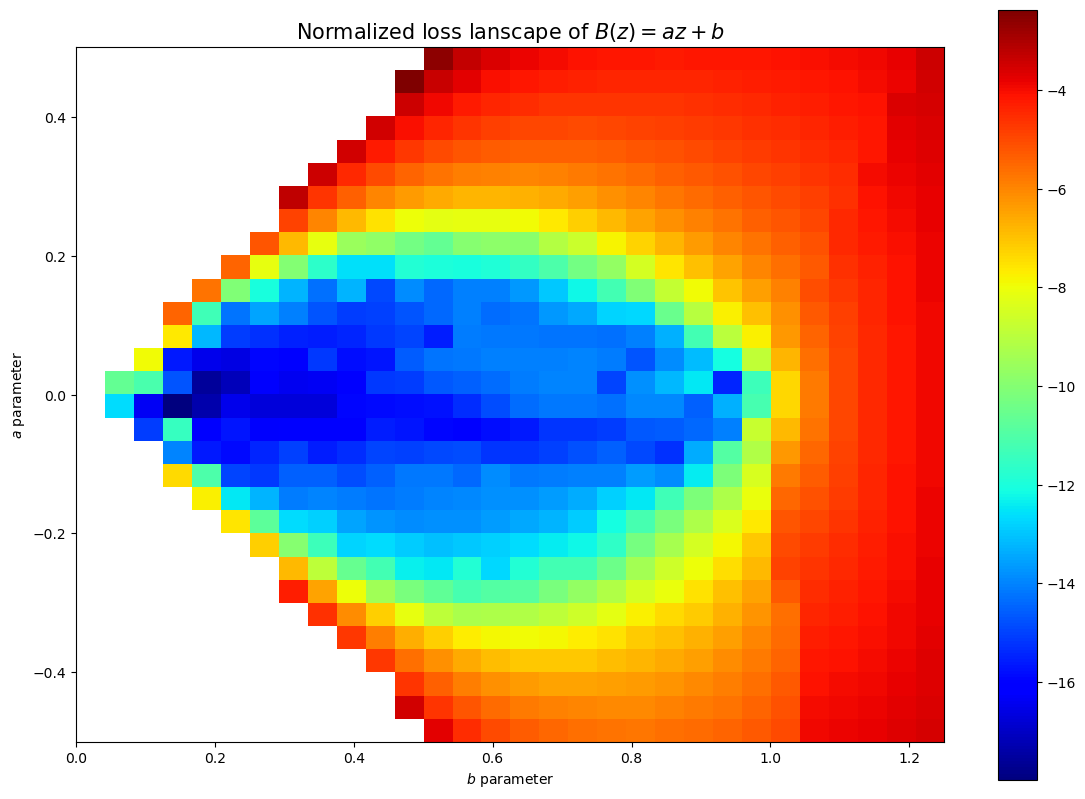

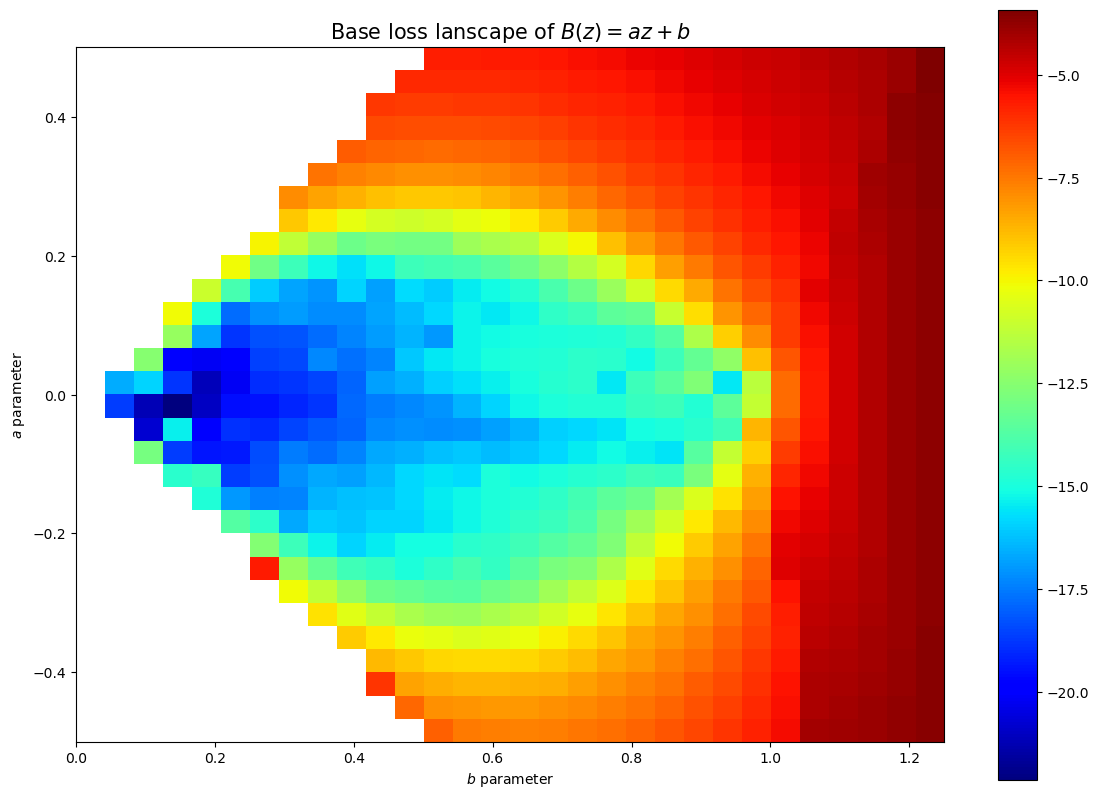

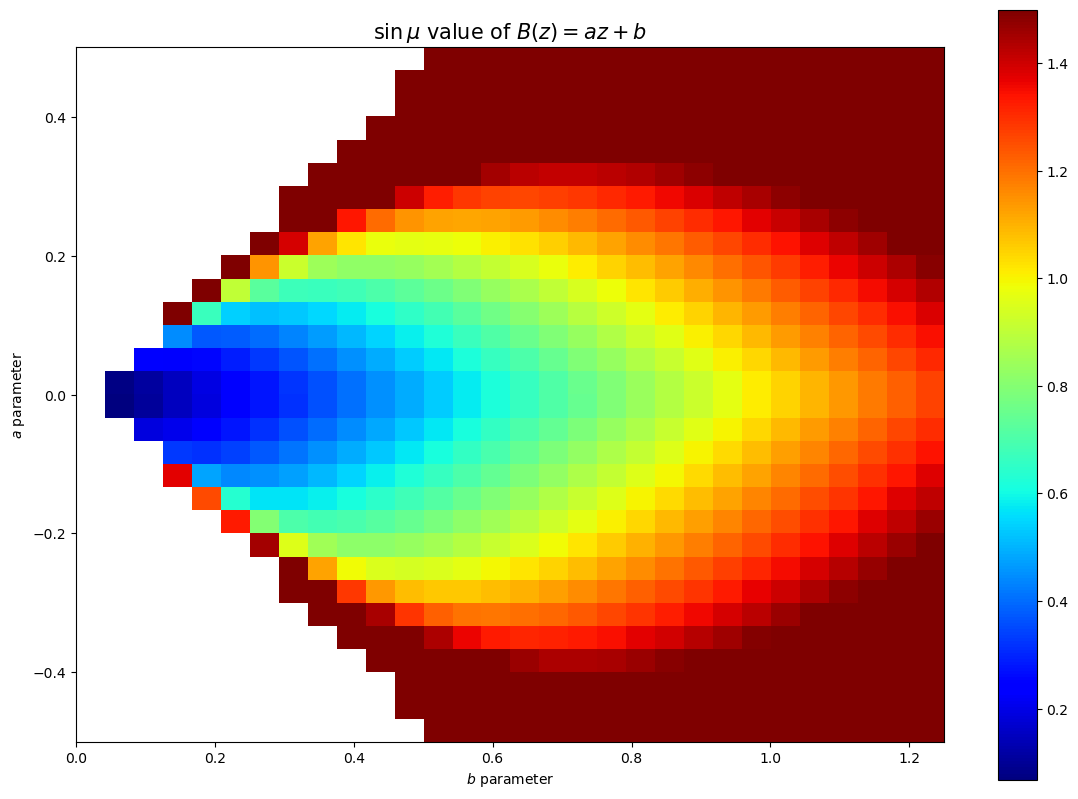

In [722]:
plot_contour_loss_curves_linear(log_res, run_scan, log_type='base10')

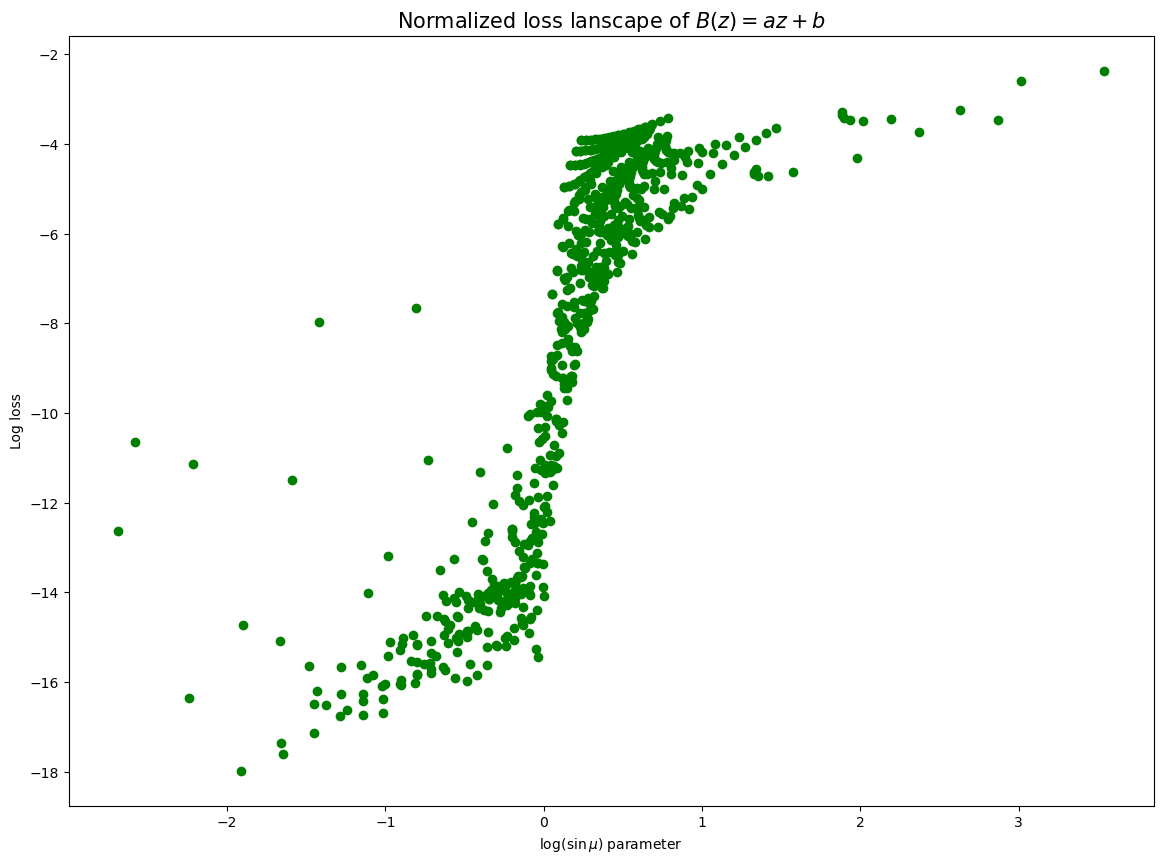

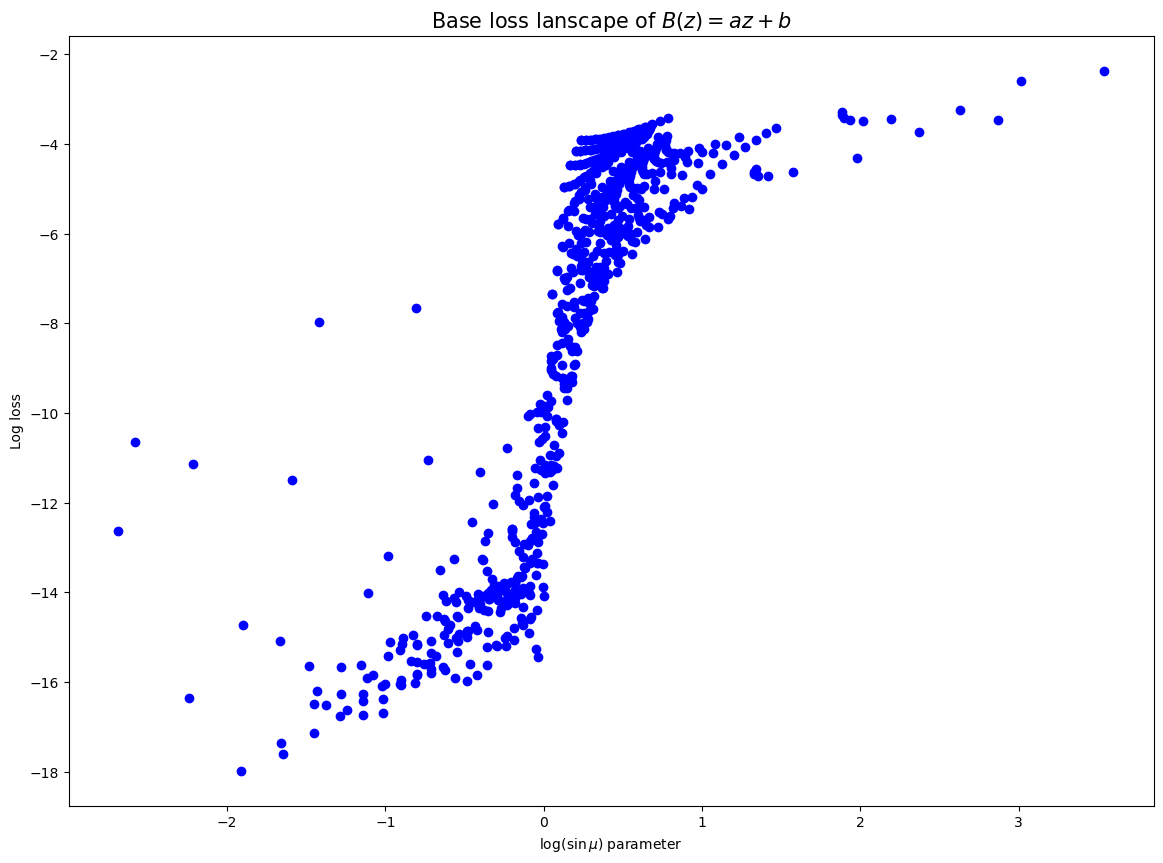

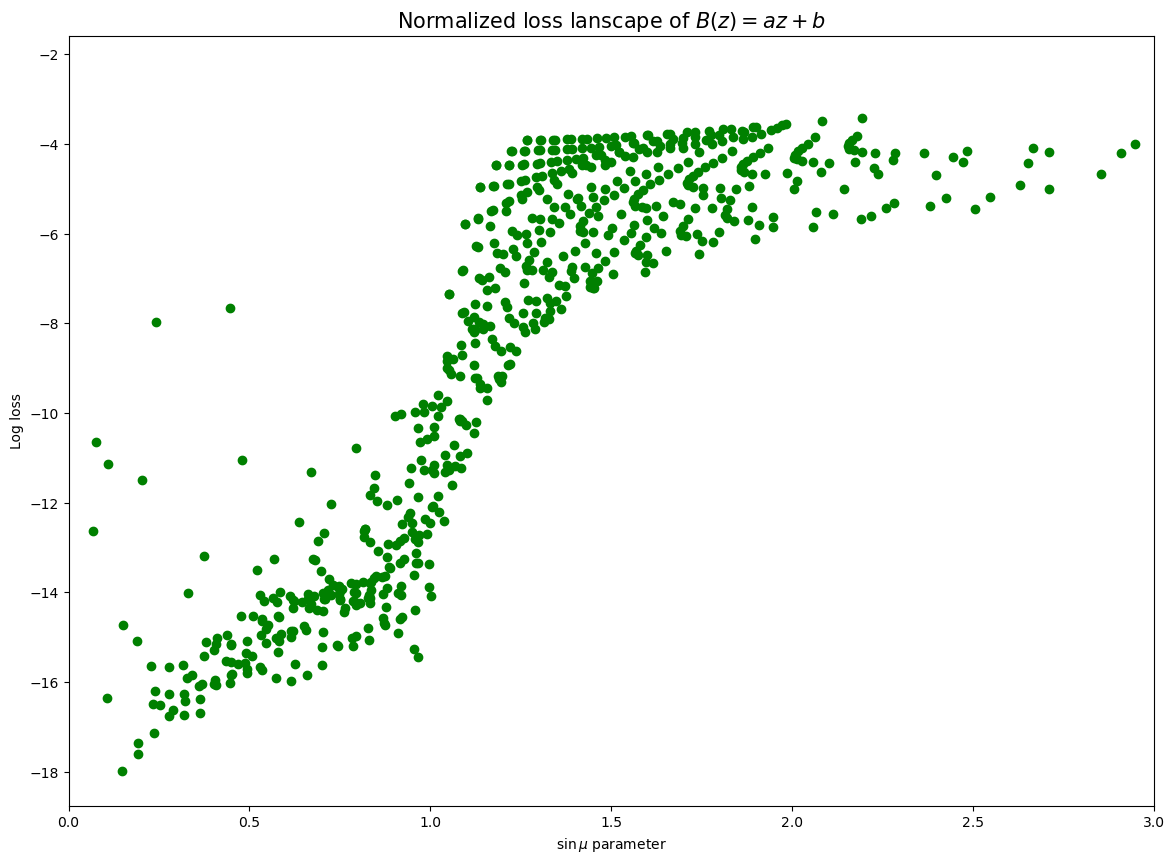

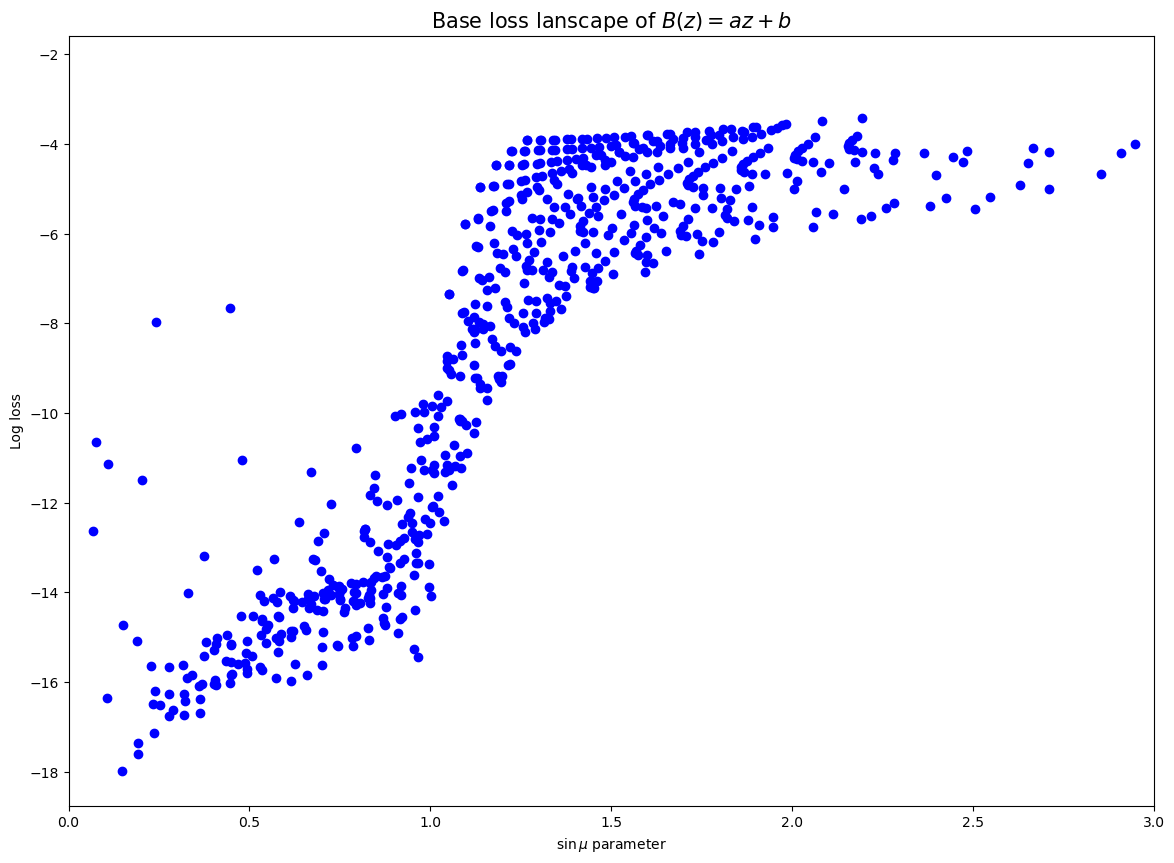

In [723]:
plot_sinmu_losses(log_res, run_scan, log_type='base10')

In [724]:
# Make sure to kill the Neptune logger run
run_scan.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 30 operations to synchronize with Neptune. Do not kill this process.
All 30 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-316


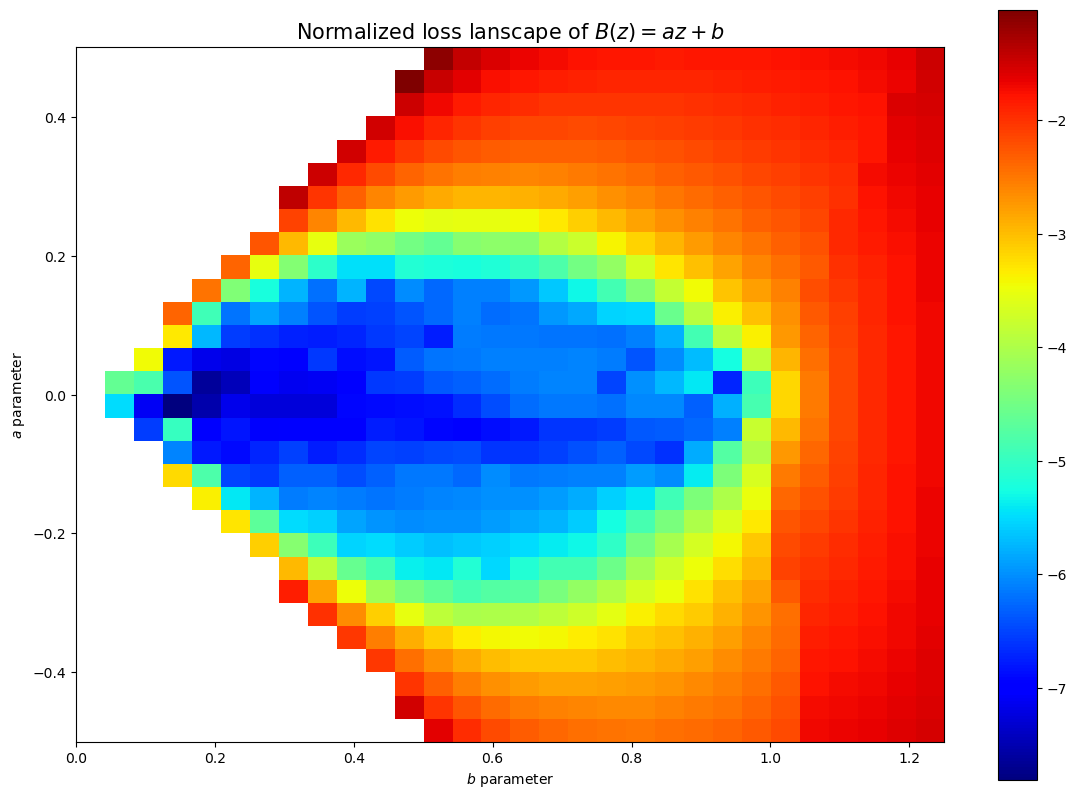

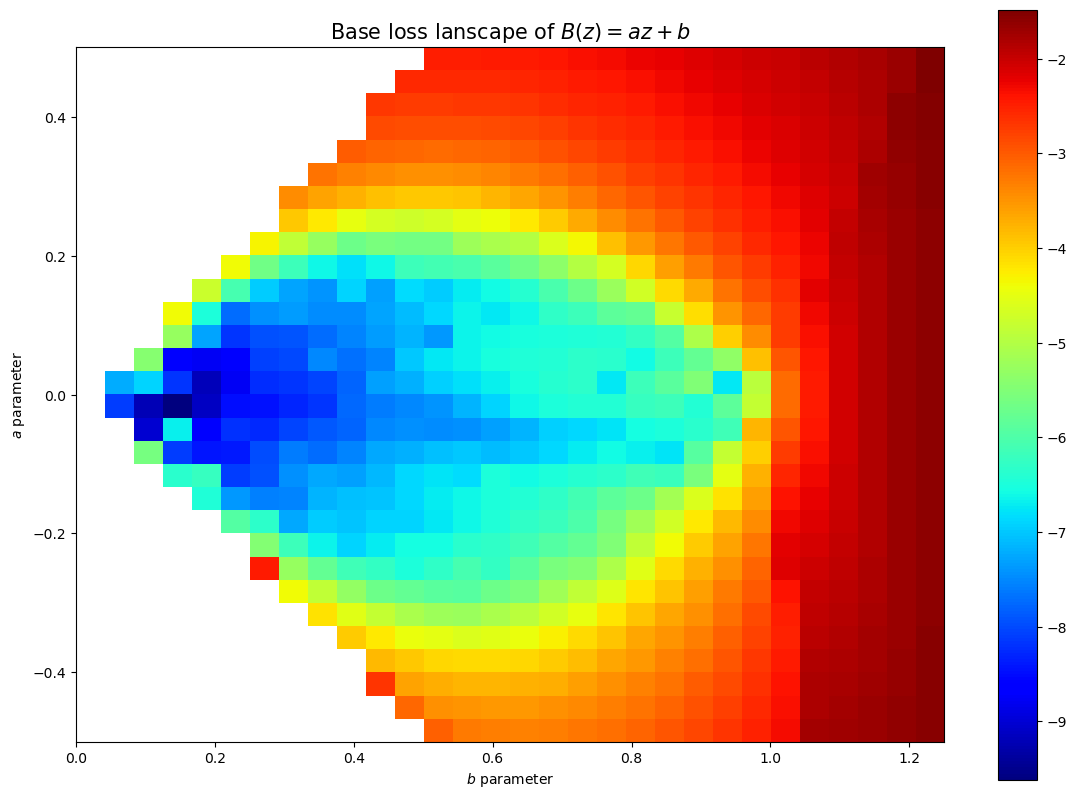

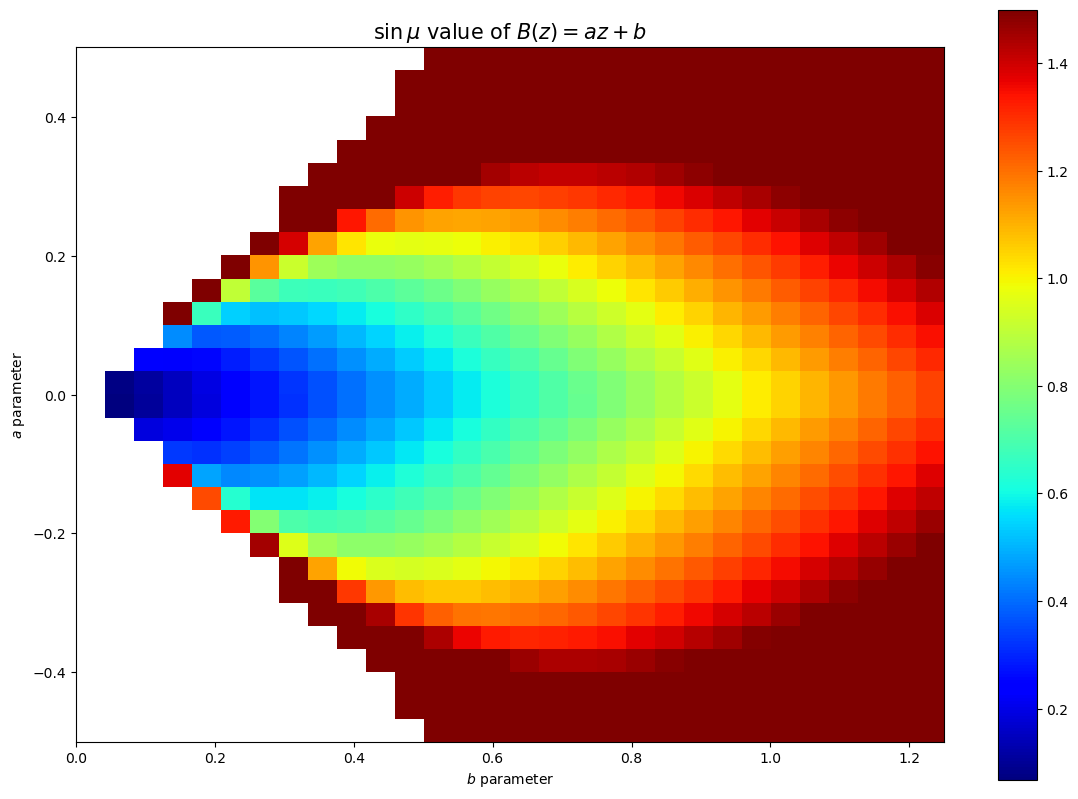

In [725]:
plot_contour_loss_curves_linear(log_res, run_scan,log_type='base10' ,logging=False)

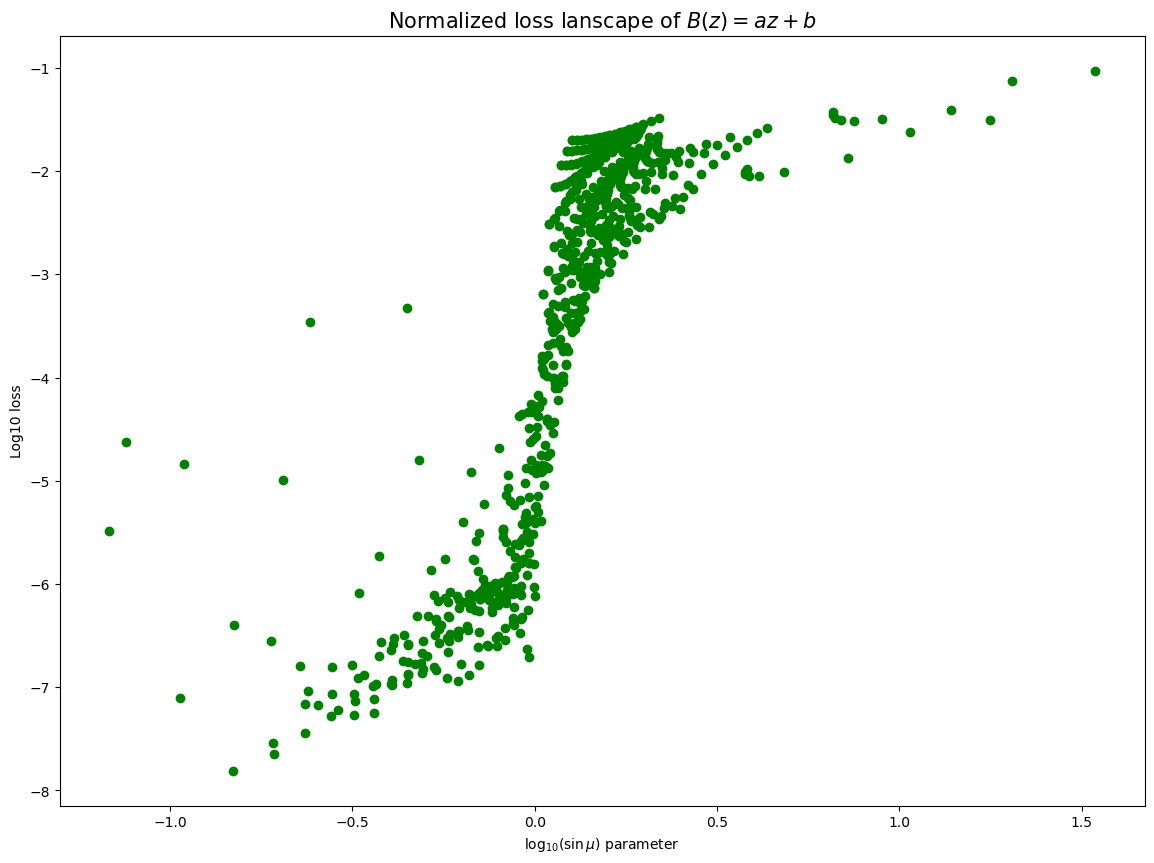

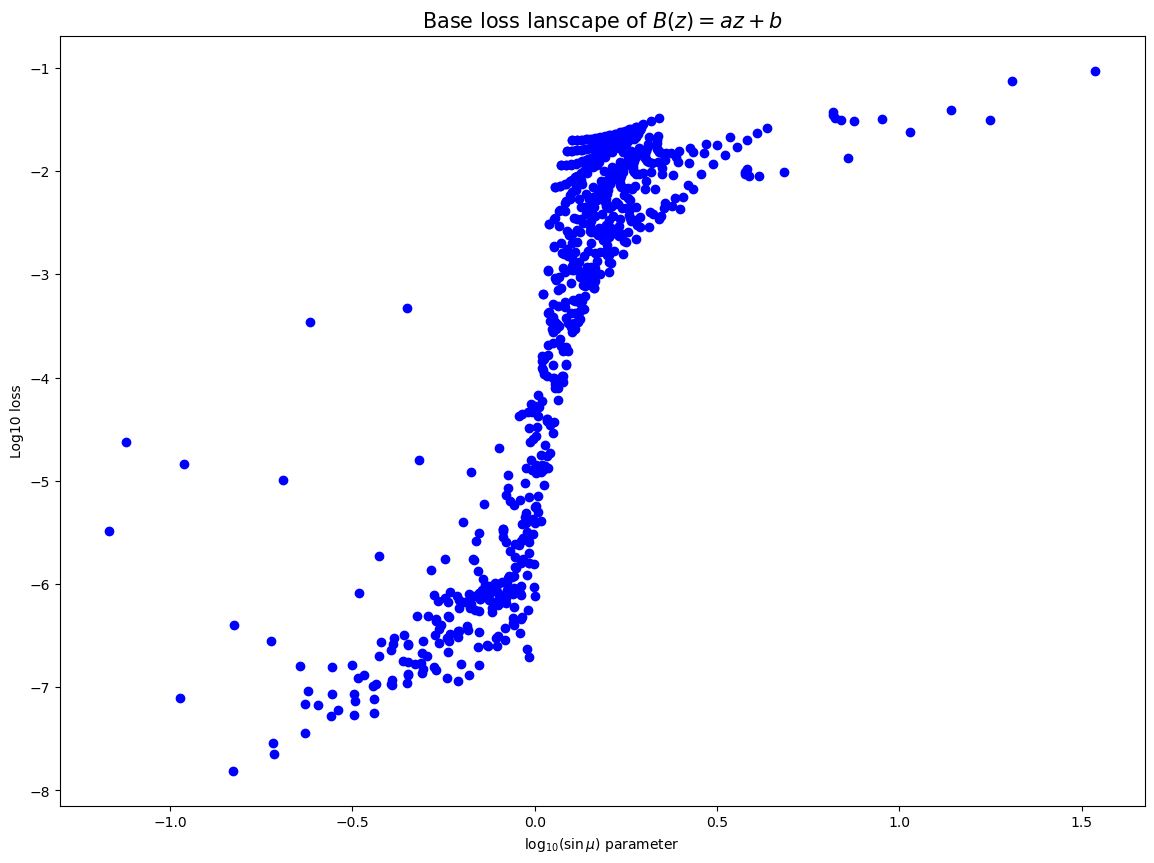

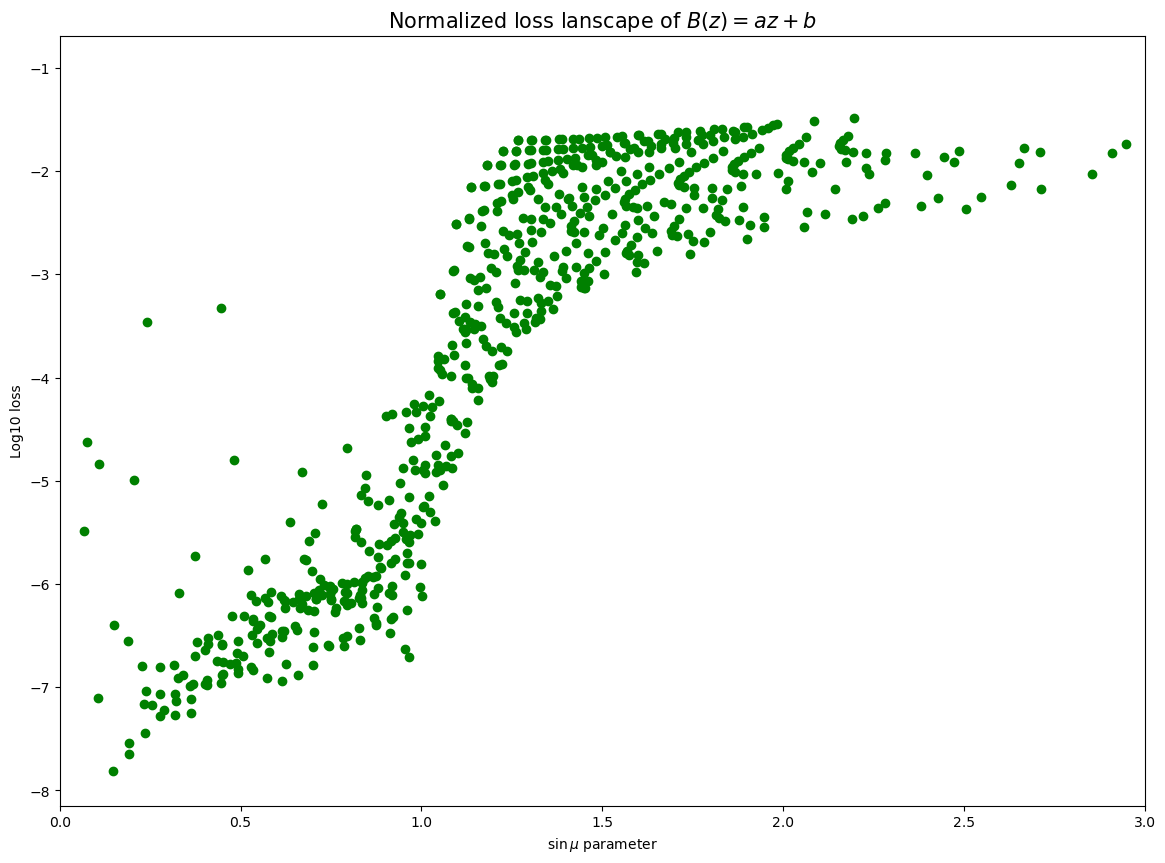

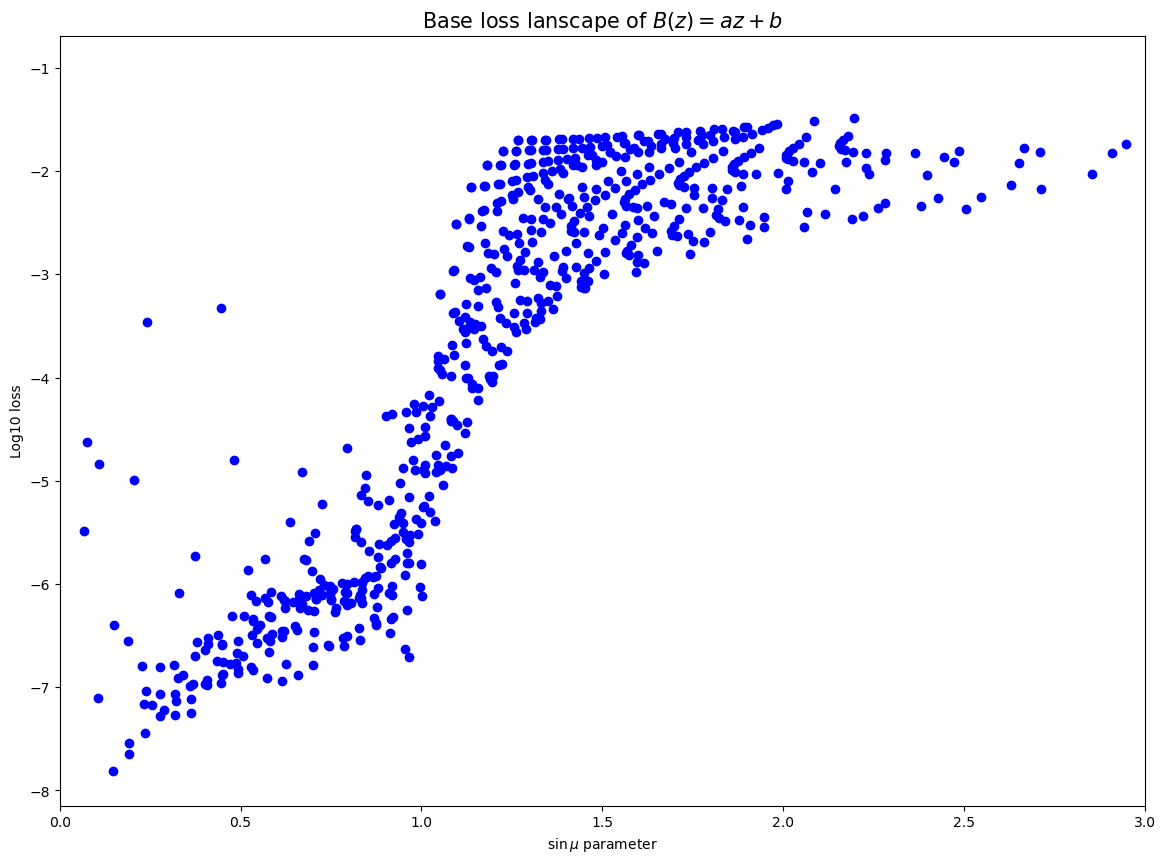

In [726]:
plot_sinmu_losses(log_res, run_scan, log_type='base10', logging=False)